In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing Requirements

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=b67d1e957c361e90bcaee4eb2186ddd3a5b67d4580b458fc5d7a1201e424b82c
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!pip install split-folders[full]

In [ ]:
!pip install unzip

  Preparing metadata (setup.py) ... done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1279 sha256=93e5d79123171dd43c30796715c0b6646533a74cc25956a20543d663199c30bb
  Stored in directory: /root/.cache/pip/wheels/80/dc/7a/f8af45bc239e7933509183f038ea8d46f3610aab82b35369f4
Successfully built unzip


In [ ]:
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Loading libraries
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.cm as cm
from IPython.display import Image, display

import numpy as np
import seaborn as sns
import pandas as pd
import random
import splitfolders

import os
import cv2
import PIL

import tensorflow
import datetime
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

from codecarbon import EmissionsTracker

from sklearn.metrics import classification_report, confusion_matrix

## Loading Dataset

In [ ]:
# Copying data to Colab
!unzip -q '/content/drive/MyDrive/US Project/Cleaned.zip'

In [ ]:
# Splitting dataset into train, val and test set
splitfolders.ratio('Cleaned',output='plane',seed=24,ratio=(0.8,0.1,0.1))

Copying files: 14414 files [01:02, 232.37 files/s]


In [ ]:
# File directories
train_data_dir = 'plane/train'
val_data_dir = 'plane/val'
test_data_dir = 'plane/test'

In [ ]:
target_size = (224,224)
input_shape = (224,224,3)
learning_rate = 0.00001
epochs = 20
batch_size = 16
dropout = 0.2

In [ ]:
# Creating image generator for augmentation of train set
train_image_gen  = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      rotation_range=20,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      fill_mode='constant'
                                    )
# Creating image generator for test set
test_image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Train set
print('.... Train set ....')
train_generator = train_image_gen.flow_from_directory(train_data_dir,
                                                target_size=target_size,
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

# Test set
print('.... Test set ....')
test_generator = test_image_gen.flow_from_directory(test_data_dir,
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

# Validation set
print('.... Validation set ....')
val_generator =  test_image_gen.flow_from_directory(val_data_dir,
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

.... Train set ....
Found 11528 images belonging to 7 classes.
.... Test set ....
Found 1447 images belonging to 7 classes.
.... Validation set ....
Found 1439 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

{'Fetal abdomen': 0,
 'Fetal brain': 1,
 'Fetal femur': 2,
 'Fetal thorax': 3,
 'Maternal cervix': 4,
 'Other': 5,
 'Unknown': 6}

## Sweep Configuration

In [ ]:
# Import the W&B Python Library and log into W&B
import wandb
from wandb.keras import WandbCallback
wandb.login()

In [ ]:
def train_model(config):

  input = Input(shape=input_shape)

  conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same")(input)
  bn1 = BatchNormalization()(conv1)
  act1 = Activation('relu')(bn1)
  conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same")(act1)
  bn2 = BatchNormalization()(conv2)
  act2 = Activation('relu')(bn2)
  pool1  = MaxPooling2D((2, 2))(act2)

  conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same")(pool1)
  bn3 = BatchNormalization()(conv3)
  act3 = Activation('relu')(bn3)
  conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same")(act3)
  bn4 = BatchNormalization()(conv4)
  act4 = Activation('relu')(bn4)
  pool2  = MaxPooling2D((2, 2))(act4)

  conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same")(pool2)
  bn5 = BatchNormalization()(conv5)
  act5 = Activation('relu')(bn5)
  conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same")(act5)
  bn6 = BatchNormalization()(conv6)
  act6 = Activation('relu')(bn6)
  conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same")(act6)
  bn7 = BatchNormalization()(conv7)
  act7 = Activation('relu')(bn7)
  pool3  = MaxPooling2D((2, 2))(act7)

  conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same")(pool3)
  bn8 = BatchNormalization()(conv8)
  act8 = Activation('relu')(bn8)
  conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act8)
  bn9 = BatchNormalization()(conv9)
  act9 = Activation('relu')(bn9)
  conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act9)
  bn10 = BatchNormalization()(conv10)
  act10 = Activation('relu')(bn10)
  pool4  = MaxPooling2D((2, 2))(act10)

  conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(pool4)
  bn11 = BatchNormalization()(conv11)
  act11 = Activation('relu')(bn11)
  conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act11)
  bn12 = BatchNormalization()(conv12)
  act12 = Activation('relu')(bn12)
  conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act12)
  bn13 = BatchNormalization()(conv13)
  act13 = Activation('relu')(bn13)
  pool5  = MaxPooling2D((2, 2))(act13)

  flat   = Flatten()(pool5)
  dense1 = Dense(config.first_hidden_layer)(flat)
  bn14 = BatchNormalization()(dense1)
  act14 = Activation('relu')(bn14)
  drop1 = Dropout(config.dropout)(act14)
  dense2 = Dense(config.second_hidden_layer)(drop1)
  bn15 = BatchNormalization()(dense2)
  act15 = Activation('relu')(bn15)
  drop2 = Dropout(config.dropout)(act15)
  output = Dense(7, activation="softmax")(drop2)


  model = Model(inputs=input, outputs=output)

  return model

In [ ]:
config_defaults = {
   'epochs' : 20,
   'batch_size' : 16,
   'learning_rate' : 0.00001,
   'seed' : 4,
   'dropout' : 0.2,
   'first_hidden_layer' : 4096,
   'second_hidden_layer' : 4096
                     }

In [ ]:
def train():
  with wandb.init(project='pt-sweep',config=config_defaults) as run:
    config = wandb.config
    model = train_model(config)
    # Compiling model
    model.compile(optimizer=Adam(config.learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    # Model fitting
    model.fit(train_generator,validation_data=val_generator,callbacks=[WandbCallback(save_model=(False))],epochs=config.epochs)

In [ ]:
# Step 2: Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'minimize', 'name': 'loss'},
    'parameters':
    {
        'batch_size': {'values': [16,32]},
        'epochs': {'values': [20]},
        'learning_rate': {'max': 0.01, 'min': 0.00001},
        'first_hidden_layer': {'values': [512,1024,2048,4096]},
        'second_hidden_layer': {'values': [512,1024,2048,4096]},
        'dropout' : {'values': [0.1,0.2,0.3,0.4,0.5]},
     }
}

In [ ]:
# 3: Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project='pt-sweep'
    )

In [ ]:
# Step 4: Call to `wandb.agent` to start a sweep
wandb.agent(sweep_id, function=train, count=1000)

## Model training

In [ ]:
input = Input(shape=input_shape)

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same")(input)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same")(act1)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
pool1  = MaxPooling2D((2, 2))(act2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same")(pool1)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same")(act3)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
pool2  = MaxPooling2D((2, 2))(act4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same")(pool2)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same")(act5)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same")(act6)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)
pool3  = MaxPooling2D((2, 2))(act7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same")(pool3)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act8)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act9)
bn10 = BatchNormalization()(conv10)
act10 = Activation('relu')(bn10)
pool4  = MaxPooling2D((2, 2))(act10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(pool4)
bn11 = BatchNormalization()(conv11)
act11 = Activation('relu')(bn11)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act11)
bn12 = BatchNormalization()(conv12)
act12 = Activation('relu')(bn12)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same")(act12)
bn13 = BatchNormalization()(conv13)
act13 = Activation('relu')(bn13)
pool5  = MaxPooling2D((2, 2))(act13)

flat   = Flatten()(pool5)
dense1 = Dense(4096)(flat)
bn14 = BatchNormalization()(dense1)
act14 = Activation('relu')(bn14)
drop1 = Dropout(dropout)(act14)
dense2 = Dense(4096)(drop1)
bn15 = BatchNormalization()(dense2)
act15 = Activation('relu')(bn15)
drop2 = Dropout(dropout)(act15)
output = Dense(7, activation="softmax")(drop2)


model = Model(inputs=input, outputs=output)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model = load_model('/content/drive/MyDrive/US Project/US_Plane_v1.h5')

In [ ]:
# Compiling model
model.compile(optimizer=Adam(learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
tracker = EmissionsTracker()
tracker.start()

[codecarbon INFO @ 07:26:34] [setup] RAM Tracking...
[codecarbon INFO @ 07:26:34] [setup] GPU Tracking...
[codecarbon INFO @ 07:26:34] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:26:34] [setup] CPU Tracking...
[codecarbon WARNING @ 07:26:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 07:26:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:26:35] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 07:26:35] >>> Tracker's metadata:
[codecarbon INFO @ 07:26:35]   Platform system: Linux-5.15.107+-x86_64-with-glibc2.31
[codecarbon INFO @ 07:26:35]   Python version: 3.10.12
[codecarbon INFO @ 07:26:35]   CodeCarbon version: 2.2.4
[codecarbon INFO @ 07:26:35]   Available RAM : 12.678 GB
[codecarbon INFO @ 07:26:35]   CPU count: 2
[codecarbon INFO @ 07:26:35]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 07:26:35]   GPU

In [ ]:
# Model fitting
model.fit(train_generator,validation_data=val_generator,epochs=epochs)

Epoch 1/20


[codecarbon INFO @ 07:27:05] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:27:05] Energy consumed for all GPUs : 0.000232 kWh. Total GPU Power : 27.944 W
[codecarbon INFO @ 07:27:05] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:27:05] 0.000626 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:27:20] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:27:20] Energy consumed for all GPUs : 0.000380 kWh. Total GPU Power : 35.522 W
[codecarbon INFO @ 07:27:20] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:27:20] 0.000971 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:27:35] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:27:35] Energy consumed for all GPUs : 0.000565 kWh. Total GPU Power : 44.508 W
[codecarbon INFO @ 07:27:35] E

 19/721 [..............................] - ETA: 6:01 - loss: 1.8469 - accuracy: 0.3092

[codecarbon INFO @ 07:27:50] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:27:50] Energy consumed for all GPUs : 0.000908 kWh. Total GPU Power : 82.424 W
[codecarbon INFO @ 07:27:51] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:27:51] 0.001893 kWh of electricity used since the beginning.


 46/721 [>.............................] - ETA: 6:00 - loss: 1.7084 - accuracy: 0.3533

[codecarbon INFO @ 07:28:05] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:28:05] Energy consumed for all GPUs : 0.001066 kWh. Total GPU Power : 38.069 W
[codecarbon INFO @ 07:28:05] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:28:05] 0.002248 kWh of electricity used since the beginning.


 76/721 [==>...........................] - ETA: 5:39 - loss: 1.5594 - accuracy: 0.4293

[codecarbon INFO @ 07:28:20] Energy consumed for RAM : 0.000138 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:28:20] Energy consumed for all GPUs : 0.001272 kWh. Total GPU Power : 49.407000000000004 W
[codecarbon INFO @ 07:28:20] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:28:20] 0.002650 kWh of electricity used since the beginning.


104/721 [===>..........................] - ETA: 5:25 - loss: 1.4449 - accuracy: 0.4760

[codecarbon INFO @ 07:28:35] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:28:35] Energy consumed for all GPUs : 0.001436 kWh. Total GPU Power : 39.406 W
[codecarbon INFO @ 07:28:35] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:28:35] 0.003011 kWh of electricity used since the beginning.


133/721 [====>.........................] - ETA: 5:07 - loss: 1.3746 - accuracy: 0.5023

[codecarbon INFO @ 07:28:50] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:28:50] Energy consumed for all GPUs : 0.001727 kWh. Total GPU Power : 69.802 W
[codecarbon INFO @ 07:28:50] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W


134/721 [====>.........................] - ETA: 5:06 - loss: 1.3702 - accuracy: 0.5037

[codecarbon INFO @ 07:28:51] 0.003499 kWh of electricity used since the beginning.


158/721 [=====>........................] - ETA: 5:00 - loss: 1.3116 - accuracy: 0.5257

[codecarbon INFO @ 07:29:05] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:29:05] Energy consumed for all GPUs : 0.002034 kWh. Total GPU Power : 73.726 W


159/721 [=====>........................] - ETA: 5:00 - loss: 1.3076 - accuracy: 0.5271

[codecarbon INFO @ 07:29:06] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:29:06] 0.004002 kWh of electricity used since the beginning.


186/721 [======>.......................] - ETA: 4:47 - loss: 1.2756 - accuracy: 0.5403

[codecarbon INFO @ 07:29:20] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:29:21] Energy consumed for all GPUs : 0.002219 kWh. Total GPU Power : 44.58 W
[codecarbon INFO @ 07:29:21] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:29:21] 0.004385 kWh of electricity used since the beginning.


214/721 [=======>......................] - ETA: 4:31 - loss: 1.2214 - accuracy: 0.5587

[codecarbon INFO @ 07:29:35] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.754399299621582 W


215/721 [=======>......................] - ETA: 4:30 - loss: 1.2194 - accuracy: 0.5590

[codecarbon INFO @ 07:29:36] Energy consumed for all GPUs : 0.002515 kWh. Total GPU Power : 71.08500000000001 W
[codecarbon INFO @ 07:29:36] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:29:36] 0.004877 kWh of electricity used since the beginning.


243/721 [=========>....................] - ETA: 4:15 - loss: 1.1901 - accuracy: 0.5702

[codecarbon INFO @ 07:29:51] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:29:51] Energy consumed for all GPUs : 0.002805 kWh. Total GPU Power : 69.661 W
[codecarbon INFO @ 07:29:51] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:29:51] 0.005364 kWh of electricity used since the beginning.


272/721 [==========>...................] - ETA: 3:58 - loss: 1.1656 - accuracy: 0.5790

[codecarbon INFO @ 07:30:06] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:30:06] Energy consumed for all GPUs : 0.003102 kWh. Total GPU Power : 71.423 W
[codecarbon INFO @ 07:30:06] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:30:06] 0.005858 kWh of electricity used since the beginning.


302/721 [===========>..................] - ETA: 3:41 - loss: 1.1322 - accuracy: 0.5898

[codecarbon INFO @ 07:30:21] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:30:21] Energy consumed for all GPUs : 0.003401 kWh. Total GPU Power : 71.77 W
[codecarbon INFO @ 07:30:21] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:30:21] 0.006353 kWh of electricity used since the beginning.


333/721 [============>.................] - ETA: 3:23 - loss: 1.1039 - accuracy: 0.6021

[codecarbon INFO @ 07:30:36] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:30:36] Energy consumed for all GPUs : 0.003560 kWh. Total GPU Power : 38.343 W
[codecarbon INFO @ 07:30:36] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:30:36] 0.006710 kWh of electricity used since the beginning.


362/721 [==============>...............] - ETA: 3:08 - loss: 1.0799 - accuracy: 0.6114

[codecarbon INFO @ 07:30:51] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:30:51] Energy consumed for all GPUs : 0.003871 kWh. Total GPU Power : 74.611 W
[codecarbon INFO @ 07:30:51] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:30:51] 0.007217 kWh of electricity used since the beginning.


390/721 [===============>..............] - ETA: 2:53 - loss: 1.0622 - accuracy: 0.6178

[codecarbon INFO @ 07:31:06] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:31:06] Energy consumed for all GPUs : 0.004162 kWh. Total GPU Power : 70.053 W
[codecarbon INFO @ 07:31:06] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:31:06] 0.007705 kWh of electricity used since the beginning.


415/721 [================>.............] - ETA: 2:40 - loss: 1.0432 - accuracy: 0.6248

[codecarbon INFO @ 07:31:21] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:31:21] Energy consumed for all GPUs : 0.004468 kWh. Total GPU Power : 73.485 W
[codecarbon INFO @ 07:31:21] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:31:21] 0.008208 kWh of electricity used since the beginning.


440/721 [=================>............] - ETA: 2:30 - loss: 1.0305 - accuracy: 0.6305

[codecarbon INFO @ 07:31:36] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:31:36] Energy consumed for all GPUs : 0.004642 kWh. Total GPU Power : 41.872 W
[codecarbon INFO @ 07:31:36] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:31:36] 0.008579 kWh of electricity used since the beginning.


470/721 [==================>...........] - ETA: 2:13 - loss: 1.0124 - accuracy: 0.6374

[codecarbon INFO @ 07:31:51] Energy consumed for RAM : 0.000415 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:31:51] Energy consumed for all GPUs : 0.004822 kWh. Total GPU Power : 43.227000000000004 W
[codecarbon INFO @ 07:31:51] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:31:51] 0.008956 kWh of electricity used since the beginning.


500/721 [===================>..........] - ETA: 1:56 - loss: 0.9955 - accuracy: 0.6438

[codecarbon INFO @ 07:32:06] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:32:06] Energy consumed for all GPUs : 0.005120 kWh. Total GPU Power : 71.618 W


501/721 [===================>..........] - ETA: 1:56 - loss: 0.9959 - accuracy: 0.6436

[codecarbon INFO @ 07:32:06] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:32:06] 0.009451 kWh of electricity used since the beginning.


528/721 [====================>.........] - ETA: 1:42 - loss: 0.9794 - accuracy: 0.6504

[codecarbon INFO @ 07:32:21] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:32:21] Energy consumed for all GPUs : 0.005398 kWh. Total GPU Power : 66.906 W
[codecarbon INFO @ 07:32:21] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:32:21] 0.009925 kWh of electricity used since the beginning.


557/721 [======================>.......] - ETA: 1:26 - loss: 0.9682 - accuracy: 0.6545

[codecarbon INFO @ 07:32:36] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:32:36] Energy consumed for all GPUs : 0.005573 kWh. Total GPU Power : 42.069 W
[codecarbon INFO @ 07:32:36] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:32:36] 0.010297 kWh of electricity used since the beginning.


587/721 [=======================>......] - ETA: 1:10 - loss: 0.9491 - accuracy: 0.6621

[codecarbon INFO @ 07:32:51] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:32:51] Energy consumed for all GPUs : 0.005818 kWh. Total GPU Power : 58.72 W
[codecarbon INFO @ 07:32:51] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:32:51] 0.010739 kWh of electricity used since the beginning.


618/721 [========================>.....] - ETA: 54s - loss: 0.9346 - accuracy: 0.6671

[codecarbon INFO @ 07:33:06] Energy consumed for RAM : 0.000514 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:33:06] Energy consumed for all GPUs : 0.005980 kWh. Total GPU Power : 38.936 W
[codecarbon INFO @ 07:33:06] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:33:06] 0.011098 kWh of electricity used since the beginning.


649/721 [==========================>...] - ETA: 37s - loss: 0.9208 - accuracy: 0.6721

[codecarbon INFO @ 07:33:21] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:33:21] Energy consumed for all GPUs : 0.006291 kWh. Total GPU Power : 74.85300000000002 W
[codecarbon INFO @ 07:33:21] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:33:21] 0.011606 kWh of electricity used since the beginning.


678/721 [===========================>..] - ETA: 22s - loss: 0.9077 - accuracy: 0.6768

[codecarbon INFO @ 07:33:36] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:33:36] Energy consumed for all GPUs : 0.006583 kWh. Total GPU Power : 70.151 W


679/721 [===========================>..] - ETA: 21s - loss: 0.9078 - accuracy: 0.6768

[codecarbon INFO @ 07:33:36] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:33:36] 0.012095 kWh of electricity used since the beginning.


709/721 [============================>.] - ETA: 6s - loss: 0.8950 - accuracy: 0.6819

[codecarbon INFO @ 07:33:51] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:33:51] Energy consumed for all GPUs : 0.006763 kWh. Total GPU Power : 43.227000000000004 W
[codecarbon INFO @ 07:33:51] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:33:51] 0.012471 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 0.6836

[codecarbon INFO @ 07:34:06] Energy consumed for RAM : 0.000593 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:34:06] Energy consumed for all GPUs : 0.006916 kWh. Total GPU Power : 36.786 W
[codecarbon INFO @ 07:34:06] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:34:06] 0.012821 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:34:21] Energy consumed for RAM : 0.000613 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:34:21] Energy consumed for all GPUs : 0.007222 kWh. Total GPU Power : 73.726 W
[codecarbon INFO @ 07:34:21] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:34:21] 0.013324 kWh of electricity used since the beginning.


721/721 [==============================] - 441s 558ms/step - loss: 0.8910 - accuracy: 0.6836 - val_loss: 0.4776 - val_accuracy: 0.8242
Epoch 2/20
 26/721 [>.............................] - ETA: 5:39 - loss: 0.6990 - accuracy: 0.7404

[codecarbon INFO @ 07:34:36] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:34:36] Energy consumed for all GPUs : 0.007515 kWh. Total GPU Power : 70.444 W
[codecarbon INFO @ 07:34:36] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:34:36] 0.013814 kWh of electricity used since the beginning.


 58/721 [=>............................] - ETA: 5:16 - loss: 0.6440 - accuracy: 0.7705

[codecarbon INFO @ 07:34:51] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:34:51] Energy consumed for all GPUs : 0.007728 kWh. Total GPU Power : 51.02 W
[codecarbon INFO @ 07:34:51] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:34:51] 0.014223 kWh of electricity used since the beginning.


 88/721 [==>...........................] - ETA: 5:06 - loss: 0.6127 - accuracy: 0.7820

[codecarbon INFO @ 07:35:06] Energy consumed for RAM : 0.000672 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:35:06] Energy consumed for all GPUs : 0.007908 kWh. Total GPU Power : 43.325 W
[codecarbon INFO @ 07:35:06] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:35:06] 0.014601 kWh of electricity used since the beginning.


119/721 [===>..........................] - ETA: 4:51 - loss: 0.6141 - accuracy: 0.7841

[codecarbon INFO @ 07:35:21] Energy consumed for RAM : 0.000692 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:35:21] Energy consumed for all GPUs : 0.008086 kWh. Total GPU Power : 42.636 W
[codecarbon INFO @ 07:35:21] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:35:21] 0.014975 kWh of electricity used since the beginning.


150/721 [=====>........................] - ETA: 4:36 - loss: 0.6095 - accuracy: 0.7833

[codecarbon INFO @ 07:35:36] Energy consumed for RAM : 0.000712 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:35:36] Energy consumed for all GPUs : 0.008360 kWh. Total GPU Power : 65.828 W
[codecarbon INFO @ 07:35:36] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:35:36] 0.015446 kWh of electricity used since the beginning.


181/721 [======>.......................] - ETA: 4:21 - loss: 0.5981 - accuracy: 0.7856

[codecarbon INFO @ 07:35:51] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:35:51] Energy consumed for all GPUs : 0.008594 kWh. Total GPU Power : 56.264 W
[codecarbon INFO @ 07:35:51] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:35:51] 0.015876 kWh of electricity used since the beginning.


211/721 [=======>......................] - ETA: 4:08 - loss: 0.5959 - accuracy: 0.7861

[codecarbon INFO @ 07:36:06] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:36:06] Energy consumed for all GPUs : 0.008762 kWh. Total GPU Power : 40.515 W
[codecarbon INFO @ 07:36:06] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:36:06] 0.016242 kWh of electricity used since the beginning.


241/721 [=========>....................] - ETA: 3:54 - loss: 0.5825 - accuracy: 0.7910

[codecarbon INFO @ 07:36:21] Energy consumed for RAM : 0.000771 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:36:21] Energy consumed for all GPUs : 0.008939 kWh. Total GPU Power : 42.365 W
[codecarbon INFO @ 07:36:21] Energy consumed for all CPUs : 0.006905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:36:21] 0.016615 kWh of electricity used since the beginning.


269/721 [==========>...................] - ETA: 3:42 - loss: 0.5810 - accuracy: 0.7918

[codecarbon INFO @ 07:36:36] Energy consumed for RAM : 0.000791 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:36:36] Energy consumed for all GPUs : 0.009122 kWh. Total GPU Power : 44.015 W
[codecarbon INFO @ 07:36:36] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:36:36] 0.016995 kWh of electricity used since the beginning.


299/721 [===========>..................] - ETA: 3:28 - loss: 0.5742 - accuracy: 0.7941

[codecarbon INFO @ 07:36:51] Energy consumed for RAM : 0.000811 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:36:51] Energy consumed for all GPUs : 0.009416 kWh. Total GPU Power : 70.684 W
[codecarbon INFO @ 07:36:51] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:36:51] 0.017486 kWh of electricity used since the beginning.


329/721 [============>.................] - ETA: 3:13 - loss: 0.5710 - accuracy: 0.7964

[codecarbon INFO @ 07:37:06] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:37:06] Energy consumed for all GPUs : 0.009796 kWh. Total GPU Power : 91.278 W
[codecarbon INFO @ 07:37:06] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:37:06] 0.018063 kWh of electricity used since the beginning.


361/721 [==============>...............] - ETA: 2:56 - loss: 0.5740 - accuracy: 0.7957

[codecarbon INFO @ 07:37:21] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:37:21] Energy consumed for all GPUs : 0.010172 kWh. Total GPU Power : 90.636 W
[codecarbon INFO @ 07:37:21] Energy consumed for all CPUs : 0.007613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:37:21] 0.018636 kWh of electricity used since the beginning.


392/721 [===============>..............] - ETA: 2:41 - loss: 0.5675 - accuracy: 0.7966

[codecarbon INFO @ 07:37:36] Energy consumed for RAM : 0.000870 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:37:36] Energy consumed for all GPUs : 0.010355 kWh. Total GPU Power : 43.818 W
[codecarbon INFO @ 07:37:36] Energy consumed for all CPUs : 0.007790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:37:36] 0.019015 kWh of electricity used since the beginning.


422/721 [================>.............] - ETA: 2:26 - loss: 0.5595 - accuracy: 0.7995

[codecarbon INFO @ 07:37:51] Energy consumed for RAM : 0.000890 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:37:51] Energy consumed for all GPUs : 0.010751 kWh. Total GPU Power : 95.249 W
[codecarbon INFO @ 07:37:51] Energy consumed for all CPUs : 0.007967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:37:51] 0.019608 kWh of electricity used since the beginning.


453/721 [=================>............] - ETA: 2:11 - loss: 0.5618 - accuracy: 0.8015

[codecarbon INFO @ 07:38:06] Energy consumed for RAM : 0.000910 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:38:06] Energy consumed for all GPUs : 0.010904 kWh. Total GPU Power : 36.884 W
[codecarbon INFO @ 07:38:06] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:38:06] 0.019959 kWh of electricity used since the beginning.


484/721 [===================>..........] - ETA: 1:56 - loss: 0.5609 - accuracy: 0.8018

[codecarbon INFO @ 07:38:21] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:38:21] Energy consumed for all GPUs : 0.011282 kWh. Total GPU Power : 90.71700000000001 W
[codecarbon INFO @ 07:38:21] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:38:21] 0.020534 kWh of electricity used since the beginning.


515/721 [====================>.........] - ETA: 1:41 - loss: 0.5624 - accuracy: 0.8006

[codecarbon INFO @ 07:38:36] Energy consumed for RAM : 0.000949 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:38:36] Energy consumed for all GPUs : 0.011448 kWh. Total GPU Power : 39.702 W
[codecarbon INFO @ 07:38:36] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:38:36] 0.020896 kWh of electricity used since the beginning.


544/721 [=====================>........] - ETA: 1:27 - loss: 0.5582 - accuracy: 0.8012

[codecarbon INFO @ 07:38:51] Energy consumed for RAM : 0.000969 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:38:51] Energy consumed for all GPUs : 0.011629 kWh. Total GPU Power : 43.621 W
[codecarbon INFO @ 07:38:51] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:38:51] 0.021274 kWh of electricity used since the beginning.


573/721 [======================>.......] - ETA: 1:12 - loss: 0.5576 - accuracy: 0.8015

[codecarbon INFO @ 07:39:06] Energy consumed for RAM : 0.000989 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:39:06] Energy consumed for all GPUs : 0.011952 kWh. Total GPU Power : 77.541 W
[codecarbon INFO @ 07:39:06] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:39:06] 0.021794 kWh of electricity used since the beginning.


602/721 [========================>.....] - ETA: 58s - loss: 0.5556 - accuracy: 0.8019

[codecarbon INFO @ 07:39:21] Energy consumed for RAM : 0.001009 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:39:21] Energy consumed for all GPUs : 0.012256 kWh. Total GPU Power : 73.237 W
[codecarbon INFO @ 07:39:21] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:39:21] 0.022295 kWh of electricity used since the beginning.


631/721 [=========================>....] - ETA: 44s - loss: 0.5523 - accuracy: 0.8029

[codecarbon INFO @ 07:39:36] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:39:36] Energy consumed for all GPUs : 0.012440 kWh. Total GPU Power : 44.212 W
[codecarbon INFO @ 07:39:36] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:39:36] 0.022676 kWh of electricity used since the beginning.


661/721 [==========================>...] - ETA: 29s - loss: 0.5528 - accuracy: 0.8024

[codecarbon INFO @ 07:39:51] Energy consumed for RAM : 0.001048 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:39:51] Energy consumed for all GPUs : 0.012600 kWh. Total GPU Power : 38.343 W
[codecarbon INFO @ 07:39:51] Energy consumed for all CPUs : 0.009384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:39:51] 0.023032 kWh of electricity used since the beginning.


691/721 [===========================>..] - ETA: 14s - loss: 0.5482 - accuracy: 0.8041

[codecarbon INFO @ 07:40:06] Energy consumed for RAM : 0.001068 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:40:06] Energy consumed for all GPUs : 0.012946 kWh. Total GPU Power : 83.251 W
[codecarbon INFO @ 07:40:06] Energy consumed for all CPUs : 0.009561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:40:06] 0.023575 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.8047

[codecarbon INFO @ 07:40:21] Energy consumed for RAM : 0.001088 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:40:21] Energy consumed for all GPUs : 0.013113 kWh. Total GPU Power : 39.922000000000004 W
[codecarbon INFO @ 07:40:21] Energy consumed for all CPUs : 0.009738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:40:21] 0.023938 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:40:36] Energy consumed for RAM : 0.001108 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:40:36] Energy consumed for all GPUs : 0.013252 kWh. Total GPU Power : 33.466 W
[codecarbon INFO @ 07:40:36] Energy consumed for all CPUs : 0.009915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:40:36] 0.024274 kWh of electricity used since the beginning.


721/721 [==============================] - 383s 532ms/step - loss: 0.5459 - accuracy: 0.8047 - val_loss: 0.4405 - val_accuracy: 0.8610


[codecarbon INFO @ 07:40:51] Energy consumed for RAM : 0.001127 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:40:51] Energy consumed for all GPUs : 0.013388 kWh. Total GPU Power : 32.873 W
[codecarbon INFO @ 07:40:51] Energy consumed for all CPUs : 0.010092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:40:51] 0.024608 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:41:06] Energy consumed for RAM : 0.001147 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:41:06] Energy consumed for all GPUs : 0.013525 kWh. Total GPU Power : 32.77400000000001 W
[codecarbon INFO @ 07:41:06] Energy consumed for all CPUs : 0.010269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:41:06] 0.024941 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:41:21] Energy consumed for RAM : 0.001167 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:41:21] Energy consumed for all GPUs : 0.013661 kWh. Total GPU Power : 32.675 W
[codecarbon INFO @ 

Epoch 3/20
 13/721 [..............................] - ETA: 5:03 - loss: 0.4976 - accuracy: 0.7837

[codecarbon INFO @ 07:41:51] Energy consumed for RAM : 0.001207 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:41:51] Energy consumed for all GPUs : 0.013956 kWh. Total GPU Power : 38.267 W
[codecarbon INFO @ 07:41:51] Energy consumed for all CPUs : 0.010800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:41:51] 0.025962 kWh of electricity used since the beginning.


 43/721 [>.............................] - ETA: 5:25 - loss: 0.4775 - accuracy: 0.8110

[codecarbon INFO @ 07:42:06] Energy consumed for RAM : 0.001226 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:42:06] Energy consumed for all GPUs : 0.014235 kWh. Total GPU Power : 67.004 W
[codecarbon INFO @ 07:42:06] Energy consumed for all CPUs : 0.010977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:42:06] 0.026438 kWh of electricity used since the beginning.


 73/721 [==>...........................] - ETA: 5:13 - loss: 0.4996 - accuracy: 0.8074

[codecarbon INFO @ 07:42:21] Energy consumed for RAM : 0.001246 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:42:21] Energy consumed for all GPUs : 0.014530 kWh. Total GPU Power : 71.031 W
[codecarbon INFO @ 07:42:21] Energy consumed for all CPUs : 0.011154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:42:21] 0.026931 kWh of electricity used since the beginning.


102/721 [===>..........................] - ETA: 5:03 - loss: 0.4912 - accuracy: 0.8131

[codecarbon INFO @ 07:42:36] Energy consumed for RAM : 0.001266 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:42:36] Energy consumed for all GPUs : 0.014904 kWh. Total GPU Power : 90.011 W
[codecarbon INFO @ 07:42:36] Energy consumed for all CPUs : 0.011331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:42:36] 0.027501 kWh of electricity used since the beginning.


132/721 [====>.........................] - ETA: 4:52 - loss: 0.4994 - accuracy: 0.8063

[codecarbon INFO @ 07:42:51] Energy consumed for RAM : 0.001286 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:42:51] Energy consumed for all GPUs : 0.015080 kWh. Total GPU Power : 42.365 W
[codecarbon INFO @ 07:42:51] Energy consumed for all CPUs : 0.011508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:42:51] 0.027874 kWh of electricity used since the beginning.


162/721 [=====>........................] - ETA: 4:38 - loss: 0.5024 - accuracy: 0.8032

[codecarbon INFO @ 07:43:06] Energy consumed for RAM : 0.001305 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:43:06] Energy consumed for all GPUs : 0.015259 kWh. Total GPU Power : 42.858000000000004 W
[codecarbon INFO @ 07:43:06] Energy consumed for all CPUs : 0.011685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:43:06] 0.028249 kWh of electricity used since the beginning.


192/721 [======>.......................] - ETA: 4:22 - loss: 0.4920 - accuracy: 0.8109

[codecarbon INFO @ 07:43:21] Energy consumed for RAM : 0.001325 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:43:21] Energy consumed for all GPUs : 0.015548 kWh. Total GPU Power : 69.46600000000001 W
[codecarbon INFO @ 07:43:21] Energy consumed for all CPUs : 0.011862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:43:21] 0.028735 kWh of electricity used since the beginning.


222/721 [========>.....................] - ETA: 4:08 - loss: 0.4901 - accuracy: 0.8128

[codecarbon INFO @ 07:43:36] Energy consumed for RAM : 0.001345 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:43:36] Energy consumed for all GPUs : 0.015844 kWh. Total GPU Power : 71.325 W
[codecarbon INFO @ 07:43:36] Energy consumed for all CPUs : 0.012040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:43:36] 0.029229 kWh of electricity used since the beginning.


251/721 [=========>....................] - ETA: 3:54 - loss: 0.4897 - accuracy: 0.8132

[codecarbon INFO @ 07:43:51] Energy consumed for RAM : 0.001365 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:43:51] Energy consumed for all GPUs : 0.016153 kWh. Total GPU Power : 74.215 W
[codecarbon INFO @ 07:43:51] Energy consumed for all CPUs : 0.012216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:43:51] 0.029734 kWh of electricity used since the beginning.


281/721 [==========>...................] - ETA: 3:39 - loss: 0.4903 - accuracy: 0.8154

[codecarbon INFO @ 07:44:06] Energy consumed for RAM : 0.001384 kWh. RAM Power : 4.754399299621582 W


282/721 [==========>...................] - ETA: 3:39 - loss: 0.4902 - accuracy: 0.8156

[codecarbon INFO @ 07:44:06] Energy consumed for all GPUs : 0.016427 kWh. Total GPU Power : 65.828 W
[codecarbon INFO @ 07:44:06] Energy consumed for all CPUs : 0.012393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:44:06] 0.030205 kWh of electricity used since the beginning.


311/721 [===========>..................] - ETA: 3:24 - loss: 0.4891 - accuracy: 0.8163

[codecarbon INFO @ 07:44:21] Energy consumed for RAM : 0.001404 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:44:21] Energy consumed for all GPUs : 0.016737 kWh. Total GPU Power : 74.462 W
[codecarbon INFO @ 07:44:21] Energy consumed for all CPUs : 0.012571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:44:21] 0.030711 kWh of electricity used since the beginning.


342/721 [=============>................] - ETA: 3:09 - loss: 0.4850 - accuracy: 0.8182

[codecarbon INFO @ 07:44:36] Energy consumed for RAM : 0.001424 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:44:36] Energy consumed for all GPUs : 0.017044 kWh. Total GPU Power : 73.82300000000001 W
[codecarbon INFO @ 07:44:36] Energy consumed for all CPUs : 0.012748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:44:36] 0.031215 kWh of electricity used since the beginning.


372/721 [==============>...............] - ETA: 2:54 - loss: 0.4875 - accuracy: 0.8184

[codecarbon INFO @ 07:44:51] Energy consumed for RAM : 0.001444 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:44:51] Energy consumed for all GPUs : 0.017324 kWh. Total GPU Power : 67.298 W
[codecarbon INFO @ 07:44:51] Energy consumed for all CPUs : 0.012925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:44:51] 0.031692 kWh of electricity used since the beginning.


400/721 [===============>..............] - ETA: 2:40 - loss: 0.4851 - accuracy: 0.8188

[codecarbon INFO @ 07:45:06] Energy consumed for RAM : 0.001464 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:45:06] Energy consumed for all GPUs : 0.017507 kWh. Total GPU Power : 43.943 W
[codecarbon INFO @ 07:45:06] Energy consumed for all CPUs : 0.013102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:45:06] 0.032072 kWh of electricity used since the beginning.


427/721 [================>.............] - ETA: 2:28 - loss: 0.4840 - accuracy: 0.8202

[codecarbon INFO @ 07:45:21] Energy consumed for RAM : 0.001483 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:45:21] Energy consumed for all GPUs : 0.017682 kWh. Total GPU Power : 42.094 W
[codecarbon INFO @ 07:45:21] Energy consumed for all CPUs : 0.013279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:45:21] 0.032444 kWh of electricity used since the beginning.


457/721 [==================>...........] - ETA: 2:13 - loss: 0.4841 - accuracy: 0.8206

[codecarbon INFO @ 07:45:36] Energy consumed for RAM : 0.001503 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:45:36] Energy consumed for all GPUs : 0.018000 kWh. Total GPU Power : 76.514 W
[codecarbon INFO @ 07:45:36] Energy consumed for all CPUs : 0.013456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:45:36] 0.032959 kWh of electricity used since the beginning.


488/721 [===================>..........] - ETA: 1:57 - loss: 0.4812 - accuracy: 0.8219

[codecarbon INFO @ 07:45:51] Energy consumed for RAM : 0.001523 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:45:51] Energy consumed for all GPUs : 0.018302 kWh. Total GPU Power : 72.59700000000001 W
[codecarbon INFO @ 07:45:51] Energy consumed for all CPUs : 0.013633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:45:51] 0.033458 kWh of electricity used since the beginning.


519/721 [====================>.........] - ETA: 1:41 - loss: 0.4792 - accuracy: 0.8227

[codecarbon INFO @ 07:46:06] Energy consumed for RAM : 0.001543 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:46:06] Energy consumed for all GPUs : 0.018470 kWh. Total GPU Power : 40.41600000000001 W
[codecarbon INFO @ 07:46:06] Energy consumed for all CPUs : 0.013810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:46:06] 0.033823 kWh of electricity used since the beginning.


549/721 [=====================>........] - ETA: 1:26 - loss: 0.4758 - accuracy: 0.8243

[codecarbon INFO @ 07:46:21] Energy consumed for RAM : 0.001563 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:46:21] Energy consumed for all GPUs : 0.018751 kWh. Total GPU Power : 67.437 W
[codecarbon INFO @ 07:46:21] Energy consumed for all CPUs : 0.013987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:46:21] 0.034301 kWh of electricity used since the beginning.


580/721 [=======================>......] - ETA: 1:10 - loss: 0.4728 - accuracy: 0.8250

[codecarbon INFO @ 07:46:36] Energy consumed for RAM : 0.001582 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:46:36] Energy consumed for all GPUs : 0.018936 kWh. Total GPU Power : 44.482 W
[codecarbon INFO @ 07:46:36] Energy consumed for all CPUs : 0.014165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:46:36] 0.034683 kWh of electricity used since the beginning.


610/721 [========================>.....] - ETA: 55s - loss: 0.4742 - accuracy: 0.8250

[codecarbon INFO @ 07:46:51] Energy consumed for RAM : 0.001602 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:46:51] Energy consumed for all GPUs : 0.019213 kWh. Total GPU Power : 66.51400000000001 W
[codecarbon INFO @ 07:46:51] Energy consumed for all CPUs : 0.014342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:46:51] 0.035157 kWh of electricity used since the beginning.


640/721 [=========================>....] - ETA: 40s - loss: 0.4719 - accuracy: 0.8262

[codecarbon INFO @ 07:47:06] Energy consumed for RAM : 0.001622 kWh. RAM Power : 4.754399299621582 W


641/721 [=========================>....] - ETA: 40s - loss: 0.4721 - accuracy: 0.8262

[codecarbon INFO @ 07:47:06] Energy consumed for all GPUs : 0.019516 kWh. Total GPU Power : 72.846 W
[codecarbon INFO @ 07:47:06] Energy consumed for all CPUs : 0.014519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:47:06] 0.035657 kWh of electricity used since the beginning.


672/721 [==========================>...] - ETA: 24s - loss: 0.4715 - accuracy: 0.8261

[codecarbon INFO @ 07:47:21] Energy consumed for RAM : 0.001642 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:47:21] Energy consumed for all GPUs : 0.019670 kWh. Total GPU Power : 36.884 W
[codecarbon INFO @ 07:47:21] Energy consumed for all CPUs : 0.014696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:47:21] 0.036007 kWh of electricity used since the beginning.


702/721 [============================>.] - ETA: 9s - loss: 0.4704 - accuracy: 0.8271

[codecarbon INFO @ 07:47:36] Energy consumed for RAM : 0.001661 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:47:36] Energy consumed for all GPUs : 0.019851 kWh. Total GPU Power : 43.621 W
[codecarbon INFO @ 07:47:36] Energy consumed for all CPUs : 0.014873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:47:36] 0.036385 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.8276

[codecarbon INFO @ 07:47:51] Energy consumed for RAM : 0.001681 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:47:51] Energy consumed for all GPUs : 0.020119 kWh. Total GPU Power : 64.378 W
[codecarbon INFO @ 07:47:51] Energy consumed for all CPUs : 0.015050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:47:51] 0.036850 kWh of electricity used since the beginning.


721/721 [==============================] - 381s 527ms/step - loss: 0.4696 - accuracy: 0.8276 - val_loss: 0.4318 - val_accuracy: 0.8555
Epoch 4/20


[codecarbon INFO @ 07:48:06] Energy consumed for RAM : 0.001701 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:48:06] Energy consumed for all GPUs : 0.020257 kWh. Total GPU Power : 33.151 W
[codecarbon INFO @ 07:48:06] Energy consumed for all CPUs : 0.015227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:48:06] 0.037185 kWh of electricity used since the beginning.


 32/721 [>.............................] - ETA: 5:21 - loss: 0.4576 - accuracy: 0.8320

[codecarbon INFO @ 07:48:21] Energy consumed for RAM : 0.001721 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:48:21] Energy consumed for all GPUs : 0.020641 kWh. Total GPU Power : 92.194 W
[codecarbon INFO @ 07:48:21] Energy consumed for all CPUs : 0.015404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:48:21] 0.037766 kWh of electricity used since the beginning.


 63/721 [=>............................] - ETA: 5:12 - loss: 0.4333 - accuracy: 0.8423

[codecarbon INFO @ 07:48:36] Energy consumed for RAM : 0.001740 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:48:36] Energy consumed for all GPUs : 0.020827 kWh. Total GPU Power : 44.705 W
[codecarbon INFO @ 07:48:36] Energy consumed for all CPUs : 0.015581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:48:36] 0.038148 kWh of electricity used since the beginning.


 94/721 [==>...........................] - ETA: 4:59 - loss: 0.4267 - accuracy: 0.8464

[codecarbon INFO @ 07:48:51] Energy consumed for RAM : 0.001760 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:48:51] Energy consumed for all GPUs : 0.021011 kWh. Total GPU Power : 44.337 W
[codecarbon INFO @ 07:48:51] Energy consumed for all CPUs : 0.015758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:48:51] 0.038530 kWh of electricity used since the beginning.


126/721 [====>.........................] - ETA: 4:43 - loss: 0.4240 - accuracy: 0.8462

[codecarbon INFO @ 07:49:06] Energy consumed for RAM : 0.001780 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:49:06] Energy consumed for all GPUs : 0.021188 kWh. Total GPU Power : 42.488 W
[codecarbon INFO @ 07:49:06] Energy consumed for all CPUs : 0.015935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:49:06] 0.038903 kWh of electricity used since the beginning.


154/721 [=====>........................] - ETA: 4:34 - loss: 0.4225 - accuracy: 0.8462

[codecarbon INFO @ 07:49:21] Energy consumed for RAM : 0.001800 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:49:21] Energy consumed for all GPUs : 0.021484 kWh. Total GPU Power : 71.075 W
[codecarbon INFO @ 07:49:21] Energy consumed for all CPUs : 0.016112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:49:21] 0.039396 kWh of electricity used since the beginning.


185/721 [======>.......................] - ETA: 4:20 - loss: 0.4271 - accuracy: 0.8422

[codecarbon INFO @ 07:49:36] Energy consumed for RAM : 0.001820 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:49:36] Energy consumed for all GPUs : 0.021781 kWh. Total GPU Power : 71.467 W
[codecarbon INFO @ 07:49:36] Energy consumed for all CPUs : 0.016289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:49:36] 0.039889 kWh of electricity used since the beginning.


218/721 [========>.....................] - ETA: 4:02 - loss: 0.4175 - accuracy: 0.8483

[codecarbon INFO @ 07:49:51] Energy consumed for RAM : 0.001839 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:49:51] Energy consumed for all GPUs : 0.022010 kWh. Total GPU Power : 55.02 W
[codecarbon INFO @ 07:49:51] Energy consumed for all CPUs : 0.016466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:49:51] 0.040315 kWh of electricity used since the beginning.


249/721 [=========>....................] - ETA: 3:47 - loss: 0.4249 - accuracy: 0.8466

[codecarbon INFO @ 07:50:06] Energy consumed for RAM : 0.001859 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:50:06] Energy consumed for all GPUs : 0.022315 kWh. Total GPU Power : 73.33500000000001 W
[codecarbon INFO @ 07:50:06] Energy consumed for all CPUs : 0.016644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:50:06] 0.040818 kWh of electricity used since the beginning.


280/721 [==========>...................] - ETA: 3:32 - loss: 0.4235 - accuracy: 0.8478

[codecarbon INFO @ 07:50:21] Energy consumed for RAM : 0.001879 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:50:21] Energy consumed for all GPUs : 0.022612 kWh. Total GPU Power : 71.41300000000001 W
[codecarbon INFO @ 07:50:21] Energy consumed for all CPUs : 0.016821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:50:21] 0.041312 kWh of electricity used since the beginning.


310/721 [===========>..................] - ETA: 3:18 - loss: 0.4213 - accuracy: 0.8490

[codecarbon INFO @ 07:50:36] Energy consumed for RAM : 0.001899 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:50:36] Energy consumed for all GPUs : 0.022795 kWh. Total GPU Power : 43.943 W
[codecarbon INFO @ 07:50:36] Energy consumed for all CPUs : 0.016998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:50:36] 0.041691 kWh of electricity used since the beginning.


342/721 [=============>................] - ETA: 3:03 - loss: 0.4299 - accuracy: 0.8469

[codecarbon INFO @ 07:50:51] Energy consumed for RAM : 0.001918 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:50:51] Energy consumed for all GPUs : 0.023100 kWh. Total GPU Power : 73.282 W
[codecarbon INFO @ 07:50:51] Energy consumed for all CPUs : 0.017175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:50:51] 0.042193 kWh of electricity used since the beginning.


373/721 [==============>...............] - ETA: 2:47 - loss: 0.4275 - accuracy: 0.8477

[codecarbon INFO @ 07:51:06] Energy consumed for RAM : 0.001938 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:51:06] Energy consumed for all GPUs : 0.023283 kWh. Total GPU Power : 44.114000000000004 W
[codecarbon INFO @ 07:51:06] Energy consumed for all CPUs : 0.017352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:51:06] 0.042573 kWh of electricity used since the beginning.


402/721 [===============>..............] - ETA: 2:34 - loss: 0.4227 - accuracy: 0.8503

[codecarbon INFO @ 07:51:21] Energy consumed for RAM : 0.001958 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:51:21] Energy consumed for all GPUs : 0.023587 kWh. Total GPU Power : 73.041 W
[codecarbon INFO @ 07:51:21] Energy consumed for all CPUs : 0.017529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:51:21] 0.043074 kWh of electricity used since the beginning.


432/721 [================>.............] - ETA: 2:20 - loss: 0.4234 - accuracy: 0.8505

[codecarbon INFO @ 07:51:36] Energy consumed for RAM : 0.001978 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:51:36] Energy consumed for all GPUs : 0.023965 kWh. Total GPU Power : 90.73400000000001 W
[codecarbon INFO @ 07:51:36] Energy consumed for all CPUs : 0.017706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:51:36] 0.043649 kWh of electricity used since the beginning.


462/721 [==================>...........] - ETA: 2:06 - loss: 0.4211 - accuracy: 0.8511

[codecarbon INFO @ 07:51:51] Energy consumed for RAM : 0.001998 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:51:51] Energy consumed for all GPUs : 0.024265 kWh. Total GPU Power : 72.108 W
[codecarbon INFO @ 07:51:51] Energy consumed for all CPUs : 0.017883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:51:51] 0.044146 kWh of electricity used since the beginning.


492/721 [===================>..........] - ETA: 1:51 - loss: 0.4232 - accuracy: 0.8504

[codecarbon INFO @ 07:52:06] Energy consumed for RAM : 0.002017 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:52:06] Energy consumed for all GPUs : 0.024650 kWh. Total GPU Power : 92.428 W
[codecarbon INFO @ 07:52:06] Energy consumed for all CPUs : 0.018060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:52:06] 0.044727 kWh of electricity used since the beginning.


523/721 [====================>.........] - ETA: 1:36 - loss: 0.4225 - accuracy: 0.8508

[codecarbon INFO @ 07:52:21] Energy consumed for RAM : 0.002037 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:52:21] Energy consumed for all GPUs : 0.025018 kWh. Total GPU Power : 88.355 W
[codecarbon INFO @ 07:52:21] Energy consumed for all CPUs : 0.018237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:52:21] 0.045292 kWh of electricity used since the beginning.


553/721 [======================>.......] - ETA: 1:22 - loss: 0.4229 - accuracy: 0.8502

[codecarbon INFO @ 07:52:36] Energy consumed for RAM : 0.002057 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:52:36] Energy consumed for all GPUs : 0.025305 kWh. Total GPU Power : 69.019 W
[codecarbon INFO @ 07:52:36] Energy consumed for all CPUs : 0.018414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:52:36] 0.045776 kWh of electricity used since the beginning.


584/721 [=======================>......] - ETA: 1:06 - loss: 0.4198 - accuracy: 0.8515

[codecarbon INFO @ 07:52:51] Energy consumed for RAM : 0.002077 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:52:51] Energy consumed for all GPUs : 0.025587 kWh. Total GPU Power : 67.84400000000002 W
[codecarbon INFO @ 07:52:51] Energy consumed for all CPUs : 0.018591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:52:51] 0.046255 kWh of electricity used since the beginning.


615/721 [========================>.....] - ETA: 51s - loss: 0.4183 - accuracy: 0.8517

[codecarbon INFO @ 07:53:06] Energy consumed for RAM : 0.002096 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:53:06] Energy consumed for all GPUs : 0.025878 kWh. Total GPU Power : 69.955 W


616/721 [========================>.....] - ETA: 51s - loss: 0.4187 - accuracy: 0.8515

[codecarbon INFO @ 07:53:06] Energy consumed for all CPUs : 0.018768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:53:06] 0.046743 kWh of electricity used since the beginning.


646/721 [=========================>....] - ETA: 36s - loss: 0.4190 - accuracy: 0.8513

[codecarbon INFO @ 07:53:21] Energy consumed for RAM : 0.002116 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:53:21] Energy consumed for all GPUs : 0.026044 kWh. Total GPU Power : 39.922000000000004 W
[codecarbon INFO @ 07:53:21] Energy consumed for all CPUs : 0.018945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:53:21] 0.047105 kWh of electricity used since the beginning.


672/721 [==========================>...] - ETA: 24s - loss: 0.4180 - accuracy: 0.8515

[codecarbon INFO @ 07:53:36] Energy consumed for RAM : 0.002136 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:53:36] Energy consumed for all GPUs : 0.026360 kWh. Total GPU Power : 75.83 W
[codecarbon INFO @ 07:53:36] Energy consumed for all CPUs : 0.019123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:53:36] 0.047618 kWh of electricity used since the beginning.


702/721 [============================>.] - ETA: 9s - loss: 0.4173 - accuracy: 0.8520

[codecarbon INFO @ 07:53:51] Energy consumed for RAM : 0.002156 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:53:51] Energy consumed for all GPUs : 0.026661 kWh. Total GPU Power : 72.544 W
[codecarbon INFO @ 07:53:51] Energy consumed for all CPUs : 0.019299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:53:51] 0.048116 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8527

[codecarbon INFO @ 07:54:06] Energy consumed for RAM : 0.002175 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:54:06] Energy consumed for all GPUs : 0.026808 kWh. Total GPU Power : 35.325 W
[codecarbon INFO @ 07:54:06] Energy consumed for all CPUs : 0.019476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:54:06] 0.048460 kWh of electricity used since the beginning.
[codecarbon INFO @ 07:54:21] Energy consumed for RAM : 0.002195 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:54:21] Energy consumed for all GPUs : 0.026967 kWh. Total GPU Power : 38.267 W
[codecarbon INFO @ 07:54:21] Energy consumed for all CPUs : 0.019653 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:54:21] 0.048816 kWh of electricity used since the beginning.


721/721 [==============================] - 377s 523ms/step - loss: 0.4153 - accuracy: 0.8527 - val_loss: 0.4746 - val_accuracy: 0.8582
Epoch 5/20
 18/721 [..............................] - ETA: 5:20 - loss: 0.2918 - accuracy: 0.8958

[codecarbon INFO @ 07:54:36] Energy consumed for RAM : 0.002215 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:54:36] Energy consumed for all GPUs : 0.027254 kWh. Total GPU Power : 68.82300000000001 W
[codecarbon INFO @ 07:54:36] Energy consumed for all CPUs : 0.019831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:54:36] 0.049299 kWh of electricity used since the beginning.


 49/721 [=>............................] - ETA: 5:19 - loss: 0.3440 - accuracy: 0.8865

[codecarbon INFO @ 07:54:51] Energy consumed for RAM : 0.002235 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:54:51] Energy consumed for all GPUs : 0.027440 kWh. Total GPU Power : 44.705 W
[codecarbon INFO @ 07:54:51] Energy consumed for all CPUs : 0.020008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:54:51] 0.049682 kWh of electricity used since the beginning.


 81/721 [==>...........................] - ETA: 5:02 - loss: 0.3633 - accuracy: 0.8781

[codecarbon INFO @ 07:55:06] Energy consumed for RAM : 0.002255 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:55:06] Energy consumed for all GPUs : 0.027823 kWh. Total GPU Power : 92.252 W
[codecarbon INFO @ 07:55:06] Energy consumed for all CPUs : 0.020185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:55:06] 0.050262 kWh of electricity used since the beginning.


112/721 [===>..........................] - ETA: 4:48 - loss: 0.3674 - accuracy: 0.8761

[codecarbon INFO @ 07:55:21] Energy consumed for RAM : 0.002274 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:55:21] Energy consumed for all GPUs : 0.028125 kWh. Total GPU Power : 72.65 W
[codecarbon INFO @ 07:55:21] Energy consumed for all CPUs : 0.020362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:55:21] 0.050761 kWh of electricity used since the beginning.


145/721 [=====>........................] - ETA: 4:32 - loss: 0.3787 - accuracy: 0.8694

[codecarbon INFO @ 07:55:36] Energy consumed for RAM : 0.002294 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:55:36] Energy consumed for all GPUs : 0.028417 kWh. Total GPU Power : 70.194 W
[codecarbon INFO @ 07:55:36] Energy consumed for all CPUs : 0.020539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:55:36] 0.051250 kWh of electricity used since the beginning.


174/721 [======>.......................] - ETA: 4:22 - loss: 0.3810 - accuracy: 0.8689

[codecarbon INFO @ 07:55:51] Energy consumed for RAM : 0.002314 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:55:51] Energy consumed for all GPUs : 0.028590 kWh. Total GPU Power : 41.674 W
[codecarbon INFO @ 07:55:51] Energy consumed for all CPUs : 0.020716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:55:51] 0.051620 kWh of electricity used since the beginning.


206/721 [=======>......................] - ETA: 4:05 - loss: 0.3787 - accuracy: 0.8692

[codecarbon INFO @ 07:56:06] Energy consumed for RAM : 0.002334 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:56:06] Energy consumed for all GPUs : 0.028762 kWh. Total GPU Power : 41.378 W
[codecarbon INFO @ 07:56:06] Energy consumed for all CPUs : 0.020892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:56:06] 0.051988 kWh of electricity used since the beginning.


237/721 [========>.....................] - ETA: 3:51 - loss: 0.3764 - accuracy: 0.8710

[codecarbon INFO @ 07:56:21] Energy consumed for RAM : 0.002353 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:56:21] Energy consumed for all GPUs : 0.029008 kWh. Total GPU Power : 58.88 W
[codecarbon INFO @ 07:56:21] Energy consumed for all CPUs : 0.021070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:56:21] 0.052431 kWh of electricity used since the beginning.


270/721 [==========>...................] - ETA: 3:34 - loss: 0.3796 - accuracy: 0.8706

[codecarbon INFO @ 07:56:36] Energy consumed for RAM : 0.002373 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:56:36] Energy consumed for all GPUs : 0.029184 kWh. Total GPU Power : 42.463 W
[codecarbon INFO @ 07:56:36] Energy consumed for all CPUs : 0.021247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:56:36] 0.052804 kWh of electricity used since the beginning.


301/721 [===========>..................] - ETA: 3:19 - loss: 0.3767 - accuracy: 0.8721

[codecarbon INFO @ 07:56:51] Energy consumed for RAM : 0.002393 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:56:51] Energy consumed for all GPUs : 0.029479 kWh. Total GPU Power : 70.836 W
[codecarbon INFO @ 07:56:51] Energy consumed for all CPUs : 0.021424 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:56:51] 0.053296 kWh of electricity used since the beginning.


333/721 [============>.................] - ETA: 3:04 - loss: 0.3767 - accuracy: 0.8703

[codecarbon INFO @ 07:57:06] Energy consumed for RAM : 0.002413 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:57:06] Energy consumed for all GPUs : 0.029767 kWh. Total GPU Power : 69.368 W
[codecarbon INFO @ 07:57:06] Energy consumed for all CPUs : 0.021601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:57:06] 0.053781 kWh of electricity used since the beginning.


366/721 [==============>...............] - ETA: 2:47 - loss: 0.3762 - accuracy: 0.8709

[codecarbon INFO @ 07:57:21] Energy consumed for RAM : 0.002433 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:57:21] Energy consumed for all GPUs : 0.030058 kWh. Total GPU Power : 69.759 W
[codecarbon INFO @ 07:57:21] Energy consumed for all CPUs : 0.021778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:57:21] 0.054268 kWh of electricity used since the beginning.


399/721 [===============>..............] - ETA: 2:31 - loss: 0.3756 - accuracy: 0.8703

[codecarbon INFO @ 07:57:36] Energy consumed for RAM : 0.002452 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:57:36] Energy consumed for all GPUs : 0.030414 kWh. Total GPU Power : 85.82300000000001 W
[codecarbon INFO @ 07:57:36] Energy consumed for all CPUs : 0.021955 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:57:36] 0.054822 kWh of electricity used since the beginning.


427/721 [================>.............] - ETA: 2:20 - loss: 0.3729 - accuracy: 0.8724

[codecarbon INFO @ 07:57:51] Energy consumed for RAM : 0.002472 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:57:51] Energy consumed for all GPUs : 0.030594 kWh. Total GPU Power : 43.154 W
[codecarbon INFO @ 07:57:51] Energy consumed for all CPUs : 0.022132 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:57:51] 0.055198 kWh of electricity used since the beginning.


459/721 [==================>...........] - ETA: 2:04 - loss: 0.3718 - accuracy: 0.8724

[codecarbon INFO @ 07:58:06] Energy consumed for RAM : 0.002492 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:58:06] Energy consumed for all GPUs : 0.030918 kWh. Total GPU Power : 77.882 W
[codecarbon INFO @ 07:58:06] Energy consumed for all CPUs : 0.022309 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:58:06] 0.055719 kWh of electricity used since the beginning.


491/721 [===================>..........] - ETA: 1:49 - loss: 0.3735 - accuracy: 0.8707

[codecarbon INFO @ 07:58:21] Energy consumed for RAM : 0.002512 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:58:21] Energy consumed for all GPUs : 0.031102 kWh. Total GPU Power : 44.114000000000004 W
[codecarbon INFO @ 07:58:21] Energy consumed for all CPUs : 0.022486 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:58:21] 0.056099 kWh of electricity used since the beginning.


523/721 [====================>.........] - ETA: 1:34 - loss: 0.3708 - accuracy: 0.8708

[codecarbon INFO @ 07:58:36] Energy consumed for RAM : 0.002531 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:58:36] Energy consumed for all GPUs : 0.031260 kWh. Total GPU Power : 37.971000000000004 W
[codecarbon INFO @ 07:58:36] Energy consumed for all CPUs : 0.022663 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:58:36] 0.056455 kWh of electricity used since the beginning.


555/721 [======================>.......] - ETA: 1:18 - loss: 0.3771 - accuracy: 0.8698

[codecarbon INFO @ 07:58:51] Energy consumed for RAM : 0.002551 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:58:51] Energy consumed for all GPUs : 0.031418 kWh. Total GPU Power : 38.069 W
[codecarbon INFO @ 07:58:51] Energy consumed for all CPUs : 0.022840 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:58:51] 0.056810 kWh of electricity used since the beginning.


588/721 [=======================>......] - ETA: 1:03 - loss: 0.3775 - accuracy: 0.8700

[codecarbon INFO @ 07:59:06] Energy consumed for RAM : 0.002571 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:59:06] Energy consumed for all GPUs : 0.031692 kWh. Total GPU Power : 65.828 W
[codecarbon INFO @ 07:59:06] Energy consumed for all CPUs : 0.023017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:59:06] 0.057280 kWh of electricity used since the beginning.


619/721 [========================>.....] - ETA: 48s - loss: 0.3772 - accuracy: 0.8699

[codecarbon INFO @ 07:59:21] Energy consumed for RAM : 0.002591 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:59:21] Energy consumed for all GPUs : 0.031982 kWh. Total GPU Power : 69.759 W
[codecarbon INFO @ 07:59:21] Energy consumed for all CPUs : 0.023195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:59:21] 0.057767 kWh of electricity used since the beginning.


650/721 [==========================>...] - ETA: 33s - loss: 0.3771 - accuracy: 0.8696

[codecarbon INFO @ 07:59:36] Energy consumed for RAM : 0.002610 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:59:36] Energy consumed for all GPUs : 0.032162 kWh. Total GPU Power : 43.523 W
[codecarbon INFO @ 07:59:36] Energy consumed for all CPUs : 0.023371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:59:36] 0.058144 kWh of electricity used since the beginning.


683/721 [===========================>..] - ETA: 18s - loss: 0.3746 - accuracy: 0.8706

[codecarbon INFO @ 07:59:51] Energy consumed for RAM : 0.002630 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 07:59:51] Energy consumed for all GPUs : 0.032436 kWh. Total GPU Power : 65.672 W
[codecarbon INFO @ 07:59:51] Energy consumed for all CPUs : 0.023548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 07:59:51] 0.058614 kWh of electricity used since the beginning.


714/721 [============================>.] - ETA: 3s - loss: 0.3760 - accuracy: 0.8698

[codecarbon INFO @ 08:00:06] Energy consumed for RAM : 0.002650 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:00:06] Energy consumed for all GPUs : 0.032733 kWh. Total GPU Power : 71.423 W
[codecarbon INFO @ 08:00:06] Energy consumed for all CPUs : 0.023725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:00:06] 0.059108 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8701

[codecarbon INFO @ 08:00:21] Energy consumed for RAM : 0.002670 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:00:21] Energy consumed for all GPUs : 0.033102 kWh. Total GPU Power : 88.55 W
[codecarbon INFO @ 08:00:21] Energy consumed for all CPUs : 0.023903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:00:21] 0.059674 kWh of electricity used since the beginning.


721/721 [==============================] - 360s 499ms/step - loss: 0.3750 - accuracy: 0.8701 - val_loss: 0.3158 - val_accuracy: 0.8985
Epoch 6/20
 16/721 [..............................] - ETA: 6:01 - loss: 0.2957 - accuracy: 0.8984

[codecarbon INFO @ 08:00:36] Energy consumed for RAM : 0.002690 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:00:36] Energy consumed for all GPUs : 0.033410 kWh. Total GPU Power : 74.117 W


 17/721 [..............................] - ETA: 6:00 - loss: 0.2843 - accuracy: 0.9044

[codecarbon INFO @ 08:00:36] Energy consumed for all CPUs : 0.024080 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:00:36] 0.060179 kWh of electricity used since the beginning.


 51/721 [=>............................] - ETA: 5:08 - loss: 0.3360 - accuracy: 0.8860

[codecarbon INFO @ 08:00:51] Energy consumed for RAM : 0.002709 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:00:51] Energy consumed for all GPUs : 0.033568 kWh. Total GPU Power : 38.146 W
[codecarbon INFO @ 08:00:51] Energy consumed for all CPUs : 0.024256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:00:51] 0.060534 kWh of electricity used since the beginning.


 84/721 [==>...........................] - ETA: 4:51 - loss: 0.3318 - accuracy: 0.8854

[codecarbon INFO @ 08:01:06] Energy consumed for RAM : 0.002729 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:01:06] Energy consumed for all GPUs : 0.033748 kWh. Total GPU Power : 43.154 W
[codecarbon INFO @ 08:01:06] Energy consumed for all CPUs : 0.024434 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:01:06] 0.060911 kWh of electricity used since the beginning.


117/721 [===>..........................] - ETA: 4:35 - loss: 0.3406 - accuracy: 0.8793

[codecarbon INFO @ 08:01:21] Energy consumed for RAM : 0.002749 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:01:21] Energy consumed for all GPUs : 0.034108 kWh. Total GPU Power : 86.418 W
[codecarbon INFO @ 08:01:21] Energy consumed for all CPUs : 0.024611 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:01:21] 0.061468 kWh of electricity used since the beginning.


150/721 [=====>........................] - ETA: 4:21 - loss: 0.3488 - accuracy: 0.8746

[codecarbon INFO @ 08:01:36] Energy consumed for RAM : 0.002769 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:01:36] Energy consumed for all GPUs : 0.034407 kWh. Total GPU Power : 72.108 W
[codecarbon INFO @ 08:01:36] Energy consumed for all CPUs : 0.024788 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:01:36] 0.061963 kWh of electricity used since the beginning.


180/721 [======>.......................] - ETA: 4:09 - loss: 0.3552 - accuracy: 0.8719

[codecarbon INFO @ 08:01:51] Energy consumed for RAM : 0.002788 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:01:51] Energy consumed for all GPUs : 0.034684 kWh. Total GPU Power : 66.555 W
[codecarbon INFO @ 08:01:51] Energy consumed for all CPUs : 0.024965 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:01:51] 0.062438 kWh of electricity used since the beginning.


210/721 [=======>......................] - ETA: 3:59 - loss: 0.3540 - accuracy: 0.8726

[codecarbon INFO @ 08:02:06] Energy consumed for RAM : 0.002808 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:02:06] Energy consumed for all GPUs : 0.034962 kWh. Total GPU Power : 66.947 W
[codecarbon INFO @ 08:02:06] Energy consumed for all CPUs : 0.025142 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:02:06] 0.062912 kWh of electricity used since the beginning.


244/721 [=========>....................] - ETA: 3:41 - loss: 0.3522 - accuracy: 0.8722

[codecarbon INFO @ 08:02:21] Energy consumed for RAM : 0.002828 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:02:21] Energy consumed for all GPUs : 0.035125 kWh. Total GPU Power : 39.156 W
[codecarbon INFO @ 08:02:21] Energy consumed for all CPUs : 0.025319 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:02:21] 0.063272 kWh of electricity used since the beginning.


277/721 [==========>...................] - ETA: 3:25 - loss: 0.3490 - accuracy: 0.8732

[codecarbon INFO @ 08:02:36] Energy consumed for RAM : 0.002848 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:02:36] Energy consumed for all GPUs : 0.035490 kWh. Total GPU Power : 87.631 W
[codecarbon INFO @ 08:02:36] Energy consumed for all CPUs : 0.025496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:02:36] 0.063834 kWh of electricity used since the beginning.


310/721 [===========>..................] - ETA: 3:10 - loss: 0.3535 - accuracy: 0.8724

[codecarbon INFO @ 08:02:51] Energy consumed for RAM : 0.002867 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:02:51] Energy consumed for all GPUs : 0.035713 kWh. Total GPU Power : 53.415 W
[codecarbon INFO @ 08:02:51] Energy consumed for all CPUs : 0.025673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:02:51] 0.064253 kWh of electricity used since the beginning.


342/721 [=============>................] - ETA: 2:55 - loss: 0.3543 - accuracy: 0.8728

[codecarbon INFO @ 08:03:06] Energy consumed for RAM : 0.002887 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:03:06] Energy consumed for all GPUs : 0.036010 kWh. Total GPU Power : 71.565 W
[codecarbon INFO @ 08:03:06] Energy consumed for all CPUs : 0.025850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:03:06] 0.064747 kWh of electricity used since the beginning.


376/721 [==============>...............] - ETA: 2:39 - loss: 0.3526 - accuracy: 0.8743

[codecarbon INFO @ 08:03:21] Energy consumed for RAM : 0.002907 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:03:21] Energy consumed for all GPUs : 0.036186 kWh. Total GPU Power : 42.167 W
[codecarbon INFO @ 08:03:21] Energy consumed for all CPUs : 0.026027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:03:21] 0.065120 kWh of electricity used since the beginning.


409/721 [================>.............] - ETA: 2:23 - loss: 0.3508 - accuracy: 0.8745

[codecarbon INFO @ 08:03:36] Energy consumed for RAM : 0.002927 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:03:36] Energy consumed for all GPUs : 0.036512 kWh. Total GPU Power : 78.273 W
[codecarbon INFO @ 08:03:36] Energy consumed for all CPUs : 0.026204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:03:36] 0.065643 kWh of electricity used since the beginning.


441/721 [=================>............] - ETA: 2:09 - loss: 0.3519 - accuracy: 0.8749

[codecarbon INFO @ 08:03:51] Energy consumed for RAM : 0.002947 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:03:51] Energy consumed for all GPUs : 0.036798 kWh. Total GPU Power : 68.82300000000001 W
[codecarbon INFO @ 08:03:51] Energy consumed for all CPUs : 0.026382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:03:51] 0.066127 kWh of electricity used since the beginning.


475/721 [==================>...........] - ETA: 1:53 - loss: 0.3486 - accuracy: 0.8768

[codecarbon INFO @ 08:04:06] Energy consumed for RAM : 0.002966 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:04:06] Energy consumed for all GPUs : 0.036978 kWh. Total GPU Power : 43.252 W
[codecarbon INFO @ 08:04:06] Energy consumed for all CPUs : 0.026559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:04:06] 0.066503 kWh of electricity used since the beginning.


510/721 [====================>.........] - ETA: 1:36 - loss: 0.3446 - accuracy: 0.8777

[codecarbon INFO @ 08:04:21] Energy consumed for RAM : 0.002986 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:04:21] Energy consumed for all GPUs : 0.037144 kWh. Total GPU Power : 39.824 W
[codecarbon INFO @ 08:04:21] Energy consumed for all CPUs : 0.026736 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:04:21] 0.066866 kWh of electricity used since the beginning.


544/721 [=====================>........] - ETA: 1:20 - loss: 0.3447 - accuracy: 0.8775

[codecarbon INFO @ 08:04:36] Energy consumed for RAM : 0.003006 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:04:36] Energy consumed for all GPUs : 0.037322 kWh. Total GPU Power : 42.661 W
[codecarbon INFO @ 08:04:36] Energy consumed for all CPUs : 0.026913 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:04:36] 0.067240 kWh of electricity used since the beginning.


578/721 [=======================>......] - ETA: 1:05 - loss: 0.3421 - accuracy: 0.8778

[codecarbon INFO @ 08:04:51] Energy consumed for RAM : 0.003026 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:04:51] Energy consumed for all GPUs : 0.037502 kWh. Total GPU Power : 43.351 W
[codecarbon INFO @ 08:04:51] Energy consumed for all CPUs : 0.027090 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:04:51] 0.067618 kWh of electricity used since the beginning.


612/721 [========================>.....] - ETA: 49s - loss: 0.3423 - accuracy: 0.8784

[codecarbon INFO @ 08:05:06] Energy consumed for RAM : 0.003046 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:05:06] Energy consumed for all GPUs : 0.037662 kWh. Total GPU Power : 38.343 W
[codecarbon INFO @ 08:05:06] Energy consumed for all CPUs : 0.027267 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:05:06] 0.067974 kWh of electricity used since the beginning.


645/721 [=========================>....] - ETA: 34s - loss: 0.3416 - accuracy: 0.8785

[codecarbon INFO @ 08:05:21] Energy consumed for RAM : 0.003065 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:05:21] Energy consumed for all GPUs : 0.037846 kWh. Total GPU Power : 44.212 W
[codecarbon INFO @ 08:05:21] Energy consumed for all CPUs : 0.027444 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:05:21] 0.068355 kWh of electricity used since the beginning.


678/721 [===========================>..] - ETA: 19s - loss: 0.3422 - accuracy: 0.8776

[codecarbon INFO @ 08:05:36] Energy consumed for RAM : 0.003085 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:05:36] Energy consumed for all GPUs : 0.038145 kWh. Total GPU Power : 72.161 W
[codecarbon INFO @ 08:05:36] Energy consumed for all CPUs : 0.027621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:05:36] 0.068851 kWh of electricity used since the beginning.


712/721 [============================>.] - ETA: 4s - loss: 0.3425 - accuracy: 0.8773

[codecarbon INFO @ 08:05:51] Energy consumed for RAM : 0.003105 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:05:51] Energy consumed for all GPUs : 0.038430 kWh. Total GPU Power : 68.333 W
[codecarbon INFO @ 08:05:51] Energy consumed for all CPUs : 0.027798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:05:51] 0.069332 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8772

[codecarbon INFO @ 08:06:06] Energy consumed for RAM : 0.003125 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:06:06] Energy consumed for all GPUs : 0.038575 kWh. Total GPU Power : 34.929 W
[codecarbon INFO @ 08:06:06] Energy consumed for all CPUs : 0.027975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:06] 0.069675 kWh of electricity used since the beginning.


721/721 [==============================] - 348s 482ms/step - loss: 0.3429 - accuracy: 0.8772 - val_loss: 0.3806 - val_accuracy: 0.8770
Epoch 7/20
 11/721 [..............................] - ETA: 6:15 - loss: 0.3411 - accuracy: 0.8977

[codecarbon INFO @ 08:06:21] Energy consumed for RAM : 0.003144 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:06:21] Energy consumed for all GPUs : 0.038751 kWh. Total GPU Power : 42.167 W
[codecarbon INFO @ 08:06:21] Energy consumed for all CPUs : 0.028152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:21] 0.070047 kWh of electricity used since the beginning.


 44/721 [>.............................] - ETA: 5:17 - loss: 0.3842 - accuracy: 0.8722

[codecarbon INFO @ 08:06:36] Energy consumed for RAM : 0.003164 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:06:36] Energy consumed for all GPUs : 0.039088 kWh. Total GPU Power : 81.202 W
[codecarbon INFO @ 08:06:36] Energy consumed for all CPUs : 0.028329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:36] 0.070582 kWh of electricity used since the beginning.


 78/721 [==>...........................] - ETA: 4:53 - loss: 0.3698 - accuracy: 0.8798

[codecarbon INFO @ 08:06:51] Energy consumed for RAM : 0.003184 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:06:51] Energy consumed for all GPUs : 0.039388 kWh. Total GPU Power : 72.01 W
[codecarbon INFO @ 08:06:51] Energy consumed for all CPUs : 0.028506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:51] 0.071079 kWh of electricity used since the beginning.


112/721 [===>..........................] - ETA: 4:36 - loss: 0.3797 - accuracy: 0.8728

[codecarbon INFO @ 08:07:06] Energy consumed for RAM : 0.003204 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:07:06] Energy consumed for all GPUs : 0.039556 kWh. Total GPU Power : 40.317 W
[codecarbon INFO @ 08:07:06] Energy consumed for all CPUs : 0.028683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:06] 0.071443 kWh of electricity used since the beginning.


144/721 [====>.........................] - ETA: 4:22 - loss: 0.3760 - accuracy: 0.8724

[codecarbon INFO @ 08:07:21] Energy consumed for RAM : 0.003223 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:07:21] Energy consumed for all GPUs : 0.039736 kWh. Total GPU Power : 43.227000000000004 W
[codecarbon INFO @ 08:07:21] Energy consumed for all CPUs : 0.028861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:21] 0.071820 kWh of electricity used since the beginning.


179/721 [======>.......................] - ETA: 4:04 - loss: 0.3626 - accuracy: 0.8743

[codecarbon INFO @ 08:07:36] Energy consumed for RAM : 0.003243 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:07:36] Energy consumed for all GPUs : 0.039917 kWh. Total GPU Power : 43.621 W
[codecarbon INFO @ 08:07:36] Energy consumed for all CPUs : 0.029037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:36] 0.072197 kWh of electricity used since the beginning.


211/721 [=======>......................] - ETA: 3:51 - loss: 0.3557 - accuracy: 0.8771

[codecarbon INFO @ 08:07:51] Energy consumed for RAM : 0.003263 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:07:51] Energy consumed for all GPUs : 0.040202 kWh. Total GPU Power : 68.333 W
[codecarbon INFO @ 08:07:51] Energy consumed for all CPUs : 0.029215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:51] 0.072679 kWh of electricity used since the beginning.


245/721 [=========>....................] - ETA: 3:35 - loss: 0.3544 - accuracy: 0.8776

[codecarbon INFO @ 08:08:06] Energy consumed for RAM : 0.003283 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:08:06] Energy consumed for all GPUs : 0.040562 kWh. Total GPU Power : 86.754 W
[codecarbon INFO @ 08:08:06] Energy consumed for all CPUs : 0.029391 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:08:06] 0.073236 kWh of electricity used since the beginning.


279/721 [==========>...................] - ETA: 3:19 - loss: 0.3489 - accuracy: 0.8788

[codecarbon INFO @ 08:08:21] Energy consumed for RAM : 0.003303 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:08:21] Energy consumed for all GPUs : 0.040914 kWh. Total GPU Power : 84.565 W
[codecarbon INFO @ 08:08:21] Energy consumed for all CPUs : 0.029568 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:08:21] 0.073785 kWh of electricity used since the beginning.


312/721 [===========>..................] - ETA: 3:04 - loss: 0.3402 - accuracy: 0.8810

[codecarbon INFO @ 08:08:36] Energy consumed for RAM : 0.003322 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:08:36] Energy consumed for all GPUs : 0.041213 kWh. Total GPU Power : 71.912 W
[codecarbon INFO @ 08:08:36] Energy consumed for all CPUs : 0.029745 kWh. Total CPU Power : 42.5 W


313/721 [============>.................] - ETA: 3:03 - loss: 0.3408 - accuracy: 0.8808

[codecarbon INFO @ 08:08:36] 0.074281 kWh of electricity used since the beginning.


346/721 [=============>................] - ETA: 2:48 - loss: 0.3400 - accuracy: 0.8812

[codecarbon INFO @ 08:08:51] Energy consumed for RAM : 0.003342 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:08:51] Energy consumed for all GPUs : 0.041491 kWh. Total GPU Power : 66.612 W
[codecarbon INFO @ 08:08:51] Energy consumed for all CPUs : 0.029923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:08:51] 0.074756 kWh of electricity used since the beginning.


379/721 [==============>...............] - ETA: 2:34 - loss: 0.3358 - accuracy: 0.8816

[codecarbon INFO @ 08:09:06] Energy consumed for RAM : 0.003362 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:09:06] Energy consumed for all GPUs : 0.041762 kWh. Total GPU Power : 65.378 W
[codecarbon INFO @ 08:09:06] Energy consumed for all CPUs : 0.030100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:06] 0.075224 kWh of electricity used since the beginning.


414/721 [================>.............] - ETA: 2:17 - loss: 0.3339 - accuracy: 0.8832

[codecarbon INFO @ 08:09:21] Energy consumed for RAM : 0.003382 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:09:21] Energy consumed for all GPUs : 0.042046 kWh. Total GPU Power : 68.333 W
[codecarbon INFO @ 08:09:21] Energy consumed for all CPUs : 0.030277 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:21] 0.075705 kWh of electricity used since the beginning.


449/721 [=================>............] - ETA: 2:01 - loss: 0.3353 - accuracy: 0.8834

[codecarbon INFO @ 08:09:36] Energy consumed for RAM : 0.003401 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:09:36] Energy consumed for all GPUs : 0.042252 kWh. Total GPU Power : 49.377 W
[codecarbon INFO @ 08:09:36] Energy consumed for all CPUs : 0.030453 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:36] 0.076106 kWh of electricity used since the beginning.


482/721 [===================>..........] - ETA: 1:46 - loss: 0.3306 - accuracy: 0.8845

[codecarbon INFO @ 08:09:51] Energy consumed for RAM : 0.003421 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:09:51] Energy consumed for all GPUs : 0.042669 kWh. Total GPU Power : 100.278 W
[codecarbon INFO @ 08:09:51] Energy consumed for all CPUs : 0.030631 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:51] 0.076720 kWh of electricity used since the beginning.


515/721 [====================>.........] - ETA: 1:32 - loss: 0.3308 - accuracy: 0.8841

[codecarbon INFO @ 08:10:06] Energy consumed for RAM : 0.003441 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:10:06] Energy consumed for all GPUs : 0.042945 kWh. Total GPU Power : 66.318 W
[codecarbon INFO @ 08:10:06] Energy consumed for all CPUs : 0.030808 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:06] 0.077193 kWh of electricity used since the beginning.


549/721 [=====================>........] - ETA: 1:17 - loss: 0.3304 - accuracy: 0.8847

[codecarbon INFO @ 08:10:21] Energy consumed for RAM : 0.003461 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:10:21] Energy consumed for all GPUs : 0.043122 kWh. Total GPU Power : 42.562 W
[codecarbon INFO @ 08:10:21] Energy consumed for all CPUs : 0.030985 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:21] 0.077567 kWh of electricity used since the beginning.


582/721 [=======================>......] - ETA: 1:02 - loss: 0.3267 - accuracy: 0.8855

[codecarbon INFO @ 08:10:36] Energy consumed for RAM : 0.003480 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:10:36] Energy consumed for all GPUs : 0.043418 kWh. Total GPU Power : 71.129 W
[codecarbon INFO @ 08:10:36] Energy consumed for all CPUs : 0.031162 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:36] 0.078060 kWh of electricity used since the beginning.


613/721 [========================>.....] - ETA: 48s - loss: 0.3227 - accuracy: 0.8869

[codecarbon INFO @ 08:10:51] Energy consumed for RAM : 0.003500 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:10:51] Energy consumed for all GPUs : 0.043794 kWh. Total GPU Power : 90.385 W
[codecarbon INFO @ 08:10:51] Energy consumed for all CPUs : 0.031339 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:51] 0.078633 kWh of electricity used since the beginning.


645/721 [=========================>....] - ETA: 34s - loss: 0.3238 - accuracy: 0.8864

[codecarbon INFO @ 08:11:06] Energy consumed for RAM : 0.003520 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:11:06] Energy consumed for all GPUs : 0.044085 kWh. Total GPU Power : 70.096 W
[codecarbon INFO @ 08:11:06] Energy consumed for all CPUs : 0.031516 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:11:06] 0.079121 kWh of electricity used since the beginning.


679/721 [===========================>..] - ETA: 18s - loss: 0.3221 - accuracy: 0.8866

[codecarbon INFO @ 08:11:21] Energy consumed for RAM : 0.003540 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:11:21] Energy consumed for all GPUs : 0.044463 kWh. Total GPU Power : 90.636 W
[codecarbon INFO @ 08:11:21] Energy consumed for all CPUs : 0.031693 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:11:21] 0.079696 kWh of electricity used since the beginning.


713/721 [============================>.] - ETA: 3s - loss: 0.3225 - accuracy: 0.8865

[codecarbon INFO @ 08:11:36] Energy consumed for RAM : 0.003560 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:11:36] Energy consumed for all GPUs : 0.044805 kWh. Total GPU Power : 82.126 W
[codecarbon INFO @ 08:11:36] Energy consumed for all CPUs : 0.031870 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:11:36] 0.080235 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8866

[codecarbon INFO @ 08:11:51] Energy consumed for RAM : 0.003579 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:11:51] Energy consumed for all GPUs : 0.044956 kWh. Total GPU Power : 36.313 W
[codecarbon INFO @ 08:11:51] Energy consumed for all CPUs : 0.032047 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:11:51] 0.080583 kWh of electricity used since the beginning.


721/721 [==============================] - 344s 476ms/step - loss: 0.3215 - accuracy: 0.8866 - val_loss: 0.2943 - val_accuracy: 0.9062
Epoch 8/20
 16/721 [..............................] - ETA: 5:20 - loss: 0.2638 - accuracy: 0.8867

[codecarbon INFO @ 08:12:06] Energy consumed for RAM : 0.003599 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:12:06] Energy consumed for all GPUs : 0.045137 kWh. Total GPU Power : 43.548 W
[codecarbon INFO @ 08:12:06] Energy consumed for all CPUs : 0.032224 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:12:06] 0.080960 kWh of electricity used since the beginning.


 49/721 [=>............................] - ETA: 5:03 - loss: 0.2688 - accuracy: 0.9018

[codecarbon INFO @ 08:12:21] Energy consumed for RAM : 0.003619 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:12:21] Energy consumed for all GPUs : 0.045287 kWh. Total GPU Power : 36.214 W
[codecarbon INFO @ 08:12:21] Energy consumed for all CPUs : 0.032401 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:12:21] 0.081308 kWh of electricity used since the beginning.


 81/721 [==>...........................] - ETA: 4:51 - loss: 0.2832 - accuracy: 0.8958

[codecarbon INFO @ 08:12:36] Energy consumed for RAM : 0.003639 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:12:36] Energy consumed for all GPUs : 0.045624 kWh. Total GPU Power : 80.959 W
[codecarbon INFO @ 08:12:36] Energy consumed for all CPUs : 0.032578 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:12:36] 0.081841 kWh of electricity used since the beginning.


115/721 [===>..........................] - ETA: 4:35 - loss: 0.3006 - accuracy: 0.8935

[codecarbon INFO @ 08:12:51] Energy consumed for RAM : 0.003658 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:12:51] Energy consumed for all GPUs : 0.045915 kWh. Total GPU Power : 69.747 W
[codecarbon INFO @ 08:12:51] Energy consumed for all CPUs : 0.032755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:12:51] 0.082328 kWh of electricity used since the beginning.


150/721 [=====>........................] - ETA: 4:15 - loss: 0.3116 - accuracy: 0.8896

[codecarbon INFO @ 08:13:06] Energy consumed for RAM : 0.003678 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:13:06] Energy consumed for all GPUs : 0.046198 kWh. Total GPU Power : 68.138 W
[codecarbon INFO @ 08:13:06] Energy consumed for all CPUs : 0.032932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:06] 0.082809 kWh of electricity used since the beginning.


184/721 [======>.......................] - ETA: 4:00 - loss: 0.3073 - accuracy: 0.8896

[codecarbon INFO @ 08:13:21] Energy consumed for RAM : 0.003698 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:13:21] Energy consumed for all GPUs : 0.046478 kWh. Total GPU Power : 67.2 W
[codecarbon INFO @ 08:13:21] Energy consumed for all CPUs : 0.033109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:21] 0.083285 kWh of electricity used since the beginning.


218/721 [========>.....................] - ETA: 3:44 - loss: 0.3035 - accuracy: 0.8902

[codecarbon INFO @ 08:13:36] Energy consumed for RAM : 0.003718 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:13:36] Energy consumed for all GPUs : 0.046782 kWh. Total GPU Power : 72.988 W
[codecarbon INFO @ 08:13:37] Energy consumed for all CPUs : 0.033287 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:37] 0.083787 kWh of electricity used since the beginning.


251/721 [=========>....................] - ETA: 3:29 - loss: 0.2999 - accuracy: 0.8917

[codecarbon INFO @ 08:13:51] Energy consumed for RAM : 0.003738 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:13:51] Energy consumed for all GPUs : 0.047053 kWh. Total GPU Power : 65.378 W


252/721 [=========>....................] - ETA: 3:29 - loss: 0.2997 - accuracy: 0.8917

[codecarbon INFO @ 08:13:51] Energy consumed for all CPUs : 0.033464 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:51] 0.084255 kWh of electricity used since the beginning.


286/721 [==========>...................] - ETA: 3:13 - loss: 0.2969 - accuracy: 0.8919

[codecarbon INFO @ 08:14:06] Energy consumed for RAM : 0.003757 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:14:06] Energy consumed for all GPUs : 0.047333 kWh. Total GPU Power : 67.298 W
[codecarbon INFO @ 08:14:07] Energy consumed for all CPUs : 0.033641 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:14:07] 0.084731 kWh of electricity used since the beginning.


320/721 [============>.................] - ETA: 2:58 - loss: 0.3054 - accuracy: 0.8905

[codecarbon INFO @ 08:14:21] Energy consumed for RAM : 0.003777 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:14:21] Energy consumed for all GPUs : 0.047621 kWh. Total GPU Power : 69.411 W
[codecarbon INFO @ 08:14:21] Energy consumed for all CPUs : 0.033817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:14:21] 0.085216 kWh of electricity used since the beginning.


354/721 [=============>................] - ETA: 2:43 - loss: 0.3010 - accuracy: 0.8914

[codecarbon INFO @ 08:14:36] Energy consumed for RAM : 0.003797 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:14:36] Energy consumed for all GPUs : 0.047896 kWh. Total GPU Power : 65.868 W
[codecarbon INFO @ 08:14:37] Energy consumed for all CPUs : 0.033995 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:14:37] 0.085688 kWh of electricity used since the beginning.


385/721 [===============>..............] - ETA: 2:30 - loss: 0.3001 - accuracy: 0.8919

[codecarbon INFO @ 08:14:51] Energy consumed for RAM : 0.003817 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:14:52] Energy consumed for all GPUs : 0.048179 kWh. Total GPU Power : 67.886 W
[codecarbon INFO @ 08:14:52] Energy consumed for all CPUs : 0.034172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:14:52] 0.086167 kWh of electricity used since the beginning.


417/721 [================>.............] - ETA: 2:16 - loss: 0.2996 - accuracy: 0.8924

[codecarbon INFO @ 08:15:06] Energy consumed for RAM : 0.003836 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:15:07] Energy consumed for all GPUs : 0.048462 kWh. Total GPU Power : 67.98400000000001 W
[codecarbon INFO @ 08:15:07] Energy consumed for all CPUs : 0.034349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:15:07] 0.086647 kWh of electricity used since the beginning.


451/721 [=================>............] - ETA: 2:01 - loss: 0.2991 - accuracy: 0.8925

[codecarbon INFO @ 08:15:21] Energy consumed for RAM : 0.003856 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:15:22] Energy consumed for all GPUs : 0.048641 kWh. Total GPU Power : 43.055 W
[codecarbon INFO @ 08:15:22] Energy consumed for all CPUs : 0.034526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:15:22] 0.087023 kWh of electricity used since the beginning.


485/721 [===================>..........] - ETA: 1:45 - loss: 0.2992 - accuracy: 0.8927

[codecarbon INFO @ 08:15:37] Energy consumed for RAM : 0.003876 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:15:37] Energy consumed for all GPUs : 0.048804 kWh. Total GPU Power : 39.232000000000006 W
[codecarbon INFO @ 08:15:37] Energy consumed for all CPUs : 0.034703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:15:37] 0.087383 kWh of electricity used since the beginning.


518/721 [====================>.........] - ETA: 1:31 - loss: 0.2993 - accuracy: 0.8929

[codecarbon INFO @ 08:15:52] Energy consumed for RAM : 0.003896 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:15:52] Energy consumed for all GPUs : 0.049078 kWh. Total GPU Power : 66.024 W
[codecarbon INFO @ 08:15:52] Energy consumed for all CPUs : 0.034880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:15:52] 0.087854 kWh of electricity used since the beginning.


553/721 [======================>.......] - ETA: 1:15 - loss: 0.2984 - accuracy: 0.8926

[codecarbon INFO @ 08:16:07] Energy consumed for RAM : 0.003916 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:16:07] Energy consumed for all GPUs : 0.049248 kWh. Total GPU Power : 40.712 W
[codecarbon INFO @ 08:16:07] Energy consumed for all CPUs : 0.035057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:07] 0.088220 kWh of electricity used since the beginning.


586/721 [=======================>......] - ETA: 1:00 - loss: 0.2970 - accuracy: 0.8944

[codecarbon INFO @ 08:16:22] Energy consumed for RAM : 0.003935 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:16:22] Energy consumed for all GPUs : 0.049531 kWh. Total GPU Power : 68.138 W
[codecarbon INFO @ 08:16:22] Energy consumed for all CPUs : 0.035234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:22] 0.088700 kWh of electricity used since the beginning.


619/721 [========================>.....] - ETA: 45s - loss: 0.2975 - accuracy: 0.8951

[codecarbon INFO @ 08:16:37] Energy consumed for RAM : 0.003955 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:16:37] Energy consumed for all GPUs : 0.049693 kWh. Total GPU Power : 38.936 W
[codecarbon INFO @ 08:16:37] Energy consumed for all CPUs : 0.035411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:37] 0.089059 kWh of electricity used since the beginning.


651/721 [==========================>...] - ETA: 31s - loss: 0.2992 - accuracy: 0.8953

[codecarbon INFO @ 08:16:52] Energy consumed for RAM : 0.003975 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:16:52] Energy consumed for all GPUs : 0.049873 kWh. Total GPU Power : 43.227000000000004 W
[codecarbon INFO @ 08:16:52] Energy consumed for all CPUs : 0.035588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:52] 0.089436 kWh of electricity used since the beginning.


683/721 [===========================>..] - ETA: 17s - loss: 0.2982 - accuracy: 0.8962

[codecarbon INFO @ 08:17:07] Energy consumed for RAM : 0.003995 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:17:07] Energy consumed for all GPUs : 0.050053 kWh. Total GPU Power : 43.325 W
[codecarbon INFO @ 08:17:07] Energy consumed for all CPUs : 0.035765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:17:07] 0.089813 kWh of electricity used since the beginning.


715/721 [============================>.] - ETA: 2s - loss: 0.2978 - accuracy: 0.8962

[codecarbon INFO @ 08:17:22] Energy consumed for RAM : 0.004014 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:17:22] Energy consumed for all GPUs : 0.050376 kWh. Total GPU Power : 77.589 W
[codecarbon INFO @ 08:17:22] Energy consumed for all CPUs : 0.035942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:17:22] 0.090333 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.8963

[codecarbon INFO @ 08:17:37] Energy consumed for RAM : 0.004034 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:17:37] Energy consumed for all GPUs : 0.050636 kWh. Total GPU Power : 62.573 W
[codecarbon INFO @ 08:17:37] Energy consumed for all CPUs : 0.036119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:17:37] 0.090790 kWh of electricity used since the beginning.


721/721 [==============================] - 344s 476ms/step - loss: 0.2981 - accuracy: 0.8963 - val_loss: 0.2506 - val_accuracy: 0.9236
Epoch 9/20
 17/721 [..............................] - ETA: 5:50 - loss: 0.3036 - accuracy: 0.9081

[codecarbon INFO @ 08:17:52] Energy consumed for RAM : 0.004054 kWh. RAM Power : 4.754399299621582 W


 18/721 [..............................] - ETA: 5:53 - loss: 0.3430 - accuracy: 0.8958

[codecarbon INFO @ 08:17:52] Energy consumed for all GPUs : 0.050931 kWh. Total GPU Power : 70.934 W
[codecarbon INFO @ 08:17:52] Energy consumed for all CPUs : 0.036296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:17:52] 0.091282 kWh of electricity used since the beginning.


 52/721 [=>............................] - ETA: 5:07 - loss: 0.2698 - accuracy: 0.9147

[codecarbon INFO @ 08:18:07] Energy consumed for RAM : 0.004074 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:18:07] Energy consumed for all GPUs : 0.051108 kWh. Total GPU Power : 42.463 W
[codecarbon INFO @ 08:18:07] Energy consumed for all CPUs : 0.036473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:07] 0.091655 kWh of electricity used since the beginning.


 86/721 [==>...........................] - ETA: 4:44 - loss: 0.2781 - accuracy: 0.9108

[codecarbon INFO @ 08:18:22] Energy consumed for RAM : 0.004093 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:18:22] Energy consumed for all GPUs : 0.051417 kWh. Total GPU Power : 74.312 W
[codecarbon INFO @ 08:18:22] Energy consumed for all CPUs : 0.036651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:22] 0.092161 kWh of electricity used since the beginning.


120/721 [===>..........................] - ETA: 4:28 - loss: 0.2716 - accuracy: 0.9106

[codecarbon INFO @ 08:18:37] Energy consumed for RAM : 0.004113 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:18:37] Energy consumed for all GPUs : 0.051722 kWh. Total GPU Power : 73.432 W
[codecarbon INFO @ 08:18:37] Energy consumed for all CPUs : 0.036828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:37] 0.092663 kWh of electricity used since the beginning.


154/721 [=====>........................] - ETA: 4:13 - loss: 0.2722 - accuracy: 0.9108

[codecarbon INFO @ 08:18:52] Energy consumed for RAM : 0.004133 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:18:52] Energy consumed for all GPUs : 0.051915 kWh. Total GPU Power : 46.35300000000001 W
[codecarbon INFO @ 08:18:52] Energy consumed for all CPUs : 0.037005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:52] 0.093053 kWh of electricity used since the beginning.


183/721 [======>.......................] - ETA: 4:05 - loss: 0.2762 - accuracy: 0.9099

[codecarbon INFO @ 08:19:07] Energy consumed for RAM : 0.004153 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:19:07] Energy consumed for all GPUs : 0.052240 kWh. Total GPU Power : 78.17600000000002 W
[codecarbon INFO @ 08:19:07] Energy consumed for all CPUs : 0.037182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:19:07] 0.093575 kWh of electricity used since the beginning.


216/721 [=======>......................] - ETA: 3:51 - loss: 0.2746 - accuracy: 0.9104

[codecarbon INFO @ 08:19:22] Energy consumed for RAM : 0.004172 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:19:22] Energy consumed for all GPUs : 0.052456 kWh. Total GPU Power : 52.071 W
[codecarbon INFO @ 08:19:22] Energy consumed for all CPUs : 0.037359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:19:22] 0.093987 kWh of electricity used since the beginning.


249/721 [=========>....................] - ETA: 3:35 - loss: 0.2744 - accuracy: 0.9110

[codecarbon INFO @ 08:19:37] Energy consumed for RAM : 0.004192 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:19:37] Energy consumed for all GPUs : 0.052744 kWh. Total GPU Power : 69.172 W
[codecarbon INFO @ 08:19:37] Energy consumed for all CPUs : 0.037536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:19:37] 0.094472 kWh of electricity used since the beginning.


282/721 [==========>...................] - ETA: 3:20 - loss: 0.2786 - accuracy: 0.9090

[codecarbon INFO @ 08:19:52] Energy consumed for RAM : 0.004212 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:19:52] Energy consumed for all GPUs : 0.053073 kWh. Total GPU Power : 79.44500000000002 W
[codecarbon INFO @ 08:19:52] Energy consumed for all CPUs : 0.037712 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:19:52] 0.094998 kWh of electricity used since the beginning.


315/721 [============>.................] - ETA: 3:05 - loss: 0.2743 - accuracy: 0.9094

[codecarbon INFO @ 08:20:07] Energy consumed for RAM : 0.004232 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:20:07] Energy consumed for all GPUs : 0.053359 kWh. Total GPU Power : 68.72500000000001 W
[codecarbon INFO @ 08:20:07] Energy consumed for all CPUs : 0.037889 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:20:07] 0.095480 kWh of electricity used since the beginning.


349/721 [=============>................] - ETA: 2:49 - loss: 0.2700 - accuracy: 0.9102

[codecarbon INFO @ 08:20:22] Energy consumed for RAM : 0.004251 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:20:22] Energy consumed for all GPUs : 0.053659 kWh. Total GPU Power : 72.108 W
[codecarbon INFO @ 08:20:22] Energy consumed for all CPUs : 0.038066 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:20:22] 0.095977 kWh of electricity used since the beginning.


383/721 [==============>...............] - ETA: 2:33 - loss: 0.2712 - accuracy: 0.9095

[codecarbon INFO @ 08:20:37] Energy consumed for RAM : 0.004271 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:20:37] Energy consumed for all GPUs : 0.053948 kWh. Total GPU Power : 69.411 W
[codecarbon INFO @ 08:20:37] Energy consumed for all CPUs : 0.038243 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:20:37] 0.096463 kWh of electricity used since the beginning.


416/721 [================>.............] - ETA: 2:18 - loss: 0.2718 - accuracy: 0.9079

[codecarbon INFO @ 08:20:52] Energy consumed for RAM : 0.004291 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:20:52] Energy consumed for all GPUs : 0.054273 kWh. Total GPU Power : 78.029 W
[codecarbon INFO @ 08:20:52] Energy consumed for all CPUs : 0.038421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:20:52] 0.096985 kWh of electricity used since the beginning.


450/721 [=================>............] - ETA: 2:02 - loss: 0.2709 - accuracy: 0.9091

[codecarbon INFO @ 08:21:07] Energy consumed for RAM : 0.004311 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:21:07] Energy consumed for all GPUs : 0.054574 kWh. Total GPU Power : 72.499 W
[codecarbon INFO @ 08:21:07] Energy consumed for all CPUs : 0.038597 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:07] 0.097482 kWh of electricity used since the beginning.


485/721 [===================>..........] - ETA: 1:46 - loss: 0.2731 - accuracy: 0.9088

[codecarbon INFO @ 08:21:22] Energy consumed for RAM : 0.004331 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:21:22] Energy consumed for all GPUs : 0.054746 kWh. Total GPU Power : 41.28 W
[codecarbon INFO @ 08:21:22] Energy consumed for all CPUs : 0.038775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:22] 0.097851 kWh of electricity used since the beginning.


518/721 [====================>.........] - ETA: 1:31 - loss: 0.2706 - accuracy: 0.9093

[codecarbon INFO @ 08:21:37] Energy consumed for RAM : 0.004350 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:21:37] Energy consumed for all GPUs : 0.055022 kWh. Total GPU Power : 66.416 W
[codecarbon INFO @ 08:21:37] Energy consumed for all CPUs : 0.038952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:37] 0.098324 kWh of electricity used since the beginning.


551/721 [=====================>........] - ETA: 1:16 - loss: 0.2712 - accuracy: 0.9091

[codecarbon INFO @ 08:21:52] Energy consumed for RAM : 0.004370 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:21:52] Energy consumed for all GPUs : 0.055326 kWh. Total GPU Power : 73.041 W


552/721 [=====================>........] - ETA: 1:16 - loss: 0.2717 - accuracy: 0.9089

[codecarbon INFO @ 08:21:52] Energy consumed for all CPUs : 0.039129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:52] 0.098825 kWh of electricity used since the beginning.


586/721 [=======================>......] - ETA: 1:00 - loss: 0.2713 - accuracy: 0.9091

[codecarbon INFO @ 08:22:07] Energy consumed for RAM : 0.004390 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:22:07] Energy consumed for all GPUs : 0.055615 kWh. Total GPU Power : 69.606 W
[codecarbon INFO @ 08:22:07] Energy consumed for all CPUs : 0.039306 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:07] 0.099311 kWh of electricity used since the beginning.


619/721 [========================>.....] - ETA: 45s - loss: 0.2700 - accuracy: 0.9088

[codecarbon INFO @ 08:22:22] Energy consumed for RAM : 0.004410 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:22:22] Energy consumed for all GPUs : 0.055918 kWh. Total GPU Power : 72.59700000000001 W
[codecarbon INFO @ 08:22:22] Energy consumed for all CPUs : 0.039483 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:22] 0.099810 kWh of electricity used since the beginning.


653/721 [==========================>...] - ETA: 30s - loss: 0.2716 - accuracy: 0.9079

[codecarbon INFO @ 08:22:37] Energy consumed for RAM : 0.004429 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:22:37] Energy consumed for all GPUs : 0.056250 kWh. Total GPU Power : 79.787 W
[codecarbon INFO @ 08:22:37] Energy consumed for all CPUs : 0.039660 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:37] 0.100339 kWh of electricity used since the beginning.


686/721 [===========================>..] - ETA: 15s - loss: 0.2694 - accuracy: 0.9080

[codecarbon INFO @ 08:22:52] Energy consumed for RAM : 0.004449 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:22:52] Energy consumed for all GPUs : 0.056412 kWh. Total GPU Power : 39.057 W
[codecarbon INFO @ 08:22:52] Energy consumed for all CPUs : 0.039837 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:52] 0.100699 kWh of electricity used since the beginning.


720/721 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.9077

[codecarbon INFO @ 08:23:07] Energy consumed for RAM : 0.004469 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:23:07] Energy consumed for all GPUs : 0.056589 kWh. Total GPU Power : 42.463 W
[codecarbon INFO @ 08:23:07] Energy consumed for all CPUs : 0.040014 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:23:07] 0.101071 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.9079

[codecarbon INFO @ 08:23:22] Energy consumed for RAM : 0.004489 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:23:22] Energy consumed for all GPUs : 0.056731 kWh. Total GPU Power : 34.158 W
[codecarbon INFO @ 08:23:22] Energy consumed for all CPUs : 0.040191 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:23:22] 0.101410 kWh of electricity used since the beginning.


721/721 [==============================] - 345s 478ms/step - loss: 0.2696 - accuracy: 0.9079 - val_loss: 0.3041 - val_accuracy: 0.9138
Epoch 10/20
 20/721 [..............................] - ETA: 5:10 - loss: 0.2222 - accuracy: 0.9125

[codecarbon INFO @ 08:23:37] Energy consumed for RAM : 0.004509 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:23:37] Energy consumed for all GPUs : 0.056919 kWh. Total GPU Power : 45.297000000000004 W
[codecarbon INFO @ 08:23:37] Energy consumed for all CPUs : 0.040368 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:23:37] 0.101796 kWh of electricity used since the beginning.


 51/721 [=>............................] - ETA: 5:06 - loss: 0.2323 - accuracy: 0.9191

[codecarbon INFO @ 08:23:52] Energy consumed for RAM : 0.004528 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:23:52] Energy consumed for all GPUs : 0.057200 kWh. Total GPU Power : 67.55 W
[codecarbon INFO @ 08:23:52] Energy consumed for all CPUs : 0.040545 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:23:52] 0.102273 kWh of electricity used since the beginning.


 85/721 [==>...........................] - ETA: 4:50 - loss: 0.2279 - accuracy: 0.9206

[codecarbon INFO @ 08:24:07] Energy consumed for RAM : 0.004548 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:24:07] Energy consumed for all GPUs : 0.057360 kWh. Total GPU Power : 38.464 W
[codecarbon INFO @ 08:24:07] Energy consumed for all CPUs : 0.040722 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:07] 0.102630 kWh of electricity used since the beginning.


117/721 [===>..........................] - ETA: 4:36 - loss: 0.2348 - accuracy: 0.9183

[codecarbon INFO @ 08:24:22] Energy consumed for RAM : 0.004568 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:24:22] Energy consumed for all GPUs : 0.057668 kWh. Total GPU Power : 73.92100000000002 W
[codecarbon INFO @ 08:24:22] Energy consumed for all CPUs : 0.040899 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:22] 0.103135 kWh of electricity used since the beginning.


150/721 [=====>........................] - ETA: 4:20 - loss: 0.2369 - accuracy: 0.9192

[codecarbon INFO @ 08:24:37] Energy consumed for RAM : 0.004588 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:24:37] Energy consumed for all GPUs : 0.057960 kWh. Total GPU Power : 70.39000000000001 W
[codecarbon INFO @ 08:24:37] Energy consumed for all CPUs : 0.041076 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:37] 0.103624 kWh of electricity used since the beginning.


184/721 [======>.......................] - ETA: 4:04 - loss: 0.2395 - accuracy: 0.9181

[codecarbon INFO @ 08:24:52] Energy consumed for RAM : 0.004607 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:24:52] Energy consumed for all GPUs : 0.058123 kWh. Total GPU Power : 39.156 W
[codecarbon INFO @ 08:24:52] Energy consumed for all CPUs : 0.041253 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:52] 0.103983 kWh of electricity used since the beginning.


217/721 [========>.....................] - ETA: 3:49 - loss: 0.2389 - accuracy: 0.9191

[codecarbon INFO @ 08:25:07] Energy consumed for RAM : 0.004627 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:25:07] Energy consumed for all GPUs : 0.058499 kWh. Total GPU Power : 90.206 W
[codecarbon INFO @ 08:25:07] Energy consumed for all CPUs : 0.041430 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:25:07] 0.104556 kWh of electricity used since the beginning.


250/721 [=========>....................] - ETA: 3:34 - loss: 0.2395 - accuracy: 0.9170

[codecarbon INFO @ 08:25:22] Energy consumed for RAM : 0.004647 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:25:22] Energy consumed for all GPUs : 0.058794 kWh. Total GPU Power : 70.781 W
[codecarbon INFO @ 08:25:22] Energy consumed for all CPUs : 0.041608 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:25:22] 0.105048 kWh of electricity used since the beginning.


284/721 [==========>...................] - ETA: 3:18 - loss: 0.2448 - accuracy: 0.9146

[codecarbon INFO @ 08:25:37] Energy consumed for RAM : 0.004667 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:25:37] Energy consumed for all GPUs : 0.058970 kWh. Total GPU Power : 42.365 W
[codecarbon INFO @ 08:25:37] Energy consumed for all CPUs : 0.041784 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:25:37] 0.105421 kWh of electricity used since the beginning.


317/721 [============>.................] - ETA: 3:02 - loss: 0.2434 - accuracy: 0.9146

[codecarbon INFO @ 08:25:52] Energy consumed for RAM : 0.004686 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:25:52] Energy consumed for all GPUs : 0.059251 kWh. Total GPU Power : 67.69 W


318/721 [============>.................] - ETA: 3:02 - loss: 0.2433 - accuracy: 0.9147

[codecarbon INFO @ 08:25:52] Energy consumed for all CPUs : 0.041962 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:25:52] 0.105900 kWh of electricity used since the beginning.


353/721 [=============>................] - ETA: 2:45 - loss: 0.2439 - accuracy: 0.9138

[codecarbon INFO @ 08:26:07] Energy consumed for RAM : 0.004706 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:26:07] Energy consumed for all GPUs : 0.059568 kWh. Total GPU Power : 76.17 W
[codecarbon INFO @ 08:26:07] Energy consumed for all CPUs : 0.042139 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:07] 0.106413 kWh of electricity used since the beginning.


387/721 [===============>..............] - ETA: 2:29 - loss: 0.2426 - accuracy: 0.9141

[codecarbon INFO @ 08:26:22] Energy consumed for RAM : 0.004726 kWh. RAM Power : 4.754399299621582 W


388/721 [===============>..............] - ETA: 2:29 - loss: 0.2430 - accuracy: 0.9140

[codecarbon INFO @ 08:26:22] Energy consumed for all GPUs : 0.059874 kWh. Total GPU Power : 73.673 W
[codecarbon INFO @ 08:26:22] Energy consumed for all CPUs : 0.042316 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:22] 0.106916 kWh of electricity used since the beginning.


422/721 [================>.............] - ETA: 2:13 - loss: 0.2520 - accuracy: 0.9118

[codecarbon INFO @ 08:26:37] Energy consumed for RAM : 0.004746 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:26:37] Energy consumed for all GPUs : 0.060098 kWh. Total GPU Power : 53.774 W
[codecarbon INFO @ 08:26:37] Energy consumed for all CPUs : 0.042493 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:37] 0.107337 kWh of electricity used since the beginning.


454/721 [=================>............] - ETA: 1:59 - loss: 0.2544 - accuracy: 0.9117

[codecarbon INFO @ 08:26:52] Energy consumed for RAM : 0.004766 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:26:52] Energy consumed for all GPUs : 0.060431 kWh. Total GPU Power : 80.03 W
[codecarbon INFO @ 08:26:52] Energy consumed for all CPUs : 0.042670 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:52] 0.107866 kWh of electricity used since the beginning.


487/721 [===================>..........] - ETA: 1:45 - loss: 0.2552 - accuracy: 0.9114

[codecarbon INFO @ 08:27:07] Energy consumed for RAM : 0.004785 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:27:07] Energy consumed for all GPUs : 0.060604 kWh. Total GPU Power : 41.576 W
[codecarbon INFO @ 08:27:07] Energy consumed for all CPUs : 0.042847 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:07] 0.108236 kWh of electricity used since the beginning.


521/721 [====================>.........] - ETA: 1:29 - loss: 0.2545 - accuracy: 0.9104

[codecarbon INFO @ 08:27:22] Energy consumed for RAM : 0.004805 kWh. RAM Power : 4.754399299621582 W


522/721 [====================>.........] - ETA: 1:29 - loss: 0.2545 - accuracy: 0.9105

[codecarbon INFO @ 08:27:22] Energy consumed for all GPUs : 0.060896 kWh. Total GPU Power : 70.151 W
[codecarbon INFO @ 08:27:22] Energy consumed for all CPUs : 0.043024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:22] 0.108725 kWh of electricity used since the beginning.


551/721 [=====================>........] - ETA: 1:16 - loss: 0.2529 - accuracy: 0.9113

[codecarbon INFO @ 08:27:37] Energy consumed for RAM : 0.004825 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:27:37] Energy consumed for all GPUs : 0.061197 kWh. Total GPU Power : 72.401 W
[codecarbon INFO @ 08:27:37] Energy consumed for all CPUs : 0.043201 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:37] 0.109223 kWh of electricity used since the beginning.


585/721 [=======================>......] - ETA: 1:01 - loss: 0.2518 - accuracy: 0.9116

[codecarbon INFO @ 08:27:52] Energy consumed for RAM : 0.004845 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:27:52] Energy consumed for all GPUs : 0.061489 kWh. Total GPU Power : 70.151 W
[codecarbon INFO @ 08:27:52] Energy consumed for all CPUs : 0.043378 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:52] 0.109711 kWh of electricity used since the beginning.


619/721 [========================>.....] - ETA: 45s - loss: 0.2577 - accuracy: 0.9096

[codecarbon INFO @ 08:28:07] Energy consumed for RAM : 0.004864 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:28:07] Energy consumed for all GPUs : 0.061660 kWh. Total GPU Power : 41.28 W
[codecarbon INFO @ 08:28:07] Energy consumed for all CPUs : 0.043555 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:07] 0.110079 kWh of electricity used since the beginning.


652/721 [==========================>...] - ETA: 31s - loss: 0.2589 - accuracy: 0.9091

[codecarbon INFO @ 08:28:22] Energy consumed for RAM : 0.004884 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:28:22] Energy consumed for all GPUs : 0.061842 kWh. Total GPU Power : 43.621 W
[codecarbon INFO @ 08:28:22] Energy consumed for all CPUs : 0.043732 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:22] 0.110458 kWh of electricity used since the beginning.


685/721 [===========================>..] - ETA: 16s - loss: 0.2606 - accuracy: 0.9094

[codecarbon INFO @ 08:28:37] Energy consumed for RAM : 0.004904 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:28:37] Energy consumed for all GPUs : 0.062024 kWh. Total GPU Power : 43.917 W
[codecarbon INFO @ 08:28:37] Energy consumed for all CPUs : 0.043909 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:37] 0.110837 kWh of electricity used since the beginning.


718/721 [============================>.] - ETA: 1s - loss: 0.2591 - accuracy: 0.9098

[codecarbon INFO @ 08:28:52] Energy consumed for RAM : 0.004924 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:28:52] Energy consumed for all GPUs : 0.062207 kWh. Total GPU Power : 43.818 W
[codecarbon INFO @ 08:28:52] Energy consumed for all CPUs : 0.044086 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:52] 0.111216 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9100

[codecarbon INFO @ 08:29:07] Energy consumed for RAM : 0.004943 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:29:07] Energy consumed for all GPUs : 0.062346 kWh. Total GPU Power : 33.447 W
[codecarbon INFO @ 08:29:07] Energy consumed for all CPUs : 0.044263 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:29:07] 0.111552 kWh of electricity used since the beginning.


721/721 [==============================] - 344s 478ms/step - loss: 0.2590 - accuracy: 0.9100 - val_loss: 0.2536 - val_accuracy: 0.9194
Epoch 11/20
 21/721 [..............................] - ETA: 5:16 - loss: 0.2398 - accuracy: 0.9137

[codecarbon INFO @ 08:29:22] Energy consumed for RAM : 0.004963 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:29:22] Energy consumed for all GPUs : 0.062516 kWh. Total GPU Power : 40.984 W
[codecarbon INFO @ 08:29:22] Energy consumed for all CPUs : 0.044440 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:29:22] 0.111920 kWh of electricity used since the beginning.


 54/721 [=>............................] - ETA: 5:01 - loss: 0.2675 - accuracy: 0.9144

[codecarbon INFO @ 08:29:37] Energy consumed for RAM : 0.004983 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:29:37] Energy consumed for all GPUs : 0.062696 kWh. Total GPU Power : 43.227000000000004 W
[codecarbon INFO @ 08:29:37] Energy consumed for all CPUs : 0.044617 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:29:37] 0.112296 kWh of electricity used since the beginning.


 87/721 [==>...........................] - ETA: 4:47 - loss: 0.2536 - accuracy: 0.9174

[codecarbon INFO @ 08:29:52] Energy consumed for RAM : 0.005003 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:29:52] Energy consumed for all GPUs : 0.063020 kWh. Total GPU Power : 77.932 W
[codecarbon INFO @ 08:29:52] Energy consumed for all CPUs : 0.044794 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:29:52] 0.112817 kWh of electricity used since the beginning.


121/721 [====>.........................] - ETA: 4:30 - loss: 0.2726 - accuracy: 0.9118

[codecarbon INFO @ 08:30:07] Energy consumed for RAM : 0.005022 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:30:07] Energy consumed for all GPUs : 0.063432 kWh. Total GPU Power : 98.918 W
[codecarbon INFO @ 08:30:07] Energy consumed for all CPUs : 0.044971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:30:07] 0.113426 kWh of electricity used since the beginning.


155/721 [=====>........................] - ETA: 4:13 - loss: 0.2624 - accuracy: 0.9142

[codecarbon INFO @ 08:30:22] Energy consumed for RAM : 0.005042 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:30:22] Energy consumed for all GPUs : 0.063592 kWh. Total GPU Power : 38.541000000000004 W
[codecarbon INFO @ 08:30:22] Energy consumed for all CPUs : 0.045148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:30:22] 0.113783 kWh of electricity used since the beginning.


189/721 [======>.......................] - ETA: 3:57 - loss: 0.2533 - accuracy: 0.9135

[codecarbon INFO @ 08:30:37] Energy consumed for RAM : 0.005062 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:30:37] Energy consumed for all GPUs : 0.063843 kWh. Total GPU Power : 60.353 W
[codecarbon INFO @ 08:30:37] Energy consumed for all CPUs : 0.045325 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:30:37] 0.114230 kWh of electricity used since the beginning.


222/721 [========>.....................] - ETA: 3:43 - loss: 0.2497 - accuracy: 0.9153

[codecarbon INFO @ 08:30:52] Energy consumed for RAM : 0.005082 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:30:52] Energy consumed for all GPUs : 0.064145 kWh. Total GPU Power : 72.401 W
[codecarbon INFO @ 08:30:52] Energy consumed for all CPUs : 0.045502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:30:52] 0.114729 kWh of electricity used since the beginning.


257/721 [=========>....................] - ETA: 3:26 - loss: 0.2479 - accuracy: 0.9169

[codecarbon INFO @ 08:31:07] Energy consumed for RAM : 0.005102 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:31:07] Energy consumed for all GPUs : 0.064426 kWh. Total GPU Power : 67.70400000000001 W
[codecarbon INFO @ 08:31:07] Energy consumed for all CPUs : 0.045680 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:07] 0.115208 kWh of electricity used since the beginning.


291/721 [===========>..................] - ETA: 3:11 - loss: 0.2467 - accuracy: 0.9163

[codecarbon INFO @ 08:31:22] Energy consumed for RAM : 0.005121 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:31:22] Energy consumed for all GPUs : 0.064667 kWh. Total GPU Power : 57.934000000000005 W
[codecarbon INFO @ 08:31:22] Energy consumed for all CPUs : 0.045857 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:22] 0.115645 kWh of electricity used since the beginning.


325/721 [============>.................] - ETA: 2:56 - loss: 0.2446 - accuracy: 0.9160

[codecarbon INFO @ 08:31:37] Energy consumed for RAM : 0.005141 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:31:37] Energy consumed for all GPUs : 0.064843 kWh. Total GPU Power : 42.167 W
[codecarbon INFO @ 08:31:37] Energy consumed for all CPUs : 0.046034 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:37] 0.116017 kWh of electricity used since the beginning.


354/721 [=============>................] - ETA: 2:45 - loss: 0.2469 - accuracy: 0.9155

[codecarbon INFO @ 08:31:52] Energy consumed for RAM : 0.005161 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:31:52] Energy consumed for all GPUs : 0.065137 kWh. Total GPU Power : 70.836 W
[codecarbon INFO @ 08:31:52] Energy consumed for all CPUs : 0.046211 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:52] 0.116508 kWh of electricity used since the beginning.


387/721 [===============>..............] - ETA: 2:30 - loss: 0.2454 - accuracy: 0.9148

[codecarbon INFO @ 08:32:07] Energy consumed for RAM : 0.005181 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:32:07] Energy consumed for all GPUs : 0.065427 kWh. Total GPU Power : 69.759 W
[codecarbon INFO @ 08:32:07] Energy consumed for all CPUs : 0.046388 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:07] 0.116995 kWh of electricity used since the beginning.


421/721 [================>.............] - ETA: 2:14 - loss: 0.2428 - accuracy: 0.9156

[codecarbon INFO @ 08:32:22] Energy consumed for RAM : 0.005200 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:32:22] Energy consumed for all GPUs : 0.065779 kWh. Total GPU Power : 84.565 W
[codecarbon INFO @ 08:32:22] Energy consumed for all CPUs : 0.046565 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:22] 0.117544 kWh of electricity used since the beginning.


455/721 [=================>............] - ETA: 1:59 - loss: 0.2419 - accuracy: 0.9158

[codecarbon INFO @ 08:32:37] Energy consumed for RAM : 0.005220 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:32:37] Energy consumed for all GPUs : 0.066115 kWh. Total GPU Power : 80.956 W
[codecarbon INFO @ 08:32:37] Energy consumed for all CPUs : 0.046741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:37] 0.118077 kWh of electricity used since the beginning.


489/721 [===================>..........] - ETA: 1:44 - loss: 0.2429 - accuracy: 0.9153

[codecarbon INFO @ 08:32:52] Energy consumed for RAM : 0.005240 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:32:52] Energy consumed for all GPUs : 0.066400 kWh. Total GPU Power : 68.43100000000001 W
[codecarbon INFO @ 08:32:52] Energy consumed for all CPUs : 0.046919 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:52] 0.118559 kWh of electricity used since the beginning.


520/721 [====================>.........] - ETA: 1:30 - loss: 0.2435 - accuracy: 0.9153

[codecarbon INFO @ 08:33:07] Energy consumed for RAM : 0.005260 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:33:07] Energy consumed for all GPUs : 0.066698 kWh. Total GPU Power : 71.521 W
[codecarbon INFO @ 08:33:07] Energy consumed for all CPUs : 0.047096 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:33:07] 0.119053 kWh of electricity used since the beginning.


553/721 [======================>.......] - ETA: 1:15 - loss: 0.2448 - accuracy: 0.9147

[codecarbon INFO @ 08:33:22] Energy consumed for RAM : 0.005279 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:33:22] Energy consumed for all GPUs : 0.066971 kWh. Total GPU Power : 65.73 W
[codecarbon INFO @ 08:33:22] Energy consumed for all CPUs : 0.047273 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:33:22] 0.119523 kWh of electricity used since the beginning.


587/721 [=======================>......] - ETA: 1:00 - loss: 0.2454 - accuracy: 0.9139

[codecarbon INFO @ 08:33:37] Energy consumed for RAM : 0.005299 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:33:37] Energy consumed for all GPUs : 0.067141 kWh. Total GPU Power : 40.885 W
[codecarbon INFO @ 08:33:37] Energy consumed for all CPUs : 0.047450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:33:37] 0.119890 kWh of electricity used since the beginning.


621/721 [========================>.....] - ETA: 44s - loss: 0.2420 - accuracy: 0.9153

[codecarbon INFO @ 08:33:52] Energy consumed for RAM : 0.005319 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:33:52] Energy consumed for all GPUs : 0.067483 kWh. Total GPU Power : 81.88500000000002 W
[codecarbon INFO @ 08:33:52] Energy consumed for all CPUs : 0.047627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:33:52] 0.120428 kWh of electricity used since the beginning.


654/721 [==========================>...] - ETA: 30s - loss: 0.2409 - accuracy: 0.9154

[codecarbon INFO @ 08:34:07] Energy consumed for RAM : 0.005339 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:34:07] Energy consumed for all GPUs : 0.067852 kWh. Total GPU Power : 88.745 W
[codecarbon INFO @ 08:34:07] Energy consumed for all CPUs : 0.047804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:34:07] 0.120994 kWh of electricity used since the beginning.


687/721 [===========================>..] - ETA: 15s - loss: 0.2429 - accuracy: 0.9143

[codecarbon INFO @ 08:34:22] Energy consumed for RAM : 0.005359 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:34:22] Energy consumed for all GPUs : 0.068014 kWh. Total GPU Power : 39.057 W
[codecarbon INFO @ 08:34:22] Energy consumed for all CPUs : 0.047981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:34:22] 0.121354 kWh of electricity used since the beginning.


719/721 [============================>.] - ETA: 0s - loss: 0.2418 - accuracy: 0.9148

[codecarbon INFO @ 08:34:37] Energy consumed for RAM : 0.005378 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:34:37] Energy consumed for all GPUs : 0.068289 kWh. Total GPU Power : 65.868 W
[codecarbon INFO @ 08:34:37] Energy consumed for all CPUs : 0.048159 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:34:37] 0.121826 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9146

[codecarbon INFO @ 08:34:52] Energy consumed for RAM : 0.005398 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:34:52] Energy consumed for all GPUs : 0.068599 kWh. Total GPU Power : 74.652 W
[codecarbon INFO @ 08:34:52] Energy consumed for all CPUs : 0.048335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:34:52] 0.122332 kWh of electricity used since the beginning.


721/721 [==============================] - 344s 477ms/step - loss: 0.2420 - accuracy: 0.9146 - val_loss: 0.2688 - val_accuracy: 0.9110
Epoch 12/20
 21/721 [..............................] - ETA: 5:25 - loss: 0.2262 - accuracy: 0.9137

[codecarbon INFO @ 08:35:07] Energy consumed for RAM : 0.005418 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:35:07] Energy consumed for all GPUs : 0.068937 kWh. Total GPU Power : 81.44800000000001 W
[codecarbon INFO @ 08:35:07] Energy consumed for all CPUs : 0.048512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:07] 0.122867 kWh of electricity used since the beginning.


 56/721 [=>............................] - ETA: 5:01 - loss: 0.1888 - accuracy: 0.9342

[codecarbon INFO @ 08:35:22] Energy consumed for RAM : 0.005438 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:35:22] Energy consumed for all GPUs : 0.069239 kWh. Total GPU Power : 72.59700000000001 W
[codecarbon INFO @ 08:35:22] Energy consumed for all CPUs : 0.048689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:22] 0.123366 kWh of electricity used since the beginning.


 89/721 [==>...........................] - ETA: 4:45 - loss: 0.1979 - accuracy: 0.9284

[codecarbon INFO @ 08:35:37] Energy consumed for RAM : 0.005457 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:35:37] Energy consumed for all GPUs : 0.069415 kWh. Total GPU Power : 42.365 W
[codecarbon INFO @ 08:35:37] Energy consumed for all CPUs : 0.048866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:37] 0.123739 kWh of electricity used since the beginning.


123/721 [====>.........................] - ETA: 4:28 - loss: 0.2118 - accuracy: 0.9253

[codecarbon INFO @ 08:35:52] Energy consumed for RAM : 0.005477 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:35:52] Energy consumed for all GPUs : 0.069576 kWh. Total GPU Power : 38.761 W
[codecarbon INFO @ 08:35:52] Energy consumed for all CPUs : 0.049043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:52] 0.124096 kWh of electricity used since the beginning.


152/721 [=====>........................] - ETA: 4:22 - loss: 0.2080 - accuracy: 0.9268

[codecarbon INFO @ 08:36:07] Energy consumed for RAM : 0.005497 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:36:07] Energy consumed for all GPUs : 0.069945 kWh. Total GPU Power : 88.50800000000001 W
[codecarbon INFO @ 08:36:07] Energy consumed for all CPUs : 0.049220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:36:07] 0.124662 kWh of electricity used since the beginning.


187/721 [======>.......................] - ETA: 4:03 - loss: 0.2102 - accuracy: 0.9268

[codecarbon INFO @ 08:36:22] Energy consumed for RAM : 0.005517 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:36:22] Energy consumed for all GPUs : 0.070116 kWh. Total GPU Power : 41.304 W
[codecarbon INFO @ 08:36:22] Energy consumed for all CPUs : 0.049397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:36:22] 0.125030 kWh of electricity used since the beginning.


221/721 [========>.....................] - ETA: 3:46 - loss: 0.2159 - accuracy: 0.9246

[codecarbon INFO @ 08:36:37] Energy consumed for RAM : 0.005537 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:36:37] Energy consumed for all GPUs : 0.070418 kWh. Total GPU Power : 72.499 W


222/721 [========>.....................] - ETA: 3:45 - loss: 0.2164 - accuracy: 0.9244

[codecarbon INFO @ 08:36:37] Energy consumed for all CPUs : 0.049574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:36:37] 0.125529 kWh of electricity used since the beginning.


254/721 [=========>....................] - ETA: 3:31 - loss: 0.2176 - accuracy: 0.9216

[codecarbon INFO @ 08:36:52] Energy consumed for RAM : 0.005556 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:36:52] Energy consumed for all GPUs : 0.070712 kWh. Total GPU Power : 70.781 W
[codecarbon INFO @ 08:36:52] Energy consumed for all CPUs : 0.049751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:36:52] 0.126020 kWh of electricity used since the beginning.


287/721 [==========>...................] - ETA: 3:16 - loss: 0.2217 - accuracy: 0.9212

[codecarbon INFO @ 08:37:07] Energy consumed for RAM : 0.005576 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:37:07] Energy consumed for all GPUs : 0.071097 kWh. Total GPU Power : 92.388 W
[codecarbon INFO @ 08:37:07] Energy consumed for all CPUs : 0.049928 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:07] 0.126601 kWh of electricity used since the beginning.


321/721 [============>.................] - ETA: 3:00 - loss: 0.2228 - accuracy: 0.9204

[codecarbon INFO @ 08:37:22] Energy consumed for RAM : 0.005596 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:37:22] Energy consumed for all GPUs : 0.071395 kWh. Total GPU Power : 71.565 W


322/721 [============>.................] - ETA: 3:00 - loss: 0.2224 - accuracy: 0.9207

[codecarbon INFO @ 08:37:22] Energy consumed for all CPUs : 0.050106 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:22] 0.127096 kWh of electricity used since the beginning.


356/721 [=============>................] - ETA: 2:44 - loss: 0.2247 - accuracy: 0.9197

[codecarbon INFO @ 08:37:37] Energy consumed for RAM : 0.005616 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:37:37] Energy consumed for all GPUs : 0.071565 kWh. Total GPU Power : 40.909 W
[codecarbon INFO @ 08:37:37] Energy consumed for all CPUs : 0.050282 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:37] 0.127463 kWh of electricity used since the beginning.


390/721 [===============>..............] - ETA: 2:28 - loss: 0.2269 - accuracy: 0.9201

[codecarbon INFO @ 08:37:52] Energy consumed for RAM : 0.005635 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:37:52] Energy consumed for all GPUs : 0.071844 kWh. Total GPU Power : 67.14300000000001 W
[codecarbon INFO @ 08:37:52] Energy consumed for all CPUs : 0.050460 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:52] 0.127940 kWh of electricity used since the beginning.


424/721 [================>.............] - ETA: 2:13 - loss: 0.2286 - accuracy: 0.9197

[codecarbon INFO @ 08:38:07] Energy consumed for RAM : 0.005655 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:38:07] Energy consumed for all GPUs : 0.072122 kWh. Total GPU Power : 66.808 W


425/721 [================>.............] - ETA: 2:12 - loss: 0.2282 - accuracy: 0.9198

[codecarbon INFO @ 08:38:07] Energy consumed for all CPUs : 0.050637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:38:07] 0.128414 kWh of electricity used since the beginning.


458/721 [==================>...........] - ETA: 1:57 - loss: 0.2267 - accuracy: 0.9197

[codecarbon INFO @ 08:38:22] Energy consumed for RAM : 0.005675 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:38:22] Energy consumed for all GPUs : 0.072427 kWh. Total GPU Power : 73.282 W
[codecarbon INFO @ 08:38:22] Energy consumed for all CPUs : 0.050814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:38:22] 0.128915 kWh of electricity used since the beginning.


492/721 [===================>..........] - ETA: 1:42 - loss: 0.2280 - accuracy: 0.9193

[codecarbon INFO @ 08:38:37] Energy consumed for RAM : 0.005695 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:38:37] Energy consumed for all GPUs : 0.072722 kWh. Total GPU Power : 70.923 W
[codecarbon INFO @ 08:38:37] Energy consumed for all CPUs : 0.050991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:38:37] 0.129407 kWh of electricity used since the beginning.


526/721 [====================>.........] - ETA: 1:27 - loss: 0.2289 - accuracy: 0.9186

[codecarbon INFO @ 08:38:52] Energy consumed for RAM : 0.005714 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:38:52] Energy consumed for all GPUs : 0.073091 kWh. Total GPU Power : 88.94000000000001 W
[codecarbon INFO @ 08:38:52] Energy consumed for all CPUs : 0.051168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:38:52] 0.129973 kWh of electricity used since the beginning.


560/721 [======================>.......] - ETA: 1:11 - loss: 0.2313 - accuracy: 0.9177

[codecarbon INFO @ 08:39:07] Energy consumed for RAM : 0.005734 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:39:07] Energy consumed for all GPUs : 0.073262 kWh. Total GPU Power : 41.107 W
[codecarbon INFO @ 08:39:07] Energy consumed for all CPUs : 0.051345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:39:07] 0.130341 kWh of electricity used since the beginning.


593/721 [=======================>......] - ETA: 57s - loss: 0.2292 - accuracy: 0.9184

[codecarbon INFO @ 08:39:22] Energy consumed for RAM : 0.005754 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:39:22] Energy consumed for all GPUs : 0.073443 kWh. Total GPU Power : 43.45 W
[codecarbon INFO @ 08:39:22] Energy consumed for all CPUs : 0.051522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:39:22] 0.130719 kWh of electricity used since the beginning.


627/721 [=========================>....] - ETA: 42s - loss: 0.2281 - accuracy: 0.9187

[codecarbon INFO @ 08:39:37] Energy consumed for RAM : 0.005774 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:39:37] Energy consumed for all GPUs : 0.073719 kWh. Total GPU Power : 66.416 W
[codecarbon INFO @ 08:39:37] Energy consumed for all CPUs : 0.051699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:39:37] 0.131192 kWh of electricity used since the beginning.


658/721 [==========================>...] - ETA: 28s - loss: 0.2279 - accuracy: 0.9183

[codecarbon INFO @ 08:39:52] Energy consumed for RAM : 0.005793 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:39:52] Energy consumed for all GPUs : 0.074013 kWh. Total GPU Power : 70.629 W
[codecarbon INFO @ 08:39:52] Energy consumed for all CPUs : 0.051876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:39:52] 0.131682 kWh of electricity used since the beginning.


692/721 [===========================>..] - ETA: 13s - loss: 0.2266 - accuracy: 0.9182

[codecarbon INFO @ 08:40:07] Energy consumed for RAM : 0.005813 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:40:07] Energy consumed for all GPUs : 0.074173 kWh. Total GPU Power : 38.267 W
[codecarbon INFO @ 08:40:07] Energy consumed for all CPUs : 0.052053 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:40:07] 0.132039 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9179

[codecarbon INFO @ 08:40:22] Energy consumed for RAM : 0.005833 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:40:22] Energy consumed for all GPUs : 0.074326 kWh. Total GPU Power : 36.80700000000001 W
[codecarbon INFO @ 08:40:22] Energy consumed for all CPUs : 0.052230 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:40:22] 0.132389 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:40:37] Energy consumed for RAM : 0.005853 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:40:37] Energy consumed for all GPUs : 0.074623 kWh. Total GPU Power : 71.369 W
[codecarbon INFO @ 08:40:37] Energy consumed for all CPUs : 0.052407 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:40:37] 0.132883 kWh of electricity used since the beginning.


721/721 [==============================] - 344s 477ms/step - loss: 0.2268 - accuracy: 0.9179 - val_loss: 0.2587 - val_accuracy: 0.9236
Epoch 13/20
 25/721 [>.............................] - ETA: 5:18 - loss: 0.1703 - accuracy: 0.9450

[codecarbon INFO @ 08:40:52] Energy consumed for RAM : 0.005873 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:40:52] Energy consumed for all GPUs : 0.074805 kWh. Total GPU Power : 43.745 W
[codecarbon INFO @ 08:40:52] Energy consumed for all CPUs : 0.052584 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:40:52] 0.133262 kWh of electricity used since the beginning.


 58/721 [=>............................] - ETA: 5:02 - loss: 0.1853 - accuracy: 0.9353

[codecarbon INFO @ 08:41:07] Energy consumed for RAM : 0.005892 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:41:07] Energy consumed for all GPUs : 0.074987 kWh. Total GPU Power : 43.745 W
[codecarbon INFO @ 08:41:07] Energy consumed for all CPUs : 0.052761 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:07] 0.133640 kWh of electricity used since the beginning.


 92/721 [==>...........................] - ETA: 4:44 - loss: 0.1744 - accuracy: 0.9389

[codecarbon INFO @ 08:41:22] Energy consumed for RAM : 0.005912 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:41:22] Energy consumed for all GPUs : 0.075232 kWh. Total GPU Power : 58.854000000000006 W
[codecarbon INFO @ 08:41:22] Energy consumed for all CPUs : 0.052938 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:22] 0.134082 kWh of electricity used since the beginning.


124/721 [====>.........................] - ETA: 4:31 - loss: 0.1905 - accuracy: 0.9330

[codecarbon INFO @ 08:41:37] Energy consumed for RAM : 0.005932 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:41:37] Energy consumed for all GPUs : 0.075530 kWh. Total GPU Power : 71.618 W
[codecarbon INFO @ 08:41:37] Energy consumed for all CPUs : 0.053115 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:37] 0.134577 kWh of electricity used since the beginning.


159/721 [=====>........................] - ETA: 4:13 - loss: 0.1876 - accuracy: 0.9359

[codecarbon INFO @ 08:41:52] Energy consumed for RAM : 0.005952 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:41:52] Energy consumed for all GPUs : 0.075712 kWh. Total GPU Power : 43.844 W
[codecarbon INFO @ 08:41:52] Energy consumed for all CPUs : 0.053292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:52] 0.134956 kWh of electricity used since the beginning.


193/721 [=======>......................] - ETA: 3:56 - loss: 0.1942 - accuracy: 0.9313

[codecarbon INFO @ 08:42:07] Energy consumed for RAM : 0.005971 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:42:07] Energy consumed for all GPUs : 0.075896 kWh. Total GPU Power : 44.14 W
[codecarbon INFO @ 08:42:07] Energy consumed for all CPUs : 0.053469 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:42:07] 0.135337 kWh of electricity used since the beginning.


225/721 [========>.....................] - ETA: 3:43 - loss: 0.1979 - accuracy: 0.9297

[codecarbon INFO @ 08:42:22] Energy consumed for RAM : 0.005991 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:42:22] Energy consumed for all GPUs : 0.076061 kWh. Total GPU Power : 39.649 W
[codecarbon INFO @ 08:42:22] Energy consumed for all CPUs : 0.053647 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:42:22] 0.135699 kWh of electricity used since the beginning.


259/721 [=========>....................] - ETA: 3:27 - loss: 0.1983 - accuracy: 0.9281

[codecarbon INFO @ 08:42:37] Energy consumed for RAM : 0.006011 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:42:37] Energy consumed for all GPUs : 0.076355 kWh. Total GPU Power : 70.684 W
[codecarbon INFO @ 08:42:37] Energy consumed for all CPUs : 0.053824 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:42:37] 0.136189 kWh of electricity used since the beginning.


294/721 [===========>..................] - ETA: 3:10 - loss: 0.2004 - accuracy: 0.9274

[codecarbon INFO @ 08:42:52] Energy consumed for RAM : 0.006031 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:42:52] Energy consumed for all GPUs : 0.076645 kWh. Total GPU Power : 69.9 W
[codecarbon INFO @ 08:42:52] Energy consumed for all CPUs : 0.054001 kWh. Total CPU Power : 42.5 W


295/721 [===========>..................] - ETA: 3:10 - loss: 0.2000 - accuracy: 0.9276

[codecarbon INFO @ 08:42:52] 0.136677 kWh of electricity used since the beginning.


329/721 [============>.................] - ETA: 2:54 - loss: 0.1958 - accuracy: 0.9283

[codecarbon INFO @ 08:43:07] Energy consumed for RAM : 0.006051 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:43:07] Energy consumed for all GPUs : 0.076806 kWh. Total GPU Power : 38.761 W
[codecarbon INFO @ 08:43:07] Energy consumed for all CPUs : 0.054178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:43:07] 0.137035 kWh of electricity used since the beginning.


364/721 [==============>...............] - ETA: 2:38 - loss: 0.1978 - accuracy: 0.9276

[codecarbon INFO @ 08:43:22] Energy consumed for RAM : 0.006070 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:43:22] Energy consumed for all GPUs : 0.076964 kWh. Total GPU Power : 38.069 W
[codecarbon INFO @ 08:43:22] Energy consumed for all CPUs : 0.054355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:43:22] 0.137389 kWh of electricity used since the beginning.


398/721 [===============>..............] - ETA: 2:23 - loss: 0.1968 - accuracy: 0.9286

[codecarbon INFO @ 08:43:37] Energy consumed for RAM : 0.006090 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:43:37] Energy consumed for all GPUs : 0.077272 kWh. Total GPU Power : 73.92100000000002 W
[codecarbon INFO @ 08:43:37] Energy consumed for all CPUs : 0.054532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:43:37] 0.137894 kWh of electricity used since the beginning.


433/721 [=================>............] - ETA: 2:07 - loss: 0.2034 - accuracy: 0.9267

[codecarbon INFO @ 08:43:52] Energy consumed for RAM : 0.006110 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:43:52] Energy consumed for all GPUs : 0.077431 kWh. Total GPU Power : 38.267 W
[codecarbon INFO @ 08:43:52] Energy consumed for all CPUs : 0.054709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:43:52] 0.138249 kWh of electricity used since the beginning.


465/721 [==================>...........] - ETA: 1:53 - loss: 0.2043 - accuracy: 0.9265

[codecarbon INFO @ 08:44:07] Energy consumed for RAM : 0.006130 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:44:07] Energy consumed for all GPUs : 0.077717 kWh. Total GPU Power : 68.72500000000001 W
[codecarbon INFO @ 08:44:07] Energy consumed for all CPUs : 0.054886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:07] 0.138733 kWh of electricity used since the beginning.


495/721 [===================>..........] - ETA: 1:41 - loss: 0.2034 - accuracy: 0.9268

[codecarbon INFO @ 08:44:22] Energy consumed for RAM : 0.006149 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:44:22] Energy consumed for all GPUs : 0.078003 kWh. Total GPU Power : 68.767 W
[codecarbon INFO @ 08:44:22] Energy consumed for all CPUs : 0.055064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:22] 0.139216 kWh of electricity used since the beginning.


529/721 [=====================>........] - ETA: 1:25 - loss: 0.2043 - accuracy: 0.9259

[codecarbon INFO @ 08:44:37] Energy consumed for RAM : 0.006169 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:44:37] Energy consumed for all GPUs : 0.078185 kWh. Total GPU Power : 43.745 W
[codecarbon INFO @ 08:44:37] Energy consumed for all CPUs : 0.055240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:37] 0.139594 kWh of electricity used since the beginning.


562/721 [======================>.......] - ETA: 1:11 - loss: 0.2026 - accuracy: 0.9266

[codecarbon INFO @ 08:44:52] Energy consumed for RAM : 0.006189 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:44:52] Energy consumed for all GPUs : 0.078360 kWh. Total GPU Power : 42.069 W
[codecarbon INFO @ 08:44:52] Energy consumed for all CPUs : 0.055417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:52] 0.139966 kWh of electricity used since the beginning.


595/721 [=======================>......] - ETA: 56s - loss: 0.2041 - accuracy: 0.9267

[codecarbon INFO @ 08:45:07] Energy consumed for RAM : 0.006209 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:45:07] Energy consumed for all GPUs : 0.078654 kWh. Total GPU Power : 70.586 W
[codecarbon INFO @ 08:45:07] Energy consumed for all CPUs : 0.055595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:45:07] 0.140457 kWh of electricity used since the beginning.


628/721 [=========================>....] - ETA: 41s - loss: 0.2029 - accuracy: 0.9271

[codecarbon INFO @ 08:45:22] Energy consumed for RAM : 0.006228 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:45:22] Energy consumed for all GPUs : 0.078956 kWh. Total GPU Power : 72.499 W
[codecarbon INFO @ 08:45:22] Energy consumed for all CPUs : 0.055772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:45:22] 0.140957 kWh of electricity used since the beginning.


661/721 [==========================>...] - ETA: 26s - loss: 0.2020 - accuracy: 0.9271

[codecarbon INFO @ 08:45:37] Energy consumed for RAM : 0.006248 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:45:37] Energy consumed for all GPUs : 0.079111 kWh. Total GPU Power : 37.103 W
[codecarbon INFO @ 08:45:37] Energy consumed for all CPUs : 0.055949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:45:37] 0.141308 kWh of electricity used since the beginning.


695/721 [===========================>..] - ETA: 11s - loss: 0.2040 - accuracy: 0.9266

[codecarbon INFO @ 08:45:52] Energy consumed for RAM : 0.006268 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:45:52] Energy consumed for all GPUs : 0.079283 kWh. Total GPU Power : 41.403000000000006 W
[codecarbon INFO @ 08:45:52] Energy consumed for all CPUs : 0.056126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:45:52] 0.141677 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9270

[codecarbon INFO @ 08:46:07] Energy consumed for RAM : 0.006288 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:46:07] Energy consumed for all GPUs : 0.079601 kWh. Total GPU Power : 76.464 W
[codecarbon INFO @ 08:46:07] Energy consumed for all CPUs : 0.056303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:46:07] 0.142193 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:46:22] Energy consumed for RAM : 0.006308 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:46:22] Energy consumed for all GPUs : 0.079907 kWh. Total GPU Power : 73.57600000000001 W
[codecarbon INFO @ 08:46:22] Energy consumed for all CPUs : 0.056480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:46:22] 0.142695 kWh of electricity used since the beginning.


721/721 [==============================] - 342s 475ms/step - loss: 0.2032 - accuracy: 0.9270 - val_loss: 0.2542 - val_accuracy: 0.9194
Epoch 14/20
 32/721 [>.............................] - ETA: 5:04 - loss: 0.1704 - accuracy: 0.9316

[codecarbon INFO @ 08:46:37] Energy consumed for RAM : 0.006327 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:46:37] Energy consumed for all GPUs : 0.080208 kWh. Total GPU Power : 72.206 W
[codecarbon INFO @ 08:46:37] Energy consumed for all CPUs : 0.056658 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:46:37] 0.143193 kWh of electricity used since the beginning.


 67/721 [=>............................] - ETA: 4:45 - loss: 0.1920 - accuracy: 0.9310

[codecarbon INFO @ 08:46:52] Energy consumed for RAM : 0.006347 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:46:52] Energy consumed for all GPUs : 0.080524 kWh. Total GPU Power : 76.17 W
[codecarbon INFO @ 08:46:52] Energy consumed for all CPUs : 0.056834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:46:52] 0.143706 kWh of electricity used since the beginning.


101/721 [===>..........................] - ETA: 4:31 - loss: 0.1926 - accuracy: 0.9319

[codecarbon INFO @ 08:47:07] Energy consumed for RAM : 0.006367 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:47:07] Energy consumed for all GPUs : 0.080823 kWh. Total GPU Power : 71.66300000000001 W
[codecarbon INFO @ 08:47:07] Energy consumed for all CPUs : 0.057011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:07] 0.144201 kWh of electricity used since the beginning.


135/721 [====>.........................] - ETA: 4:16 - loss: 0.1956 - accuracy: 0.9301

[codecarbon INFO @ 08:47:22] Energy consumed for RAM : 0.006387 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:47:22] Energy consumed for all GPUs : 0.081134 kWh. Total GPU Power : 74.75 W
[codecarbon INFO @ 08:47:22] Energy consumed for all CPUs : 0.057189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:22] 0.144709 kWh of electricity used since the beginning.


169/721 [======>.......................] - ETA: 4:02 - loss: 0.1997 - accuracy: 0.9297

[codecarbon INFO @ 08:47:37] Energy consumed for RAM : 0.006406 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:47:37] Energy consumed for all GPUs : 0.081433 kWh. Total GPU Power : 71.761 W
[codecarbon INFO @ 08:47:37] Energy consumed for all CPUs : 0.057366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:37] 0.145205 kWh of electricity used since the beginning.


200/721 [=======>......................] - ETA: 3:53 - loss: 0.1971 - accuracy: 0.9306

[codecarbon INFO @ 08:47:52] Energy consumed for RAM : 0.006426 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:47:52] Energy consumed for all GPUs : 0.081711 kWh. Total GPU Power : 67.102 W
[codecarbon INFO @ 08:47:52] Energy consumed for all CPUs : 0.057543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:52] 0.145680 kWh of electricity used since the beginning.


232/721 [========>.....................] - ETA: 3:39 - loss: 0.1967 - accuracy: 0.9310

[codecarbon INFO @ 08:48:07] Energy consumed for RAM : 0.006446 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:48:07] Energy consumed for all GPUs : 0.081879 kWh. Total GPU Power : 40.218 W
[codecarbon INFO @ 08:48:07] Energy consumed for all CPUs : 0.057720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:48:07] 0.146044 kWh of electricity used since the beginning.


264/721 [=========>....................] - ETA: 3:26 - loss: 0.1949 - accuracy: 0.9321

[codecarbon INFO @ 08:48:22] Energy consumed for RAM : 0.006466 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:48:22] Energy consumed for all GPUs : 0.082167 kWh. Total GPU Power : 69.313 W
[codecarbon INFO @ 08:48:22] Energy consumed for all CPUs : 0.057897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:48:22] 0.146529 kWh of electricity used since the beginning.


293/721 [===========>..................] - ETA: 3:16 - loss: 0.1949 - accuracy: 0.9326

[codecarbon INFO @ 08:48:37] Energy consumed for RAM : 0.006486 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:48:37] Energy consumed for all GPUs : 0.082534 kWh. Total GPU Power : 88.25800000000001 W
[codecarbon INFO @ 08:48:37] Energy consumed for all CPUs : 0.058074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:48:37] 0.147093 kWh of electricity used since the beginning.


326/721 [============>.................] - ETA: 3:00 - loss: 0.1902 - accuracy: 0.9347

[codecarbon INFO @ 08:48:52] Energy consumed for RAM : 0.006505 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:48:52] Energy consumed for all GPUs : 0.082834 kWh. Total GPU Power : 72.161 W
[codecarbon INFO @ 08:48:52] Energy consumed for all CPUs : 0.058251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:48:52] 0.147590 kWh of electricity used since the beginning.


358/721 [=============>................] - ETA: 2:46 - loss: 0.1885 - accuracy: 0.9355

[codecarbon INFO @ 08:49:07] Energy consumed for RAM : 0.006525 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:49:07] Energy consumed for all GPUs : 0.083206 kWh. Total GPU Power : 89.427 W
[codecarbon INFO @ 08:49:07] Energy consumed for all CPUs : 0.058428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:07] 0.148159 kWh of electricity used since the beginning.


391/721 [===============>..............] - ETA: 2:31 - loss: 0.1890 - accuracy: 0.9350

[codecarbon INFO @ 08:49:22] Energy consumed for RAM : 0.006545 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:49:22] Energy consumed for all GPUs : 0.083383 kWh. Total GPU Power : 42.488 W
[codecarbon INFO @ 08:49:22] Energy consumed for all CPUs : 0.058605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:22] 0.148533 kWh of electricity used since the beginning.


426/721 [================>.............] - ETA: 2:14 - loss: 0.1902 - accuracy: 0.9346

[codecarbon INFO @ 08:49:37] Energy consumed for RAM : 0.006565 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:49:37] Energy consumed for all GPUs : 0.083681 kWh. Total GPU Power : 71.618 W
[codecarbon INFO @ 08:49:37] Energy consumed for all CPUs : 0.058782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:37] 0.149027 kWh of electricity used since the beginning.


460/721 [==================>...........] - ETA: 1:58 - loss: 0.1895 - accuracy: 0.9346

[codecarbon INFO @ 08:49:52] Energy consumed for RAM : 0.006584 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:49:52] Energy consumed for all GPUs : 0.083843 kWh. Total GPU Power : 38.859 W
[codecarbon INFO @ 08:49:52] Energy consumed for all CPUs : 0.058959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:52] 0.149386 kWh of electricity used since the beginning.


494/721 [===================>..........] - ETA: 1:43 - loss: 0.1893 - accuracy: 0.9343

[codecarbon INFO @ 08:50:07] Energy consumed for RAM : 0.006604 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:50:07] Energy consumed for all GPUs : 0.084137 kWh. Total GPU Power : 70.738 W
[codecarbon INFO @ 08:50:07] Energy consumed for all CPUs : 0.059136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:07] 0.149877 kWh of electricity used since the beginning.


527/721 [====================>.........] - ETA: 1:28 - loss: 0.1904 - accuracy: 0.9336

[codecarbon INFO @ 08:50:22] Energy consumed for RAM : 0.006624 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:50:22] Energy consumed for all GPUs : 0.084422 kWh. Total GPU Power : 68.47300000000001 W
[codecarbon INFO @ 08:50:22] Energy consumed for all CPUs : 0.059313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:22] 0.150359 kWh of electricity used since the beginning.


561/721 [======================>.......] - ETA: 1:12 - loss: 0.1899 - accuracy: 0.9339

[codecarbon INFO @ 08:50:37] Energy consumed for RAM : 0.006644 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:50:37] Energy consumed for all GPUs : 0.084697 kWh. Total GPU Power : 66.122 W
[codecarbon INFO @ 08:50:37] Energy consumed for all CPUs : 0.059490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:37] 0.150831 kWh of electricity used since the beginning.


592/721 [=======================>......] - ETA: 58s - loss: 0.1888 - accuracy: 0.9340

[codecarbon INFO @ 08:50:52] Energy consumed for RAM : 0.006664 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:50:52] Energy consumed for all GPUs : 0.085003 kWh. Total GPU Power : 73.47800000000001 W


593/721 [=======================>......] - ETA: 58s - loss: 0.1886 - accuracy: 0.9341

[codecarbon INFO @ 08:50:52] Energy consumed for all CPUs : 0.059667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:52] 0.151334 kWh of electricity used since the beginning.


624/721 [========================>.....] - ETA: 44s - loss: 0.1889 - accuracy: 0.9341

[codecarbon INFO @ 08:51:07] Energy consumed for RAM : 0.006683 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:51:07] Energy consumed for all GPUs : 0.085312 kWh. Total GPU Power : 74.358 W
[codecarbon INFO @ 08:51:07] Energy consumed for all CPUs : 0.059844 kWh. Total CPU Power : 42.5 W


625/721 [=========================>....] - ETA: 43s - loss: 0.1886 - accuracy: 0.9342

[codecarbon INFO @ 08:51:07] 0.151840 kWh of electricity used since the beginning.


656/721 [==========================>...] - ETA: 29s - loss: 0.1901 - accuracy: 0.9334

[codecarbon INFO @ 08:51:22] Energy consumed for RAM : 0.006703 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:51:22] Energy consumed for all GPUs : 0.085689 kWh. Total GPU Power : 90.848 W
[codecarbon INFO @ 08:51:22] Energy consumed for all CPUs : 0.060021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:51:22] 0.152413 kWh of electricity used since the beginning.


689/721 [===========================>..] - ETA: 14s - loss: 0.1917 - accuracy: 0.9331

[codecarbon INFO @ 08:51:37] Energy consumed for RAM : 0.006723 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:51:37] Energy consumed for all GPUs : 0.085860 kWh. Total GPU Power : 41.107 W
[codecarbon INFO @ 08:51:37] Energy consumed for all CPUs : 0.060198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:51:37] 0.152781 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9317

[codecarbon INFO @ 08:51:52] Energy consumed for RAM : 0.006743 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:51:52] Energy consumed for all GPUs : 0.086037 kWh. Total GPU Power : 42.686 W
[codecarbon INFO @ 08:51:52] Energy consumed for all CPUs : 0.060375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:51:52] 0.153155 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:52:07] Energy consumed for RAM : 0.006762 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:52:07] Energy consumed for all GPUs : 0.086179 kWh. Total GPU Power : 34.06 W
[codecarbon INFO @ 08:52:07] Energy consumed for all CPUs : 0.060552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:52:07] 0.153493 kWh of electricity used since the beginning.


721/721 [==============================] - 348s 482ms/step - loss: 0.1947 - accuracy: 0.9317 - val_loss: 0.2956 - val_accuracy: 0.9131
Epoch 15/20
 26/721 [>.............................] - ETA: 5:11 - loss: 0.1840 - accuracy: 0.9399

[codecarbon INFO @ 08:52:22] Energy consumed for RAM : 0.006782 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:52:22] Energy consumed for all GPUs : 0.086338 kWh. Total GPU Power : 38.366 W
[codecarbon INFO @ 08:52:22] Energy consumed for all CPUs : 0.060729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:52:22] 0.153849 kWh of electricity used since the beginning.


 59/721 [=>............................] - ETA: 4:54 - loss: 0.1679 - accuracy: 0.9386

[codecarbon INFO @ 08:52:37] Energy consumed for RAM : 0.006802 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:52:37] Energy consumed for all GPUs : 0.086604 kWh. Total GPU Power : 63.848 W
[codecarbon INFO @ 08:52:37] Energy consumed for all CPUs : 0.060906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:52:37] 0.154311 kWh of electricity used since the beginning.


 90/721 [==>...........................] - ETA: 4:50 - loss: 0.1895 - accuracy: 0.9326

[codecarbon INFO @ 08:52:52] Energy consumed for RAM : 0.006822 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:52:52] Energy consumed for all GPUs : 0.086899 kWh. Total GPU Power : 70.879 W


 91/721 [==>...........................] - ETA: 4:49 - loss: 0.1883 - accuracy: 0.9327

[codecarbon INFO @ 08:52:52] Energy consumed for all CPUs : 0.061083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:52:52] 0.154804 kWh of electricity used since the beginning.


125/721 [====>.........................] - ETA: 4:30 - loss: 0.1824 - accuracy: 0.9340

[codecarbon INFO @ 08:53:07] Energy consumed for RAM : 0.006841 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:53:07] Energy consumed for all GPUs : 0.087185 kWh. Total GPU Power : 68.571 W
[codecarbon INFO @ 08:53:07] Energy consumed for all CPUs : 0.061260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:07] 0.155286 kWh of electricity used since the beginning.


158/721 [=====>........................] - ETA: 4:14 - loss: 0.1783 - accuracy: 0.9375

[codecarbon INFO @ 08:53:22] Energy consumed for RAM : 0.006861 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:53:22] Energy consumed for all GPUs : 0.087473 kWh. Total GPU Power : 69.355 W
[codecarbon INFO @ 08:53:22] Energy consumed for all CPUs : 0.061437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:22] 0.155772 kWh of electricity used since the beginning.


193/721 [=======>......................] - ETA: 3:57 - loss: 0.1720 - accuracy: 0.9391

[codecarbon INFO @ 08:53:37] Energy consumed for RAM : 0.006881 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:53:37] Energy consumed for all GPUs : 0.087653 kWh. Total GPU Power : 43.300000000000004 W
[codecarbon INFO @ 08:53:37] Energy consumed for all CPUs : 0.061614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:37] 0.156149 kWh of electricity used since the beginning.


225/721 [========>.....................] - ETA: 3:44 - loss: 0.1767 - accuracy: 0.9369

[codecarbon INFO @ 08:53:52] Energy consumed for RAM : 0.006901 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:53:52] Energy consumed for all GPUs : 0.087915 kWh. Total GPU Power : 62.96500000000001 W
[codecarbon INFO @ 08:53:52] Energy consumed for all CPUs : 0.061791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:52] 0.156607 kWh of electricity used since the beginning.


258/721 [=========>....................] - ETA: 3:29 - loss: 0.1808 - accuracy: 0.9353

[codecarbon INFO @ 08:54:07] Energy consumed for RAM : 0.006920 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:54:07] Energy consumed for all GPUs : 0.088198 kWh. Total GPU Power : 67.98400000000001 W
[codecarbon INFO @ 08:54:07] Energy consumed for all CPUs : 0.061968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:07] 0.157086 kWh of electricity used since the beginning.


292/721 [===========>..................] - ETA: 3:13 - loss: 0.1804 - accuracy: 0.9364

[codecarbon INFO @ 08:54:22] Energy consumed for RAM : 0.006940 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:54:22] Energy consumed for all GPUs : 0.088376 kWh. Total GPU Power : 42.784000000000006 W
[codecarbon INFO @ 08:54:22] Energy consumed for all CPUs : 0.062146 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:22] 0.157462 kWh of electricity used since the beginning.


325/721 [============>.................] - ETA: 2:58 - loss: 0.1833 - accuracy: 0.9337

[codecarbon INFO @ 08:54:37] Energy consumed for RAM : 0.006960 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:54:37] Energy consumed for all GPUs : 0.088548 kWh. Total GPU Power : 41.403000000000006 W
[codecarbon INFO @ 08:54:37] Energy consumed for all CPUs : 0.062322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:37] 0.157830 kWh of electricity used since the beginning.


359/721 [=============>................] - ETA: 2:43 - loss: 0.1800 - accuracy: 0.9352

[codecarbon INFO @ 08:54:52] Energy consumed for RAM : 0.006980 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:54:52] Energy consumed for all GPUs : 0.088720 kWh. Total GPU Power : 41.501 W
[codecarbon INFO @ 08:54:52] Energy consumed for all CPUs : 0.062499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:52] 0.158199 kWh of electricity used since the beginning.


392/721 [===============>..............] - ETA: 2:28 - loss: 0.1791 - accuracy: 0.9359

[codecarbon INFO @ 08:55:07] Energy consumed for RAM : 0.007000 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:55:07] Energy consumed for all GPUs : 0.089027 kWh. Total GPU Power : 73.673 W
[codecarbon INFO @ 08:55:07] Energy consumed for all CPUs : 0.062676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:07] 0.158703 kWh of electricity used since the beginning.


426/721 [================>.............] - ETA: 2:12 - loss: 0.1779 - accuracy: 0.9362

[codecarbon INFO @ 08:55:22] Energy consumed for RAM : 0.007019 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:55:22] Energy consumed for all GPUs : 0.089318 kWh. Total GPU Power : 70.096 W
[codecarbon INFO @ 08:55:22] Energy consumed for all CPUs : 0.062854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:22] 0.159191 kWh of electricity used since the beginning.


460/721 [==================>...........] - ETA: 1:57 - loss: 0.1783 - accuracy: 0.9363

[codecarbon INFO @ 08:55:37] Energy consumed for RAM : 0.007039 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:55:37] Energy consumed for all GPUs : 0.089615 kWh. Total GPU Power : 71.467 W
[codecarbon INFO @ 08:55:37] Energy consumed for all CPUs : 0.063031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:37] 0.159685 kWh of electricity used since the beginning.


493/721 [===================>..........] - ETA: 1:42 - loss: 0.1817 - accuracy: 0.9355

[codecarbon INFO @ 08:55:52] Energy consumed for RAM : 0.007059 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:55:52] Energy consumed for all GPUs : 0.089917 kWh. Total GPU Power : 72.499 W
[codecarbon INFO @ 08:55:52] Energy consumed for all CPUs : 0.063208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:52] 0.160183 kWh of electricity used since the beginning.


528/721 [====================>.........] - ETA: 1:26 - loss: 0.1832 - accuracy: 0.9353

[codecarbon INFO @ 08:56:07] Energy consumed for RAM : 0.007079 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:56:07] Energy consumed for all GPUs : 0.090080 kWh. Total GPU Power : 39.353 W
[codecarbon INFO @ 08:56:07] Energy consumed for all CPUs : 0.063385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:07] 0.160544 kWh of electricity used since the beginning.


562/721 [======================>.......] - ETA: 1:11 - loss: 0.1826 - accuracy: 0.9358

[codecarbon INFO @ 08:56:22] Energy consumed for RAM : 0.007098 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:56:22] Energy consumed for all GPUs : 0.090356 kWh. Total GPU Power : 66.301 W
[codecarbon INFO @ 08:56:22] Energy consumed for all CPUs : 0.063561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:22] 0.161016 kWh of electricity used since the beginning.


597/721 [=======================>......] - ETA: 55s - loss: 0.1856 - accuracy: 0.9352

[codecarbon INFO @ 08:56:37] Energy consumed for RAM : 0.007118 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:56:37] Energy consumed for all GPUs : 0.090531 kWh. Total GPU Power : 41.896 W
[codecarbon INFO @ 08:56:37] Energy consumed for all CPUs : 0.063739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:37] 0.161388 kWh of electricity used since the beginning.


627/721 [=========================>....] - ETA: 42s - loss: 0.1844 - accuracy: 0.9353

[codecarbon INFO @ 08:56:52] Energy consumed for RAM : 0.007138 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:56:52] Energy consumed for all GPUs : 0.090689 kWh. Total GPU Power : 38.069 W
[codecarbon INFO @ 08:56:52] Energy consumed for all CPUs : 0.063916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:52] 0.161743 kWh of electricity used since the beginning.


659/721 [==========================>...] - ETA: 27s - loss: 0.1855 - accuracy: 0.9356

[codecarbon INFO @ 08:57:07] Energy consumed for RAM : 0.007158 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:57:07] Energy consumed for all GPUs : 0.090859 kWh. Total GPU Power : 40.909 W
[codecarbon INFO @ 08:57:07] Energy consumed for all CPUs : 0.064093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:57:07] 0.162110 kWh of electricity used since the beginning.


693/721 [===========================>..] - ETA: 12s - loss: 0.1842 - accuracy: 0.9360

[codecarbon INFO @ 08:57:22] Energy consumed for RAM : 0.007177 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:57:22] Energy consumed for all GPUs : 0.091157 kWh. Total GPU Power : 71.369 W
[codecarbon INFO @ 08:57:22] Energy consumed for all CPUs : 0.064270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:57:23] 0.162605 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9355

[codecarbon INFO @ 08:57:37] Energy consumed for RAM : 0.007197 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:57:37] Energy consumed for all GPUs : 0.091305 kWh. Total GPU Power : 35.819 W
[codecarbon INFO @ 08:57:37] Energy consumed for all CPUs : 0.064447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:57:37] 0.162949 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:57:52] Energy consumed for RAM : 0.007217 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:57:52] Energy consumed for all GPUs : 0.091610 kWh. Total GPU Power : 73.229 W
[codecarbon INFO @ 08:57:52] Energy consumed for all CPUs : 0.064624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:57:52] 0.163451 kWh of electricity used since the beginning.


721/721 [==============================] - 343s 475ms/step - loss: 0.1846 - accuracy: 0.9355 - val_loss: 0.2922 - val_accuracy: 0.9104
Epoch 16/20
 32/721 [>.............................] - ETA: 5:02 - loss: 0.1988 - accuracy: 0.9355

[codecarbon INFO @ 08:58:07] Energy consumed for RAM : 0.007237 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:58:07] Energy consumed for all GPUs : 0.091957 kWh. Total GPU Power : 83.44600000000001 W
[codecarbon INFO @ 08:58:07] Energy consumed for all CPUs : 0.064801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:58:08] 0.163996 kWh of electricity used since the beginning.


 66/721 [=>............................] - ETA: 4:49 - loss: 0.1886 - accuracy: 0.9375

[codecarbon INFO @ 08:58:22] Energy consumed for RAM : 0.007256 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:58:22] Energy consumed for all GPUs : 0.092115 kWh. Total GPU Power : 37.971000000000004 W
[codecarbon INFO @ 08:58:22] Energy consumed for all CPUs : 0.064978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:58:22] 0.164349 kWh of electricity used since the beginning.


 99/721 [===>..........................] - ETA: 4:36 - loss: 0.1975 - accuracy: 0.9343

[codecarbon INFO @ 08:58:37] Energy consumed for RAM : 0.007276 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:58:37] Energy consumed for all GPUs : 0.092444 kWh. Total GPU Power : 79.153 W
[codecarbon INFO @ 08:58:37] Energy consumed for all CPUs : 0.065155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:58:37] 0.164875 kWh of electricity used since the beginning.


133/721 [====>.........................] - ETA: 4:21 - loss: 0.1976 - accuracy: 0.9309

[codecarbon INFO @ 08:58:52] Energy consumed for RAM : 0.007296 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:58:52] Energy consumed for all GPUs : 0.092621 kWh. Total GPU Power : 42.39 W
[codecarbon INFO @ 08:58:52] Energy consumed for all CPUs : 0.065332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:58:52] 0.165249 kWh of electricity used since the beginning.


167/721 [=====>........................] - ETA: 4:05 - loss: 0.2022 - accuracy: 0.9285

[codecarbon INFO @ 08:59:07] Energy consumed for RAM : 0.007316 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:59:07] Energy consumed for all GPUs : 0.092787 kWh. Total GPU Power : 39.946 W
[codecarbon INFO @ 08:59:07] Energy consumed for all CPUs : 0.065509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:59:07] 0.165611 kWh of electricity used since the beginning.


201/721 [=======>......................] - ETA: 3:50 - loss: 0.1909 - accuracy: 0.9335

[codecarbon INFO @ 08:59:22] Energy consumed for RAM : 0.007336 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:59:22] Energy consumed for all GPUs : 0.093062 kWh. Total GPU Power : 66.203 W
[codecarbon INFO @ 08:59:22] Energy consumed for all CPUs : 0.065686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:59:22] 0.166084 kWh of electricity used since the beginning.


235/721 [========>.....................] - ETA: 3:35 - loss: 0.1885 - accuracy: 0.9340

[codecarbon INFO @ 08:59:37] Energy consumed for RAM : 0.007355 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:59:37] Energy consumed for all GPUs : 0.093240 kWh. Total GPU Power : 42.686 W
[codecarbon INFO @ 08:59:37] Energy consumed for all CPUs : 0.065863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:59:37] 0.166458 kWh of electricity used since the beginning.


269/721 [==========>...................] - ETA: 3:19 - loss: 0.1850 - accuracy: 0.9370

[codecarbon INFO @ 08:59:52] Energy consumed for RAM : 0.007375 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 08:59:52] Energy consumed for all GPUs : 0.093524 kWh. Total GPU Power : 68.278 W
[codecarbon INFO @ 08:59:52] Energy consumed for all CPUs : 0.066040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:59:52] 0.166939 kWh of electricity used since the beginning.


304/721 [===========>..................] - ETA: 3:04 - loss: 0.1891 - accuracy: 0.9352

[codecarbon INFO @ 09:00:07] Energy consumed for RAM : 0.007395 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:00:07] Energy consumed for all GPUs : 0.093685 kWh. Total GPU Power : 38.761 W
[codecarbon INFO @ 09:00:07] Energy consumed for all CPUs : 0.066217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:07] 0.167296 kWh of electricity used since the beginning.


337/721 [=============>................] - ETA: 2:49 - loss: 0.1869 - accuracy: 0.9369

[codecarbon INFO @ 09:00:22] Energy consumed for RAM : 0.007415 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:00:22] Energy consumed for all GPUs : 0.093984 kWh. Total GPU Power : 72.01 W
[codecarbon INFO @ 09:00:22] Energy consumed for all CPUs : 0.066394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:22] 0.167793 kWh of electricity used since the beginning.


371/721 [==============>...............] - ETA: 2:34 - loss: 0.1885 - accuracy: 0.9363

[codecarbon INFO @ 09:00:37] Energy consumed for RAM : 0.007434 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:00:38] Energy consumed for all GPUs : 0.094261 kWh. Total GPU Power : 66.45700000000002 W
[codecarbon INFO @ 09:00:38] Energy consumed for all CPUs : 0.066571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:38] 0.168266 kWh of electricity used since the beginning.


404/721 [===============>..............] - ETA: 2:20 - loss: 0.1884 - accuracy: 0.9347

[codecarbon INFO @ 09:00:52] Energy consumed for RAM : 0.007454 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:00:52] Energy consumed for all GPUs : 0.094568 kWh. Total GPU Power : 73.967 W
[codecarbon INFO @ 09:00:53] Energy consumed for all CPUs : 0.066748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:53] 0.168770 kWh of electricity used since the beginning.


433/721 [=================>............] - ETA: 2:09 - loss: 0.1873 - accuracy: 0.9352

[codecarbon INFO @ 09:01:07] Energy consumed for RAM : 0.007474 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:01:07] Energy consumed for all GPUs : 0.094898 kWh. Total GPU Power : 79.446 W
[codecarbon INFO @ 09:01:08] Energy consumed for all CPUs : 0.066925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:01:08] 0.169297 kWh of electricity used since the beginning.


466/721 [==================>...........] - ETA: 1:54 - loss: 0.1844 - accuracy: 0.9358

[codecarbon INFO @ 09:01:22] Energy consumed for RAM : 0.007494 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:01:23] Energy consumed for all GPUs : 0.095266 kWh. Total GPU Power : 88.411 W
[codecarbon INFO @ 09:01:23] Energy consumed for all CPUs : 0.067102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:01:23] 0.169861 kWh of electricity used since the beginning.


501/721 [===================>..........] - ETA: 1:38 - loss: 0.1833 - accuracy: 0.9358

[codecarbon INFO @ 09:01:37] Energy consumed for RAM : 0.007513 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:01:38] Energy consumed for all GPUs : 0.095567 kWh. Total GPU Power : 72.69500000000001 W
[codecarbon INFO @ 09:01:38] Energy consumed for all CPUs : 0.067279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:01:38] 0.170360 kWh of electricity used since the beginning.


534/721 [=====================>........] - ETA: 1:23 - loss: 0.1883 - accuracy: 0.9346

[codecarbon INFO @ 09:01:52] Energy consumed for RAM : 0.007533 kWh. RAM Power : 4.754399299621582 W


535/721 [=====================>........] - ETA: 1:23 - loss: 0.1882 - accuracy: 0.9347

[codecarbon INFO @ 09:01:53] Energy consumed for all GPUs : 0.095838 kWh. Total GPU Power : 65.084 W
[codecarbon INFO @ 09:01:53] Energy consumed for all CPUs : 0.067456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:01:53] 0.170827 kWh of electricity used since the beginning.


567/721 [======================>.......] - ETA: 1:08 - loss: 0.1885 - accuracy: 0.9346

[codecarbon INFO @ 09:02:08] Energy consumed for RAM : 0.007553 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:02:08] Energy consumed for all GPUs : 0.096139 kWh. Total GPU Power : 72.348 W
[codecarbon INFO @ 09:02:08] Energy consumed for all CPUs : 0.067633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:08] 0.171325 kWh of electricity used since the beginning.


602/721 [========================>.....] - ETA: 53s - loss: 0.1910 - accuracy: 0.9331

[codecarbon INFO @ 09:02:23] Energy consumed for RAM : 0.007573 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:02:23] Energy consumed for all GPUs : 0.096415 kWh. Total GPU Power : 66.45700000000002 W
[codecarbon INFO @ 09:02:23] Energy consumed for all CPUs : 0.067810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:23] 0.171798 kWh of electricity used since the beginning.


636/721 [=========================>....] - ETA: 37s - loss: 0.1899 - accuracy: 0.9334

[codecarbon INFO @ 09:02:38] Energy consumed for RAM : 0.007592 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:02:38] Energy consumed for all GPUs : 0.096671 kWh. Total GPU Power : 61.494 W
[codecarbon INFO @ 09:02:38] Energy consumed for all CPUs : 0.067987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:38] 0.172251 kWh of electricity used since the beginning.


668/721 [==========================>...] - ETA: 23s - loss: 0.1895 - accuracy: 0.9335

[codecarbon INFO @ 09:02:53] Energy consumed for RAM : 0.007612 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:02:53] Energy consumed for all GPUs : 0.096961 kWh. Total GPU Power : 69.649 W


669/721 [==========================>...] - ETA: 23s - loss: 0.1893 - accuracy: 0.9336

[codecarbon INFO @ 09:02:53] Energy consumed for all CPUs : 0.068164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:53] 0.172738 kWh of electricity used since the beginning.


702/721 [============================>.] - ETA: 8s - loss: 0.1873 - accuracy: 0.9344

[codecarbon INFO @ 09:03:08] Energy consumed for RAM : 0.007632 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:03:08] Energy consumed for all GPUs : 0.097143 kWh. Total GPU Power : 43.844 W
[codecarbon INFO @ 09:03:08] Energy consumed for all CPUs : 0.068341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:08] 0.173117 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9342

[codecarbon INFO @ 09:03:23] Energy consumed for RAM : 0.007652 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:03:23] Energy consumed for all GPUs : 0.097411 kWh. Total GPU Power : 64.28 W
[codecarbon INFO @ 09:03:23] Energy consumed for all CPUs : 0.068518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:23] 0.173581 kWh of electricity used since the beginning.


721/721 [==============================] - 343s 476ms/step - loss: 0.1866 - accuracy: 0.9342 - val_loss: 0.2173 - val_accuracy: 0.9319
Epoch 17/20
  1/721 [..............................] - ETA: 9:23 - loss: 0.0249 - accuracy: 1.0000

[codecarbon INFO @ 09:03:38] Energy consumed for RAM : 0.007672 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:03:38] Energy consumed for all GPUs : 0.097590 kWh. Total GPU Power : 42.982 W
[codecarbon INFO @ 09:03:38] Energy consumed for all CPUs : 0.068695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:38] 0.173956 kWh of electricity used since the beginning.


 35/721 [>.............................] - ETA: 5:01 - loss: 0.1166 - accuracy: 0.9589

[codecarbon INFO @ 09:03:53] Energy consumed for RAM : 0.007691 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:03:53] Energy consumed for all GPUs : 0.097871 kWh. Total GPU Power : 67.633 W
[codecarbon INFO @ 09:03:53] Energy consumed for all CPUs : 0.068872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:53] 0.174435 kWh of electricity used since the beginning.


 70/721 [=>............................] - ETA: 4:44 - loss: 0.1392 - accuracy: 0.9545

[codecarbon INFO @ 09:04:08] Energy consumed for RAM : 0.007711 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:04:08] Energy consumed for all GPUs : 0.098171 kWh. Total GPU Power : 72.25 W
[codecarbon INFO @ 09:04:08] Energy consumed for all CPUs : 0.069049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:08] 0.174932 kWh of electricity used since the beginning.


104/721 [===>..........................] - ETA: 4:30 - loss: 0.1444 - accuracy: 0.9501

[codecarbon INFO @ 09:04:23] Energy consumed for RAM : 0.007731 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:04:23] Energy consumed for all GPUs : 0.098332 kWh. Total GPU Power : 38.662 W
[codecarbon INFO @ 09:04:23] Energy consumed for all CPUs : 0.069226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:23] 0.175289 kWh of electricity used since the beginning.


136/721 [====>.........................] - ETA: 4:19 - loss: 0.1481 - accuracy: 0.9476

[codecarbon INFO @ 09:04:38] Energy consumed for RAM : 0.007751 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:04:38] Energy consumed for all GPUs : 0.098634 kWh. Total GPU Power : 72.544 W
[codecarbon INFO @ 09:04:38] Energy consumed for all CPUs : 0.069403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:38] 0.175788 kWh of electricity used since the beginning.


171/721 [======>.......................] - ETA: 4:03 - loss: 0.1520 - accuracy: 0.9459

[codecarbon INFO @ 09:04:53] Energy consumed for RAM : 0.007770 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:04:53] Energy consumed for all GPUs : 0.098910 kWh. Total GPU Power : 66.45700000000002 W
[codecarbon INFO @ 09:04:53] Energy consumed for all CPUs : 0.069580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:53] 0.176261 kWh of electricity used since the beginning.


201/721 [=======>......................] - ETA: 3:53 - loss: 0.1522 - accuracy: 0.9453

[codecarbon INFO @ 09:05:08] Energy consumed for RAM : 0.007790 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:05:08] Energy consumed for all GPUs : 0.099198 kWh. Total GPU Power : 69.159 W
[codecarbon INFO @ 09:05:08] Energy consumed for all CPUs : 0.069757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:08] 0.176746 kWh of electricity used since the beginning.


236/721 [========>.....................] - ETA: 3:36 - loss: 0.1549 - accuracy: 0.9449

[codecarbon INFO @ 09:05:23] Energy consumed for RAM : 0.007810 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:05:23] Energy consumed for all GPUs : 0.099486 kWh. Total GPU Power : 69.25700000000002 W
[codecarbon INFO @ 09:05:23] Energy consumed for all CPUs : 0.069934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:23] 0.177230 kWh of electricity used since the beginning.


267/721 [==========>...................] - ETA: 3:25 - loss: 0.1591 - accuracy: 0.9434

[codecarbon INFO @ 09:05:38] Energy consumed for RAM : 0.007830 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:05:38] Energy consumed for all GPUs : 0.099647 kWh. Total GPU Power : 38.761 W
[codecarbon INFO @ 09:05:38] Energy consumed for all CPUs : 0.070111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:38] 0.177588 kWh of electricity used since the beginning.


298/721 [===========>..................] - ETA: 3:11 - loss: 0.1648 - accuracy: 0.9430

[codecarbon INFO @ 09:05:53] Energy consumed for RAM : 0.007849 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:05:53] Energy consumed for all GPUs : 0.099926 kWh. Total GPU Power : 66.947 W
[codecarbon INFO @ 09:05:53] Energy consumed for all CPUs : 0.070289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:53] 0.178064 kWh of electricity used since the beginning.


332/721 [============>.................] - ETA: 2:56 - loss: 0.1661 - accuracy: 0.9424

[codecarbon INFO @ 09:06:08] Energy consumed for RAM : 0.007869 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:06:08] Energy consumed for all GPUs : 0.100208 kWh. Total GPU Power : 67.731 W
[codecarbon INFO @ 09:06:08] Energy consumed for all CPUs : 0.070466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:08] 0.178543 kWh of electricity used since the beginning.


366/721 [==============>...............] - ETA: 2:40 - loss: 0.1628 - accuracy: 0.9428

[codecarbon INFO @ 09:06:23] Energy consumed for RAM : 0.007889 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:06:23] Energy consumed for all GPUs : 0.100373 kWh. Total GPU Power : 39.551 W
[codecarbon INFO @ 09:06:23] Energy consumed for all CPUs : 0.070643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:23] 0.178904 kWh of electricity used since the beginning.


399/721 [===============>..............] - ETA: 2:25 - loss: 0.1620 - accuracy: 0.9433

[codecarbon INFO @ 09:06:38] Energy consumed for RAM : 0.007909 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:06:38] Energy consumed for all GPUs : 0.100542 kWh. Total GPU Power : 40.61300000000001 W
[codecarbon INFO @ 09:06:38] Energy consumed for all CPUs : 0.070820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:38] 0.179270 kWh of electricity used since the beginning.


432/721 [================>.............] - ETA: 2:10 - loss: 0.1629 - accuracy: 0.9431

[codecarbon INFO @ 09:06:53] Energy consumed for RAM : 0.007929 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:06:53] Energy consumed for all GPUs : 0.100924 kWh. Total GPU Power : 91.80400000000002 W
[codecarbon INFO @ 09:06:53] Energy consumed for all CPUs : 0.070997 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:53] 0.179849 kWh of electricity used since the beginning.


466/721 [==================>...........] - ETA: 1:55 - loss: 0.1667 - accuracy: 0.9427

[codecarbon INFO @ 09:07:08] Energy consumed for RAM : 0.007948 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:07:08] Energy consumed for all GPUs : 0.101092 kWh. Total GPU Power : 40.439 W
[codecarbon INFO @ 09:07:08] Energy consumed for all CPUs : 0.071174 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:08] 0.180214 kWh of electricity used since the beginning.


499/721 [===================>..........] - ETA: 1:40 - loss: 0.1674 - accuracy: 0.9428

[codecarbon INFO @ 09:07:23] Energy consumed for RAM : 0.007968 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:07:23] Energy consumed for all GPUs : 0.101367 kWh. Total GPU Power : 66.06400000000001 W
[codecarbon INFO @ 09:07:23] Energy consumed for all CPUs : 0.071351 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:23] 0.180686 kWh of electricity used since the beginning.


531/721 [=====================>........] - ETA: 1:26 - loss: 0.1703 - accuracy: 0.9414

[codecarbon INFO @ 09:07:38] Energy consumed for RAM : 0.007988 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:07:38] Energy consumed for all GPUs : 0.101657 kWh. Total GPU Power : 69.649 W


532/721 [=====================>........] - ETA: 1:25 - loss: 0.1700 - accuracy: 0.9416

[codecarbon INFO @ 09:07:38] Energy consumed for all CPUs : 0.071528 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:38] 0.181173 kWh of electricity used since the beginning.


566/721 [======================>.......] - ETA: 1:10 - loss: 0.1693 - accuracy: 0.9416

[codecarbon INFO @ 09:07:53] Energy consumed for RAM : 0.008008 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:07:53] Energy consumed for all GPUs : 0.101852 kWh. Total GPU Power : 46.972 W
[codecarbon INFO @ 09:07:53] Energy consumed for all CPUs : 0.071705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:53] 0.181565 kWh of electricity used since the beginning.


599/721 [=======================>......] - ETA: 55s - loss: 0.1680 - accuracy: 0.9425

[codecarbon INFO @ 09:08:08] Energy consumed for RAM : 0.008027 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:08:08] Energy consumed for all GPUs : 0.102131 kWh. Total GPU Power : 66.906 W
[codecarbon INFO @ 09:08:08] Energy consumed for all CPUs : 0.071883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:08] 0.182041 kWh of electricity used since the beginning.


634/721 [=========================>....] - ETA: 39s - loss: 0.1680 - accuracy: 0.9427

[codecarbon INFO @ 09:08:23] Energy consumed for RAM : 0.008047 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:08:23] Energy consumed for all GPUs : 0.102289 kWh. Total GPU Power : 38.069 W
[codecarbon INFO @ 09:08:23] Energy consumed for all CPUs : 0.072060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:23] 0.182396 kWh of electricity used since the beginning.


667/721 [==========================>...] - ETA: 24s - loss: 0.1669 - accuracy: 0.9428

[codecarbon INFO @ 09:08:38] Energy consumed for RAM : 0.008067 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:08:38] Energy consumed for all GPUs : 0.102454 kWh. Total GPU Power : 39.551 W
[codecarbon INFO @ 09:08:38] Energy consumed for all CPUs : 0.072237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:38] 0.182757 kWh of electricity used since the beginning.


699/721 [============================>.] - ETA: 9s - loss: 0.1658 - accuracy: 0.9431 

[codecarbon INFO @ 09:08:53] Energy consumed for RAM : 0.008087 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:08:53] Energy consumed for all GPUs : 0.102753 kWh. Total GPU Power : 72.152 W
[codecarbon INFO @ 09:08:53] Energy consumed for all CPUs : 0.072414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:53] 0.183253 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9433

[codecarbon INFO @ 09:09:08] Energy consumed for RAM : 0.008107 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:09:08] Energy consumed for all GPUs : 0.103016 kWh. Total GPU Power : 63.162 W
[codecarbon INFO @ 09:09:08] Energy consumed for all CPUs : 0.072591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:08] 0.183714 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:09:23] Energy consumed for RAM : 0.008126 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:09:23] Energy consumed for all GPUs : 0.103234 kWh. Total GPU Power : 52.429 W
[codecarbon INFO @ 09:09:23] Energy consumed for all CPUs : 0.072768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:23] 0.184128 kWh of electricity used since the beginning.


721/721 [==============================] - 346s 480ms/step - loss: 0.1663 - accuracy: 0.9433 - val_loss: 0.2360 - val_accuracy: 0.9312


[codecarbon INFO @ 09:09:38] Energy consumed for RAM : 0.008146 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:09:38] Energy consumed for all GPUs : 0.103370 kWh. Total GPU Power : 32.675 W
[codecarbon INFO @ 09:09:38] Energy consumed for all CPUs : 0.072944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:38] 0.184460 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:09:53] Energy consumed for RAM : 0.008166 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:09:53] Energy consumed for all GPUs : 0.103505 kWh. Total GPU Power : 32.576 W
[codecarbon INFO @ 09:09:53] Energy consumed for all CPUs : 0.073121 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:53] 0.184793 kWh of electricity used since the beginning.


Epoch 18/20
 18/721 [..............................] - ETA: 5:51 - loss: 0.1349 - accuracy: 0.9549

[codecarbon INFO @ 09:10:08] Energy consumed for RAM : 0.008186 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:10:08] Energy consumed for all GPUs : 0.103788 kWh. Total GPU Power : 67.788 W
[codecarbon INFO @ 09:10:08] Energy consumed for all CPUs : 0.073299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:08] 0.185272 kWh of electricity used since the beginning.


 51/721 [=>............................] - ETA: 5:10 - loss: 0.1565 - accuracy: 0.9473

[codecarbon INFO @ 09:10:23] Energy consumed for RAM : 0.008205 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:10:23] Energy consumed for all GPUs : 0.104087 kWh. Total GPU Power : 71.868 W
[codecarbon INFO @ 09:10:23] Energy consumed for all CPUs : 0.073476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:23] 0.185768 kWh of electricity used since the beginning.


 84/721 [==>...........................] - ETA: 4:54 - loss: 0.1524 - accuracy: 0.9516

[codecarbon INFO @ 09:10:38] Energy consumed for RAM : 0.008225 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:10:38] Energy consumed for all GPUs : 0.104271 kWh. Total GPU Power : 44.239000000000004 W
[codecarbon INFO @ 09:10:38] Energy consumed for all CPUs : 0.073653 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:38] 0.186149 kWh of electricity used since the beginning.


117/721 [===>..........................] - ETA: 4:38 - loss: 0.1595 - accuracy: 0.9487

[codecarbon INFO @ 09:10:53] Energy consumed for RAM : 0.008245 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:10:53] Energy consumed for all GPUs : 0.104554 kWh. Total GPU Power : 67.98400000000001 W
[codecarbon INFO @ 09:10:53] Energy consumed for all CPUs : 0.073830 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:53] 0.186629 kWh of electricity used since the beginning.


148/721 [=====>........................] - ETA: 4:25 - loss: 0.1642 - accuracy: 0.9468

[codecarbon INFO @ 09:11:08] Energy consumed for RAM : 0.008265 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:11:08] Energy consumed for all GPUs : 0.104827 kWh. Total GPU Power : 65.69 W
[codecarbon INFO @ 09:11:08] Energy consumed for all CPUs : 0.074007 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:08] 0.187098 kWh of electricity used since the beginning.


181/721 [======>.......................] - ETA: 4:09 - loss: 0.1645 - accuracy: 0.9454

[codecarbon INFO @ 09:11:23] Energy consumed for RAM : 0.008284 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:11:23] Energy consumed for all GPUs : 0.105130 kWh. Total GPU Power : 72.793 W
[codecarbon INFO @ 09:11:23] Energy consumed for all CPUs : 0.074184 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:23] 0.187598 kWh of electricity used since the beginning.


215/721 [=======>......................] - ETA: 3:52 - loss: 0.1630 - accuracy: 0.9474

[codecarbon INFO @ 09:11:38] Energy consumed for RAM : 0.008304 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:11:38] Energy consumed for all GPUs : 0.105409 kWh. Total GPU Power : 67.2 W
[codecarbon INFO @ 09:11:38] Energy consumed for all CPUs : 0.074361 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:38] 0.188074 kWh of electricity used since the beginning.


248/721 [=========>....................] - ETA: 3:37 - loss: 0.1608 - accuracy: 0.9476

[codecarbon INFO @ 09:11:53] Energy consumed for RAM : 0.008324 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:11:53] Energy consumed for all GPUs : 0.105584 kWh. Total GPU Power : 42.167 W
[codecarbon INFO @ 09:11:53] Energy consumed for all CPUs : 0.074538 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:53] 0.188447 kWh of electricity used since the beginning.


281/721 [==========>...................] - ETA: 3:22 - loss: 0.1615 - accuracy: 0.9471

[codecarbon INFO @ 09:12:08] Energy consumed for RAM : 0.008344 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:12:08] Energy consumed for all GPUs : 0.105763 kWh. Total GPU Power : 42.858000000000004 W
[codecarbon INFO @ 09:12:08] Energy consumed for all CPUs : 0.074715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:08] 0.188821 kWh of electricity used since the beginning.


313/721 [============>.................] - ETA: 3:07 - loss: 0.1609 - accuracy: 0.9479

[codecarbon INFO @ 09:12:23] Energy consumed for RAM : 0.008364 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:12:23] Energy consumed for all GPUs : 0.105943 kWh. Total GPU Power : 43.252 W
[codecarbon INFO @ 09:12:23] Energy consumed for all CPUs : 0.074892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:23] 0.189198 kWh of electricity used since the beginning.


345/721 [=============>................] - ETA: 2:53 - loss: 0.1621 - accuracy: 0.9482

[codecarbon INFO @ 09:12:38] Energy consumed for RAM : 0.008383 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:12:38] Energy consumed for all GPUs : 0.106316 kWh. Total GPU Power : 89.857 W
[codecarbon INFO @ 09:12:38] Energy consumed for all CPUs : 0.075069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:38] 0.189769 kWh of electricity used since the beginning.


377/721 [==============>...............] - ETA: 2:38 - loss: 0.1641 - accuracy: 0.9468

[codecarbon INFO @ 09:12:53] Energy consumed for RAM : 0.008403 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:12:53] Energy consumed for all GPUs : 0.106532 kWh. Total GPU Power : 51.74 W
[codecarbon INFO @ 09:12:53] Energy consumed for all CPUs : 0.075247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:53] 0.190182 kWh of electricity used since the beginning.


407/721 [===============>..............] - ETA: 2:25 - loss: 0.1635 - accuracy: 0.9470

[codecarbon INFO @ 09:13:08] Energy consumed for RAM : 0.008423 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:13:08] Energy consumed for all GPUs : 0.106825 kWh. Total GPU Power : 70.738 W


408/721 [===============>..............] - ETA: 2:25 - loss: 0.1634 - accuracy: 0.9470

[codecarbon INFO @ 09:13:08] Energy consumed for all CPUs : 0.075423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:08] 0.190671 kWh of electricity used since the beginning.


439/721 [=================>............] - ETA: 2:10 - loss: 0.1684 - accuracy: 0.9453

[codecarbon INFO @ 09:13:23] Energy consumed for RAM : 0.008443 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:13:23] Energy consumed for all GPUs : 0.107007 kWh. Total GPU Power : 43.844 W
[codecarbon INFO @ 09:13:23] Energy consumed for all CPUs : 0.075600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:23] 0.191050 kWh of electricity used since the beginning.


470/721 [==================>...........] - ETA: 1:56 - loss: 0.1668 - accuracy: 0.9456

[codecarbon INFO @ 09:13:38] Energy consumed for RAM : 0.008462 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:13:38] Energy consumed for all GPUs : 0.107336 kWh. Total GPU Power : 78.86 W
[codecarbon INFO @ 09:13:38] Energy consumed for all CPUs : 0.075778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:38] 0.191576 kWh of electricity used since the beginning.


501/721 [===================>..........] - ETA: 1:42 - loss: 0.1662 - accuracy: 0.9459

[codecarbon INFO @ 09:13:53] Energy consumed for RAM : 0.008482 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:13:53] Energy consumed for all GPUs : 0.107490 kWh. Total GPU Power : 37.103 W
[codecarbon INFO @ 09:13:53] Energy consumed for all CPUs : 0.075954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:53] 0.191926 kWh of electricity used since the beginning.


533/721 [=====================>........] - ETA: 1:27 - loss: 0.1643 - accuracy: 0.9463

[codecarbon INFO @ 09:14:08] Energy consumed for RAM : 0.008502 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:14:08] Energy consumed for all GPUs : 0.107768 kWh. Total GPU Power : 66.808 W
[codecarbon INFO @ 09:14:08] Energy consumed for all CPUs : 0.076131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:08] 0.192401 kWh of electricity used since the beginning.


567/721 [======================>.......] - ETA: 1:11 - loss: 0.1617 - accuracy: 0.9466

[codecarbon INFO @ 09:14:23] Energy consumed for RAM : 0.008522 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:14:23] Energy consumed for all GPUs : 0.107947 kWh. Total GPU Power : 43.08 W
[codecarbon INFO @ 09:14:23] Energy consumed for all CPUs : 0.076308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:23] 0.192776 kWh of electricity used since the beginning.


600/721 [=======================>......] - ETA: 56s - loss: 0.1638 - accuracy: 0.9457

[codecarbon INFO @ 09:14:38] Energy consumed for RAM : 0.008541 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:14:38] Energy consumed for all GPUs : 0.108231 kWh. Total GPU Power : 68.375 W
[codecarbon INFO @ 09:14:38] Energy consumed for all CPUs : 0.076485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:38] 0.193258 kWh of electricity used since the beginning.


633/721 [=========================>....] - ETA: 40s - loss: 0.1626 - accuracy: 0.9456

[codecarbon INFO @ 09:14:53] Energy consumed for RAM : 0.008561 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:14:53] Energy consumed for all GPUs : 0.108507 kWh. Total GPU Power : 66.26000000000002 W
[codecarbon INFO @ 09:14:53] Energy consumed for all CPUs : 0.076663 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:53] 0.193731 kWh of electricity used since the beginning.


666/721 [==========================>...] - ETA: 25s - loss: 0.1624 - accuracy: 0.9458

[codecarbon INFO @ 09:15:08] Energy consumed for RAM : 0.008581 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:15:08] Energy consumed for all GPUs : 0.108687 kWh. Total GPU Power : 43.179 W
[codecarbon INFO @ 09:15:08] Energy consumed for all CPUs : 0.076839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:08] 0.194107 kWh of electricity used since the beginning.


697/721 [============================>.] - ETA: 11s - loss: 0.1626 - accuracy: 0.9452

[codecarbon INFO @ 09:15:23] Energy consumed for RAM : 0.008601 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:15:23] Energy consumed for all GPUs : 0.108992 kWh. Total GPU Power : 73.229 W


698/721 [============================>.] - ETA: 10s - loss: 0.1628 - accuracy: 0.9450

[codecarbon INFO @ 09:15:23] Energy consumed for all CPUs : 0.077017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:23] 0.194609 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9449

[codecarbon INFO @ 09:15:38] Energy consumed for RAM : 0.008620 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:15:38] Energy consumed for all GPUs : 0.109212 kWh. Total GPU Power : 52.98700000000001 W
[codecarbon INFO @ 09:15:38] Energy consumed for all CPUs : 0.077194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:38] 0.195026 kWh of electricity used since the beginning.


721/721 [==============================] - 353s 489ms/step - loss: 0.1623 - accuracy: 0.9449 - val_loss: 0.2046 - val_accuracy: 0.9388


[codecarbon INFO @ 09:15:53] Energy consumed for RAM : 0.008640 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:15:53] Energy consumed for all GPUs : 0.109357 kWh. Total GPU Power : 34.949 W
[codecarbon INFO @ 09:15:53] Energy consumed for all CPUs : 0.077370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:53] 0.195367 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:16:08] Energy consumed for RAM : 0.008660 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:16:08] Energy consumed for all GPUs : 0.109493 kWh. Total GPU Power : 32.694 W
[codecarbon INFO @ 09:16:08] Energy consumed for all CPUs : 0.077547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:08] 0.195700 kWh of electricity used since the beginning.


Epoch 19/20
  5/721 [..............................] - ETA: 4:38 - loss: 0.1783 - accuracy: 0.9250

[codecarbon INFO @ 09:16:23] Energy consumed for RAM : 0.008680 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:16:23] Energy consumed for all GPUs : 0.109803 kWh. Total GPU Power : 74.404 W
[codecarbon INFO @ 09:16:23] Energy consumed for all CPUs : 0.077725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:23] 0.196207 kWh of electricity used since the beginning.


 38/721 [>.............................] - ETA: 5:05 - loss: 0.1202 - accuracy: 0.9490

[codecarbon INFO @ 09:16:38] Energy consumed for RAM : 0.008700 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:16:38] Energy consumed for all GPUs : 0.110147 kWh. Total GPU Power : 82.666 W
[codecarbon INFO @ 09:16:38] Energy consumed for all CPUs : 0.077901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:38] 0.196748 kWh of electricity used since the beginning.


 70/721 [=>............................] - ETA: 4:59 - loss: 0.1248 - accuracy: 0.9545

[codecarbon INFO @ 09:16:53] Energy consumed for RAM : 0.008719 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:16:53] Energy consumed for all GPUs : 0.110326 kWh. Total GPU Power : 42.982 W
[codecarbon INFO @ 09:16:53] Energy consumed for all CPUs : 0.078079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:53] 0.197123 kWh of electricity used since the beginning.


103/721 [===>..........................] - ETA: 4:42 - loss: 0.1356 - accuracy: 0.9521

[codecarbon INFO @ 09:17:08] Energy consumed for RAM : 0.008739 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:17:08] Energy consumed for all GPUs : 0.110500 kWh. Total GPU Power : 41.995 W
[codecarbon INFO @ 09:17:08] Energy consumed for all CPUs : 0.078256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:08] 0.197495 kWh of electricity used since the beginning.


135/721 [====>.........................] - ETA: 4:28 - loss: 0.1340 - accuracy: 0.9514

[codecarbon INFO @ 09:17:23] Energy consumed for RAM : 0.008759 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:17:23] Energy consumed for all GPUs : 0.110798 kWh. Total GPU Power : 71.66300000000001 W
[codecarbon INFO @ 09:17:23] Energy consumed for all CPUs : 0.078433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:23] 0.197990 kWh of electricity used since the beginning.


165/721 [=====>........................] - ETA: 4:19 - loss: 0.1334 - accuracy: 0.9523

[codecarbon INFO @ 09:17:38] Energy consumed for RAM : 0.008779 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:17:38] Energy consumed for all GPUs : 0.111097 kWh. Total GPU Power : 71.66300000000001 W
[codecarbon INFO @ 09:17:38] Energy consumed for all CPUs : 0.078610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:38] 0.198485 kWh of electricity used since the beginning.


196/721 [=======>......................] - ETA: 4:07 - loss: 0.1276 - accuracy: 0.9547

[codecarbon INFO @ 09:17:53] Energy consumed for RAM : 0.008798 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:17:53] Energy consumed for all GPUs : 0.111374 kWh. Total GPU Power : 66.555 W
[codecarbon INFO @ 09:17:53] Energy consumed for all CPUs : 0.078787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:53] 0.198960 kWh of electricity used since the beginning.


226/721 [========>.....................] - ETA: 3:54 - loss: 0.1293 - accuracy: 0.9546

[codecarbon INFO @ 09:18:08] Energy consumed for RAM : 0.008818 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:18:08] Energy consumed for all GPUs : 0.111720 kWh. Total GPU Power : 82.958 W
[codecarbon INFO @ 09:18:08] Energy consumed for all CPUs : 0.078965 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:08] 0.199502 kWh of electricity used since the beginning.


259/721 [=========>....................] - ETA: 3:37 - loss: 0.1329 - accuracy: 0.9534

[codecarbon INFO @ 09:18:23] Energy consumed for RAM : 0.008838 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:18:23] Energy consumed for all GPUs : 0.111905 kWh. Total GPU Power : 44.633 W
[codecarbon INFO @ 09:18:23] Energy consumed for all CPUs : 0.079141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:23] 0.199884 kWh of electricity used since the beginning.


293/721 [===========>..................] - ETA: 3:20 - loss: 0.1336 - accuracy: 0.9520

[codecarbon INFO @ 09:18:38] Energy consumed for RAM : 0.008858 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:18:38] Energy consumed for all GPUs : 0.112086 kWh. Total GPU Power : 43.377 W
[codecarbon INFO @ 09:18:38] Energy consumed for all CPUs : 0.079318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:38] 0.200262 kWh of electricity used since the beginning.


326/721 [============>.................] - ETA: 3:04 - loss: 0.1372 - accuracy: 0.9507

[codecarbon INFO @ 09:18:53] Energy consumed for RAM : 0.008878 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:18:53] Energy consumed for all GPUs : 0.112360 kWh. Total GPU Power : 66.007 W
[codecarbon INFO @ 09:18:53] Energy consumed for all CPUs : 0.079496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:53] 0.200733 kWh of electricity used since the beginning.


359/721 [=============>................] - ETA: 2:48 - loss: 0.1403 - accuracy: 0.9493

[codecarbon INFO @ 09:19:08] Energy consumed for RAM : 0.008897 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:19:08] Energy consumed for all GPUs : 0.112699 kWh. Total GPU Power : 81.401 W
[codecarbon INFO @ 09:19:08] Energy consumed for all CPUs : 0.079673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:08] 0.201269 kWh of electricity used since the beginning.


393/721 [===============>..............] - ETA: 2:32 - loss: 0.1436 - accuracy: 0.9484

[codecarbon INFO @ 09:19:23] Energy consumed for RAM : 0.008917 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:19:23] Energy consumed for all GPUs : 0.112878 kWh. Total GPU Power : 43.252 W
[codecarbon INFO @ 09:19:23] Energy consumed for all CPUs : 0.079850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:23] 0.201645 kWh of electricity used since the beginning.


425/721 [================>.............] - ETA: 2:17 - loss: 0.1415 - accuracy: 0.9495

[codecarbon INFO @ 09:19:38] Energy consumed for RAM : 0.008937 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:19:38] Energy consumed for all GPUs : 0.113320 kWh. Total GPU Power : 106.322 W
[codecarbon INFO @ 09:19:38] Energy consumed for all CPUs : 0.080027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:38] 0.202284 kWh of electricity used since the beginning.


458/721 [==================>...........] - ETA: 2:01 - loss: 0.1413 - accuracy: 0.9493

[codecarbon INFO @ 09:19:53] Energy consumed for RAM : 0.008957 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:19:53] Energy consumed for all GPUs : 0.113603 kWh. Total GPU Power : 67.98400000000001 W
[codecarbon INFO @ 09:19:53] Energy consumed for all CPUs : 0.080204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:53] 0.202764 kWh of electricity used since the beginning.


492/721 [===================>..........] - ETA: 1:45 - loss: 0.1436 - accuracy: 0.9486

[codecarbon INFO @ 09:20:08] Energy consumed for RAM : 0.008976 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:20:08] Energy consumed for all GPUs : 0.113904 kWh. Total GPU Power : 72.45400000000001 W
[codecarbon INFO @ 09:20:08] Energy consumed for all CPUs : 0.080381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:08] 0.203261 kWh of electricity used since the beginning.


525/721 [====================>.........] - ETA: 1:30 - loss: 0.1430 - accuracy: 0.9492

[codecarbon INFO @ 09:20:23] Energy consumed for RAM : 0.008996 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:20:23] Energy consumed for all GPUs : 0.114201 kWh. Total GPU Power : 71.325 W
[codecarbon INFO @ 09:20:23] Energy consumed for all CPUs : 0.080558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:23] 0.203755 kWh of electricity used since the beginning.


560/721 [======================>.......] - ETA: 1:13 - loss: 0.1415 - accuracy: 0.9495

[codecarbon INFO @ 09:20:38] Energy consumed for RAM : 0.009016 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:20:38] Energy consumed for all GPUs : 0.114475 kWh. Total GPU Power : 65.828 W
[codecarbon INFO @ 09:20:38] Energy consumed for all CPUs : 0.080735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:38] 0.204225 kWh of electricity used since the beginning.


592/721 [=======================>......] - ETA: 59s - loss: 0.1414 - accuracy: 0.9498

[codecarbon INFO @ 09:20:53] Energy consumed for RAM : 0.009036 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:20:53] Energy consumed for all GPUs : 0.114645 kWh. Total GPU Power : 41.083 W
[codecarbon INFO @ 09:20:53] Energy consumed for all CPUs : 0.080912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:53] 0.204593 kWh of electricity used since the beginning.


624/721 [========================>.....] - ETA: 44s - loss: 0.1438 - accuracy: 0.9491

[codecarbon INFO @ 09:21:08] Energy consumed for RAM : 0.009055 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:21:08] Energy consumed for all GPUs : 0.114941 kWh. Total GPU Power : 71.227 W
[codecarbon INFO @ 09:21:08] Energy consumed for all CPUs : 0.081089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:08] 0.205085 kWh of electricity used since the beginning.


658/721 [==========================>...] - ETA: 28s - loss: 0.1436 - accuracy: 0.9493

[codecarbon INFO @ 09:21:23] Energy consumed for RAM : 0.009075 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:21:23] Energy consumed for all GPUs : 0.115226 kWh. Total GPU Power : 68.333 W
[codecarbon INFO @ 09:21:23] Energy consumed for all CPUs : 0.081266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:23] 0.205566 kWh of electricity used since the beginning.


691/721 [===========================>..] - ETA: 13s - loss: 0.1436 - accuracy: 0.9491

[codecarbon INFO @ 09:21:38] Energy consumed for RAM : 0.009095 kWh. RAM Power : 4.754399299621582 W


692/721 [===========================>..] - ETA: 13s - loss: 0.1436 - accuracy: 0.9490

[codecarbon INFO @ 09:21:38] Energy consumed for all GPUs : 0.115528 kWh. Total GPU Power : 72.45400000000001 W
[codecarbon INFO @ 09:21:38] Energy consumed for all CPUs : 0.081443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:38] 0.206066 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9484

[codecarbon INFO @ 09:21:53] Energy consumed for RAM : 0.009115 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:21:53] Energy consumed for all GPUs : 0.115856 kWh. Total GPU Power : 79.20100000000001 W
[codecarbon INFO @ 09:21:53] Energy consumed for all CPUs : 0.081620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:53] 0.206591 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:22:08] Energy consumed for RAM : 0.009134 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:22:08] Energy consumed for all GPUs : 0.116014 kWh. Total GPU Power : 37.949 W
[codecarbon INFO @ 09:22:08] Energy consumed for all CPUs : 0.081797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:08] 0.206946 kWh of electricity used since the beginning.


721/721 [==============================] - 351s 486ms/step - loss: 0.1461 - accuracy: 0.9484 - val_loss: 0.2516 - val_accuracy: 0.9256


[codecarbon INFO @ 09:22:23] Energy consumed for RAM : 0.009154 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:22:23] Energy consumed for all GPUs : 0.116151 kWh. Total GPU Power : 32.854 W
[codecarbon INFO @ 09:22:23] Energy consumed for all CPUs : 0.081974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:23] 0.207279 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:22:38] Energy consumed for RAM : 0.009174 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:22:38] Energy consumed for all GPUs : 0.116287 kWh. Total GPU Power : 32.576 W
[codecarbon INFO @ 09:22:38] Energy consumed for all CPUs : 0.082151 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:38] 0.207611 kWh of electricity used since the beginning.


Epoch 20/20
 22/721 [..............................] - ETA: 5:23 - loss: 0.0945 - accuracy: 0.9631

[codecarbon INFO @ 09:22:53] Energy consumed for RAM : 0.009194 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:22:53] Energy consumed for all GPUs : 0.116466 kWh. Total GPU Power : 43.03 W
[codecarbon INFO @ 09:22:53] Energy consumed for all CPUs : 0.082328 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:53] 0.207988 kWh of electricity used since the beginning.


 56/721 [=>............................] - ETA: 5:01 - loss: 0.1382 - accuracy: 0.9509

[codecarbon INFO @ 09:23:08] Energy consumed for RAM : 0.009214 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:23:08] Energy consumed for all GPUs : 0.116742 kWh. Total GPU Power : 66.416 W
[codecarbon INFO @ 09:23:08] Energy consumed for all CPUs : 0.082505 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:08] 0.208461 kWh of electricity used since the beginning.


 90/721 [==>...........................] - ETA: 4:42 - loss: 0.1586 - accuracy: 0.9431

[codecarbon INFO @ 09:23:23] Energy consumed for RAM : 0.009233 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:23:23] Energy consumed for all GPUs : 0.116919 kWh. Total GPU Power : 42.537 W
[codecarbon INFO @ 09:23:23] Energy consumed for all CPUs : 0.082682 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:23] 0.208835 kWh of electricity used since the beginning.


123/721 [====>.........................] - ETA: 4:27 - loss: 0.1540 - accuracy: 0.9446

[codecarbon INFO @ 09:23:38] Energy consumed for RAM : 0.009253 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:23:38] Energy consumed for all GPUs : 0.117219 kWh. Total GPU Power : 72.01 W


124/721 [====>.........................] - ETA: 4:27 - loss: 0.1576 - accuracy: 0.9446

[codecarbon INFO @ 09:23:38] Energy consumed for all CPUs : 0.082859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:38] 0.209331 kWh of electricity used since the beginning.


158/721 [=====>........................] - ETA: 4:10 - loss: 0.1507 - accuracy: 0.9490

[codecarbon INFO @ 09:23:53] Energy consumed for RAM : 0.009273 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:23:53] Energy consumed for all GPUs : 0.117491 kWh. Total GPU Power : 65.574 W
[codecarbon INFO @ 09:23:53] Energy consumed for all CPUs : 0.083036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:53] 0.209800 kWh of electricity used since the beginning.


192/721 [======>.......................] - ETA: 3:54 - loss: 0.1482 - accuracy: 0.9489

[codecarbon INFO @ 09:24:08] Energy consumed for RAM : 0.009293 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:24:08] Energy consumed for all GPUs : 0.117783 kWh. Total GPU Power : 69.94300000000001 W
[codecarbon INFO @ 09:24:08] Energy consumed for all CPUs : 0.083214 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:08] 0.210289 kWh of electricity used since the beginning.


227/721 [========>.....................] - ETA: 3:38 - loss: 0.1557 - accuracy: 0.9460

[codecarbon INFO @ 09:24:23] Energy consumed for RAM : 0.009312 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:24:23] Energy consumed for all GPUs : 0.118057 kWh. Total GPU Power : 66.024 W
[codecarbon INFO @ 09:24:23] Energy consumed for all CPUs : 0.083390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:23] 0.210760 kWh of electricity used since the beginning.


261/721 [=========>....................] - ETA: 3:23 - loss: 0.1519 - accuracy: 0.9476

[codecarbon INFO @ 09:24:38] Energy consumed for RAM : 0.009332 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:24:38] Energy consumed for all GPUs : 0.118379 kWh. Total GPU Power : 77.443 W
[codecarbon INFO @ 09:24:38] Energy consumed for all CPUs : 0.083567 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:38] 0.211278 kWh of electricity used since the beginning.


296/721 [===========>..................] - ETA: 3:07 - loss: 0.1520 - accuracy: 0.9474

[codecarbon INFO @ 09:24:53] Energy consumed for RAM : 0.009352 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:24:53] Energy consumed for all GPUs : 0.118593 kWh. Total GPU Power : 51.444 W
[codecarbon INFO @ 09:24:53] Energy consumed for all CPUs : 0.083744 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:53] 0.211689 kWh of electricity used since the beginning.


330/721 [============>.................] - ETA: 2:52 - loss: 0.1520 - accuracy: 0.9481

[codecarbon INFO @ 09:25:08] Energy consumed for RAM : 0.009372 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:25:08] Energy consumed for all GPUs : 0.118868 kWh. Total GPU Power : 66.06400000000001 W
[codecarbon INFO @ 09:25:08] Energy consumed for all CPUs : 0.083922 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:08] 0.212161 kWh of electricity used since the beginning.


363/721 [==============>...............] - ETA: 2:38 - loss: 0.1487 - accuracy: 0.9490

[codecarbon INFO @ 09:25:23] Energy consumed for RAM : 0.009392 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:25:23] Energy consumed for all GPUs : 0.119176 kWh. Total GPU Power : 74.117 W
[codecarbon INFO @ 09:25:23] Energy consumed for all CPUs : 0.084099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:23] 0.212666 kWh of electricity used since the beginning.


396/721 [===============>..............] - ETA: 2:23 - loss: 0.1448 - accuracy: 0.9503

[codecarbon INFO @ 09:25:38] Energy consumed for RAM : 0.009411 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:25:38] Energy consumed for all GPUs : 0.119581 kWh. Total GPU Power : 97.266 W
[codecarbon INFO @ 09:25:38] Energy consumed for all CPUs : 0.084276 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:38] 0.213268 kWh of electricity used since the beginning.


430/721 [================>.............] - ETA: 2:08 - loss: 0.1439 - accuracy: 0.9500

[codecarbon INFO @ 09:25:53] Energy consumed for RAM : 0.009431 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:25:53] Energy consumed for all GPUs : 0.119765 kWh. Total GPU Power : 44.212 W
[codecarbon INFO @ 09:25:53] Energy consumed for all CPUs : 0.084453 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:53] 0.213649 kWh of electricity used since the beginning.


461/721 [==================>...........] - ETA: 1:55 - loss: 0.1501 - accuracy: 0.9481

[codecarbon INFO @ 09:26:08] Energy consumed for RAM : 0.009451 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:26:08] Energy consumed for all GPUs : 0.119928 kWh. Total GPU Power : 39.133 W
[codecarbon INFO @ 09:26:08] Energy consumed for all CPUs : 0.084630 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:08] 0.214009 kWh of electricity used since the beginning.


494/721 [===================>..........] - ETA: 1:41 - loss: 0.1498 - accuracy: 0.9486

[codecarbon INFO @ 09:26:23] Energy consumed for RAM : 0.009471 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:26:23] Energy consumed for all GPUs : 0.120229 kWh. Total GPU Power : 72.303 W
[codecarbon INFO @ 09:26:23] Energy consumed for all CPUs : 0.084807 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:23] 0.214507 kWh of electricity used since the beginning.


528/721 [====================>.........] - ETA: 1:26 - loss: 0.1492 - accuracy: 0.9487

[codecarbon INFO @ 09:26:38] Energy consumed for RAM : 0.009490 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:26:38] Energy consumed for all GPUs : 0.120555 kWh. Total GPU Power : 78.371 W
[codecarbon INFO @ 09:26:38] Energy consumed for all CPUs : 0.084984 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:38] 0.215030 kWh of electricity used since the beginning.


562/721 [======================>.......] - ETA: 1:10 - loss: 0.1493 - accuracy: 0.9485

[codecarbon INFO @ 09:26:53] Energy consumed for RAM : 0.009510 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:26:53] Energy consumed for all GPUs : 0.120735 kWh. Total GPU Power : 43.154 W
[codecarbon INFO @ 09:26:53] Energy consumed for all CPUs : 0.085161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:53] 0.215407 kWh of electricity used since the beginning.


595/721 [=======================>......] - ETA: 56s - loss: 0.1499 - accuracy: 0.9486

[codecarbon INFO @ 09:27:08] Energy consumed for RAM : 0.009530 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:27:08] Energy consumed for all GPUs : 0.120912 kWh. Total GPU Power : 42.661 W
[codecarbon INFO @ 09:27:08] Energy consumed for all CPUs : 0.085339 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:08] 0.215781 kWh of electricity used since the beginning.


629/721 [=========================>....] - ETA: 40s - loss: 0.1489 - accuracy: 0.9492

[codecarbon INFO @ 09:27:23] Energy consumed for RAM : 0.009550 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:27:23] Energy consumed for all GPUs : 0.121260 kWh. Total GPU Power : 83.492 W
[codecarbon INFO @ 09:27:23] Energy consumed for all CPUs : 0.085516 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:23] 0.216325 kWh of electricity used since the beginning.


662/721 [==========================>...] - ETA: 26s - loss: 0.1474 - accuracy: 0.9496

[codecarbon INFO @ 09:27:38] Energy consumed for RAM : 0.009570 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:27:38] Energy consumed for all GPUs : 0.121422 kWh. Total GPU Power : 39.133 W
[codecarbon INFO @ 09:27:38] Energy consumed for all CPUs : 0.085692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:38] 0.216684 kWh of electricity used since the beginning.


694/721 [===========================>..] - ETA: 12s - loss: 0.1469 - accuracy: 0.9503

[codecarbon INFO @ 09:27:53] Energy consumed for RAM : 0.009589 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:27:53] Energy consumed for all GPUs : 0.121713 kWh. Total GPU Power : 69.802 W
[codecarbon INFO @ 09:27:53] Energy consumed for all CPUs : 0.085869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:53] 0.217171 kWh of electricity used since the beginning.


721/721 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9502

[codecarbon INFO @ 09:28:08] Energy consumed for RAM : 0.009609 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:28:08] Energy consumed for all GPUs : 0.122021 kWh. Total GPU Power : 74.261 W
[codecarbon INFO @ 09:28:08] Energy consumed for all CPUs : 0.086046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:08] 0.217677 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:28:23] Energy consumed for RAM : 0.009629 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:28:23] Energy consumed for all GPUs : 0.122178 kWh. Total GPU Power : 37.653 W
[codecarbon INFO @ 09:28:23] Energy consumed for all CPUs : 0.086223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:23] 0.218030 kWh of electricity used since the beginning.


721/721 [==============================] - 341s 473ms/step - loss: 0.1475 - accuracy: 0.9502 - val_loss: 0.2098 - val_accuracy: 0.9409


In [ ]:
emissions: float = tracker.stop()

[codecarbon INFO @ 09:28:41] Energy consumed for RAM : 0.009653 kWh. RAM Power : 4.754399299621582 W
[codecarbon INFO @ 09:28:41] Energy consumed for all GPUs : 0.122342 kWh. Total GPU Power : 32.477000000000004 W
[codecarbon INFO @ 09:28:41] Energy consumed for all CPUs : 0.086439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:41] 0.218434 kWh of electricity used since the beginning.


In [ ]:
print(f"Emissions: {emissions} kg")

Emissions: 0.07233508386665505 kg


In [ ]:
model.save('/content/drive/MyDrive/US Project/US_Plane_v2.h5')

## Training curves

In [ ]:
# Storing model history of performance within variable 'metrics'
metrics = pd.DataFrame(model.history.history)

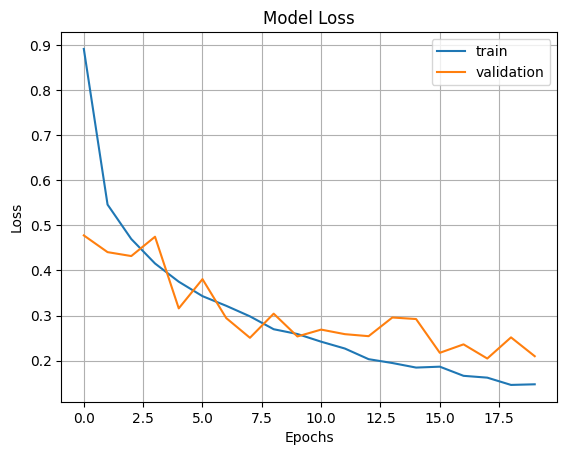

In [ ]:
# Plot of train set loss and validation set loss
metrics[['loss','val_loss']].plot()
# Labelling Graph
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

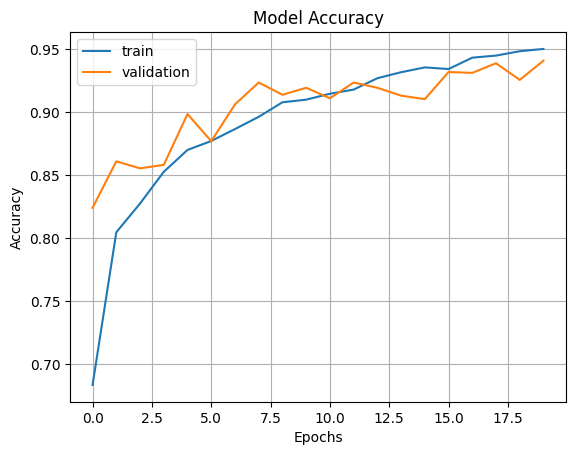

In [ ]:
# Plot of train set accuracy and validation set accuracy
metrics[['accuracy','val_accuracy']].plot()
# Labelling Graph
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

## Model Performance Evaluation

In [ ]:
# Predictions on test set
pred = model.predict(test_generator)
predictions = np.argmax(pred, axis=1)

91/91 [==============================] - 28s 306ms/step


In [ ]:
print(predictions[1000:])

[5 5 5 5 5 5 2 5 5 5 5 5 5 5 1 5 5 0 5 5 5 5 5 5 5 5 3 0 5 3 5 3 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 2 3 5 5 2 3 5 5 0 5 0 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5
 5 5 5 5 3 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5
 5 2 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 0 5 0 0 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5
 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 1 1 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 2
 5 5 5 0 2 5 2 2 5 5 5 5 5 5 0 5 5 5 5 5 2 1 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6]


In [ ]:
# Classification report
target_names = ['Fetal abdomen','Fetal brain','Fetal femur','Fetal thorax','Maternal cervix','Other','Unknown']
print(classification_report(test_generator.classes,predictions,target_names=target_names))

                 precision    recall  f1-score   support

  Fetal abdomen       0.82      0.82      0.82        72
    Fetal brain       0.98      0.99      0.99       310
    Fetal femur       0.78      0.93      0.85       104
   Fetal thorax       0.91      0.97      0.94       173
Maternal cervix       0.99      1.00      0.99       164
          Other       0.95      0.87      0.91       422
        Unknown       1.00      1.00      1.00       202

       accuracy                           0.94      1447
      macro avg       0.92      0.94      0.93      1447
   weighted avg       0.94      0.94      0.94      1447



In [ ]:
# Creating dataframe for confusion matrix
cm = confusion_matrix(test_generator.classes,predictions)
cm_df = pd.DataFrame(cm,
                     index = target_names,
                     columns = target_names)

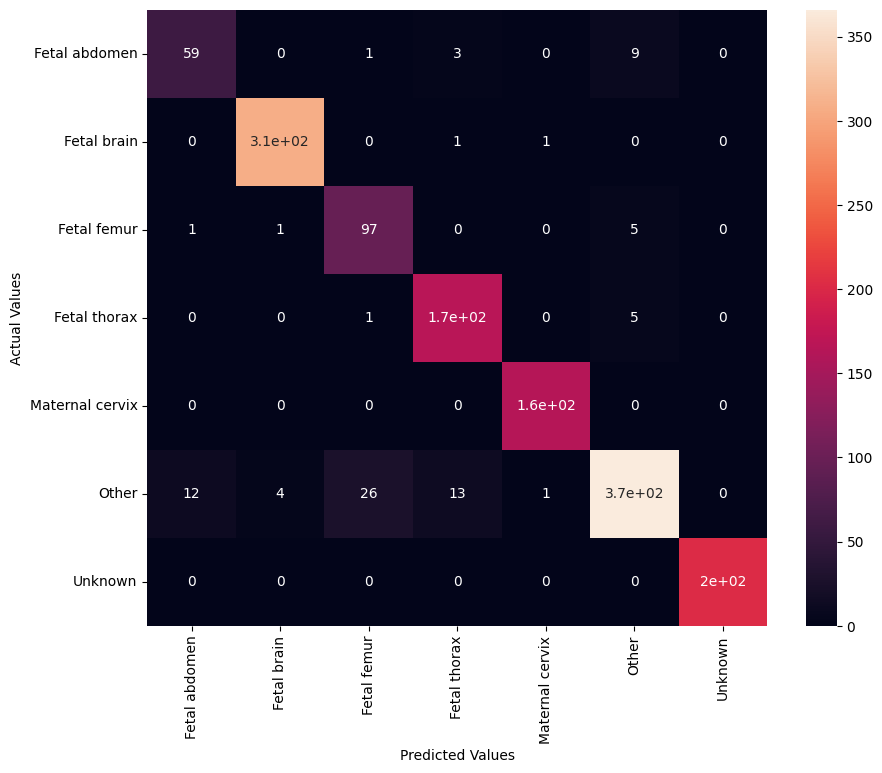

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
#plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## XAI

###GradCAM

In [ ]:
import tensorflow as tf
# Model Explainability
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = preprocess_input(array)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, pred_index=None):

      grad_model = tf.keras.models.Model(
                                  [model.get_layer('input_1').input],
                                  [model.get_layer("conv2d_12").output,
                                  model.output]
                                        )
      print(grad_model.outputs)
      with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          print("preds:",preds[0])
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          print("pred_index:",pred_index)
          class_channel = preds[:, pred_index]
          print("class_channel:",class_channel)


      grads = tape.gradient(class_channel, last_conv_layer_output)


      pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

      last_conv_layer_output = last_conv_layer_output[0]
      heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
      heatmap = tf.squeeze(heatmap)

    #For visualization purpose,we will also normalize the heatmap between 0 & 1
      heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
      return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=5):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Save the heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap * alpha)
    jet_heatmap.save('heatmap.jpg')

    # Display Grad CAM
    display(Image(cam_path))


In [ ]:
# Loading image folder path
gen_dir = test_data_dir + '/Fetal brain/'

# Obtaining random image name from image folder
img_name = random.choice(os.listdir(gen_dir))

# Joining image folder path and image name
img_path = os.path.join(gen_dir, img_name)

# Load image using path
img = tf.keras.preprocessing.image.load_img(img_path)

# Save original image
img.save('original.jpg')

# Prepare image
img_array = get_img_array(img_path, size=(224, 224))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
prediction = np.argmax(preds)
print(prediction)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model)

# Display heatmap
plt.matshow(heatmap,cmap='OrRd')
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.cm as cm
save_and_display_gradcam(img_path, heatmap)

In [ ]:
plt.figure(figsize=(20,20),facecolor='black')

plt.subplot(1,2,1)
img = plt.imread(img_path)
plt.imshow(img,cmap='gray')
plt.grid(False)
plt.axis('off')

plt.subplot(1,2,2)
im = plt.imread("cam.jpg")
plt.imshow(im,cmap='gray')
plt.grid(False)
plt.axis('off')

plt.show()

### LIME

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

# Define the segmentation function
def segment_fn(image):
    segments = slic(image, n_segments=100, compactness=10)
    return segments

In [ ]:
# Load image using path
img = tf.keras.preprocessing.image.load_img(img_path,target_size=target_size)

In [ ]:
image = tf.keras.preprocessing.image.img_to_array(img)

In [ ]:
image.shape

In [ ]:
from skimage.segmentation import slic
# Explain the prediction using LimeImageExplainer with the custom segmentation function
explanation = explainer.explain_instance(image.astype('double'), model.predict,
                                          top_labels=3, hide_color=0, num_samples=1000,
                                          segmentation_fn=segment_fn)

In [ ]:
explanation.top_labels[0]

In [ ]:
# Visualize the explanations
explanation_image, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                         positive_only=True,
                                                         negative_only= False,
                                                         num_features=1, hide_rest=False)

In [ ]:
# Plot the input image and the explanation image with mask
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
axs[0].imshow(image/255)
axs[0].set_title('Input Image')
axs[0].axis('off')
axs[1].imshow(explanation_image/255)
axs[1].imshow(mask, cmap='jet', alpha=0.5)
axs[1].set_title('Explanation Image with Mask')
axs[1].axis('off')
plt.show()

In [ ]:
from skimage.segmentation import mark_boundaries

# Visualize the explanations
explanation_image_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                         positive_only=True,
                                                         negative_only=False,
                                                         num_features=10,
                                                         hide_rest=True)
# Visualize the explanations
explanation_image_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0],
                                                         positive_only=False,
                                                         negative_only=False,
                                                         num_features=10,
                                                         hide_rest=False)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.imshow(mark_boundaries(explanation_image_1/255,mask_1))
ax2.imshow(mark_boundaries(explanation_image_2/255,mask_2))
ax3.imshow(img)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

### SHAP

In [ ]:
!pip install shap

In [ ]:
import shap

#### A quick run with a few evaluations

In [ ]:
# Python function to get model output
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

In [ ]:
batch = next(test_generator)[0]

In [ ]:
batch[0].shape

In [ ]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", batch[0].shape)

In [ ]:
class_names = ['Fetal abdomen','Fetal brain','Fetal femur','Fetal thorax','Maternal cervix','Other','Unknown']

In [ ]:
# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

In [ ]:
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(batch[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

In [ ]:
# output with shap values
shap.image_plot(shap_values[1])

#### A longer run with many evaluations

In [ ]:
# Python function to get model output
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

In [ ]:
batch = next(test_generator)[0]

In [ ]:
batch[0].shape

In [ ]:
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", batch[0].shape)

In [ ]:
class_names = ['Fetal abdomen','Fetal brain','Fetal femur','Fetal thorax','Maternal cervix','Other','Unknown']

In [ ]:
# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

In [ ]:
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(batch[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

In [ ]:
# output with shap values
shap.image_plot(shap_values_fine)

### Saliency Maps

In [ ]:
def input_img(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [512,512])
    return image
def normalize_image(img):
    grads_norm = img[:,:,0]+img[:,:,1]+img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def plot_maps(img1,img2,vmin=0.3,vmax=0.7,mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap='jet')
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap='jet' )
    plt.axis("off")

In [ ]:
# Loading image folder path
gen_dir = test_data_dir + '/Fetal abdomen/'

# Obtaining random image name from image folder
img_name = random.choice(os.listdir(gen_dir))

# Joining image folder path and image name
img_path = os.path.join(gen_dir, img_name)

In [ ]:
img = input_img(img_path)
image = tf.keras.applications.vgg16.preprocess_input(img)

In [ ]:
plt.imshow(normalize_image(image[0]), cmap = "gray")

In [ ]:
result = model(image)
max_idx = tf.argmax(result,axis = 1)
print(max_idx)

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(image)
    result = model(image)
    max_score = result[0,max_idx[0]]
grads = tape.gradient(max_score, image)

In [ ]:
grads.shape

In [ ]:
plot_maps(normalize_image(grads[0]), normalize_image(image[0]))